In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
import numpy as np
from util import getHashId, pickleLoad

feature_selection = pickleLoad('data/feature_selection.pkl')
features_oc = np.load('data/preprocessed/features_vox.npy')
exc = 10
features = [f for f in features_oc if f not in feature_selection['excludeds'][exc][np.argmax(feature_selection['accuracies'][exc])]]

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : features,
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_firstorder_TotalEnergy_firstorder_Minimum_firstorder_10Percentile_firstorder_Median_firstorder_InterquartileRange_firstorder_Range_firstorder_RobustMeanAbsoluteDeviation_firstorder_RootMeanSquared_firstorder_Skewness_firstorder_Kurtosis_firstorder_Variance_firstorder_Uniformity_glcm_JointAverage_glcm_ClusterProminence_glcm_ClusterShade_glcm_ClusterTendency_glcm_Contrast_glcm_Correlation_glcm_DifferenceAverage_glcm_DifferenceEntropy_glcm_DifferenceVariance_glcm_JointEnergy_glcm_JointEntropy_glcm_Imc2_glcm_Idm_glcm_MCC_glcm_Idmn_glcm_Id_glcm_Idn_glcm_InverseVariance_glcm_MaximumProbability_glcm_SumEntropy_glcm_SumSquares_glszm_SmallAreaEmphasis_glszm_LargeAreaEmphasis_glszm_GrayLevelNonUniformity_glszm_GrayLevelNonUniformityNormalized_glszm_SizeZoneNonUniformity_glszm_SizeZoneNonUniformityNormalized_glszm_ZonePercentage_glszm_GrayLevelVariance_glszm_ZoneVariance_glszm_ZoneEntropy_glszm_HighGrayLevelZoneEmphasis_glszm

In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 738)
(4629816, 8)
validation
(621056, 738)
(621056, 8)
test
(624904, 738)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 738)]             0         


 dense (Dense)               (None, 1024)              756736    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1446792 (5.52 MB)


Trainable params: 1446792 (5.52 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 12:13 - loss: 2.1769 - STD: 0.0618 - MAE: 0.2174

  5/463 [..............................] - ETA: 6s - loss: 2.0930 - STD: 0.0451 - MAE: 0.2168   

  9/463 [..............................] - ETA: 6s - loss: 2.0804 - STD: 0.0428 - MAE: 0.2167

 13/463 [..............................] - ETA: 6s - loss: 2.0709 - STD: 0.0401 - MAE: 0.2166

 17/463 [>.............................] - ETA: 6s - loss: 2.0647 - STD: 0.0394 - MAE: 0.2165

 21/463 [>.............................] - ETA: 6s - loss: 2.0559 - STD: 0.0387 - MAE: 0.2162

 25/463 [>.............................] - ETA: 6s - loss: 2.0447 - STD: 0.0388 - MAE: 0.2158

 29/463 [>.............................] - ETA: 6s - loss: 2.0304 - STD: 0.0412 - MAE: 0.2152

 33/463 [=>............................] - ETA: 6s - loss: 2.0147 - STD: 0.0443 - MAE: 0.2144

 36/463 [=>............................] - ETA: 6s - loss: 2.0028 - STD: 0.0465 - MAE: 0.2138

 39/463 [=>............................] - ETA: 6s - loss: 1.9907 - STD: 0.0487 - MAE: 0.2132

 42/463 [=>............................] - ETA: 6s - loss: 1.9780 - STD: 0.0508 - MAE: 0.2125

 45/463 [=>............................] - ETA: 6s - loss: 1.9655 - STD: 0.0529 - MAE: 0.2119

 49/463 [==>...........................] - ETA: 6s - loss: 1.9484 - STD: 0.0555 - MAE: 0.2111

 53/463 [==>...........................] - ETA: 6s - loss: 1.9309 - STD: 0.0580 - MAE: 0.2102

 57/463 [==>...........................] - ETA: 6s - loss: 1.9123 - STD: 0.0607 - MAE: 0.2092

 61/463 [==>...........................] - ETA: 6s - loss: 1.8925 - STD: 0.0635 - MAE: 0.2081

 65/463 [===>..........................] - ETA: 6s - loss: 1.8722 - STD: 0.0664 - MAE: 0.2069

 69/463 [===>..........................] - ETA: 6s - loss: 1.8511 - STD: 0.0694 - MAE: 0.2057

 73/463 [===>..........................] - ETA: 5s - loss: 1.8314 - STD: 0.0724 - MAE: 0.2044

 77/463 [===>..........................] - ETA: 5s - loss: 1.8122 - STD: 0.0755 - MAE: 0.2032

 81/463 [====>.........................] - ETA: 5s - loss: 1.7935 - STD: 0.0784 - MAE: 0.2020

 85/463 [====>.........................] - ETA: 5s - loss: 1.7755 - STD: 0.0814 - MAE: 0.2007

 89/463 [====>.........................] - ETA: 5s - loss: 1.7584 - STD: 0.0842 - MAE: 0.1995

 93/463 [=====>........................] - ETA: 5s - loss: 1.7419 - STD: 0.0869 - MAE: 0.1983

 97/463 [=====>........................] - ETA: 5s - loss: 1.7264 - STD: 0.0895 - MAE: 0.1972

101/463 [=====>........................] - ETA: 5s - loss: 1.7114 - STD: 0.0921 - MAE: 0.1961

105/463 [=====>........................] - ETA: 5s - loss: 1.6974 - STD: 0.0945 - MAE: 0.1950

109/463 [======>.......................] - ETA: 5s - loss: 1.6839 - STD: 0.0968 - MAE: 0.1940

113/463 [======>.......................] - ETA: 5s - loss: 1.6710 - STD: 0.0989 - MAE: 0.1930

117/463 [======>.......................] - ETA: 5s - loss: 1.6591 - STD: 0.1010 - MAE: 0.1921

121/463 [======>.......................] - ETA: 5s - loss: 1.6473 - STD: 0.1029 - MAE: 0.1912

125/463 [=======>......................] - ETA: 5s - loss: 1.6364 - STD: 0.1047 - MAE: 0.1904

129/463 [=======>......................] - ETA: 4s - loss: 1.6258 - STD: 0.1065 - MAE: 0.1895

133/463 [=======>......................] - ETA: 4s - loss: 1.6157 - STD: 0.1082 - MAE: 0.1887

137/463 [=======>......................] - ETA: 4s - loss: 1.6060 - STD: 0.1098 - MAE: 0.1880

140/463 [========>.....................] - ETA: 4s - loss: 1.5990 - STD: 0.1110 - MAE: 0.1874

144/463 [========>.....................] - ETA: 4s - loss: 1.5902 - STD: 0.1125 - MAE: 0.1867

146/463 [========>.....................] - ETA: 6s - loss: 1.5859 - STD: 0.1132 - MAE: 0.1864

150/463 [========>.....................] - ETA: 6s - loss: 1.5775 - STD: 0.1146 - MAE: 0.1857

154/463 [========>.....................] - ETA: 5s - loss: 1.5695 - STD: 0.1160 - MAE: 0.1851

158/463 [=========>....................] - ETA: 5s - loss: 1.5618 - STD: 0.1172 - MAE: 0.1845

162/463 [=========>....................] - ETA: 5s - loss: 1.5542 - STD: 0.1185 - MAE: 0.1839

166/463 [=========>....................] - ETA: 5s - loss: 1.5469 - STD: 0.1197 - MAE: 0.1833

170/463 [==========>...................] - ETA: 5s - loss: 1.5401 - STD: 0.1208 - MAE: 0.1827

174/463 [==========>...................] - ETA: 5s - loss: 1.5332 - STD: 0.1220 - MAE: 0.1822

178/463 [==========>...................] - ETA: 5s - loss: 1.5267 - STD: 0.1231 - MAE: 0.1816

182/463 [==========>...................] - ETA: 5s - loss: 1.5203 - STD: 0.1242 - MAE: 0.1811

186/463 [===========>..................] - ETA: 5s - loss: 1.5142 - STD: 0.1252 - MAE: 0.1806

190/463 [===========>..................] - ETA: 5s - loss: 1.5083 - STD: 0.1262 - MAE: 0.1801

194/463 [===========>..................] - ETA: 4s - loss: 1.5028 - STD: 0.1272 - MAE: 0.1796

198/463 [===========>..................] - ETA: 4s - loss: 1.4971 - STD: 0.1281 - MAE: 0.1791

202/463 [============>.................] - ETA: 4s - loss: 1.4915 - STD: 0.1291 - MAE: 0.1787

206/463 [============>.................] - ETA: 4s - loss: 1.4864 - STD: 0.1299 - MAE: 0.1782

210/463 [============>.................] - ETA: 4s - loss: 1.4814 - STD: 0.1308 - MAE: 0.1778

214/463 [============>.................] - ETA: 4s - loss: 1.4765 - STD: 0.1316 - MAE: 0.1774

218/463 [=============>................] - ETA: 4s - loss: 1.4717 - STD: 0.1324 - MAE: 0.1770

221/463 [=============>................] - ETA: 4s - loss: 1.4681 - STD: 0.1330 - MAE: 0.1767

225/463 [=============>................] - ETA: 4s - loss: 1.4635 - STD: 0.1338 - MAE: 0.1763

228/463 [=============>................] - ETA: 4s - loss: 1.4600 - STD: 0.1344 - MAE: 0.1760

231/463 [=============>................] - ETA: 4s - loss: 1.4565 - STD: 0.1350 - MAE: 0.1757

235/463 [==============>...............] - ETA: 4s - loss: 1.4522 - STD: 0.1357 - MAE: 0.1753

239/463 [==============>...............] - ETA: 4s - loss: 1.4480 - STD: 0.1364 - MAE: 0.1749

243/463 [==============>...............] - ETA: 3s - loss: 1.4437 - STD: 0.1371 - MAE: 0.1746

247/463 [===============>..............] - ETA: 3s - loss: 1.4395 - STD: 0.1378 - MAE: 0.1742

251/463 [===============>..............] - ETA: 3s - loss: 1.4354 - STD: 0.1385 - MAE: 0.1738

255/463 [===============>..............] - ETA: 3s - loss: 1.4314 - STD: 0.1392 - MAE: 0.1735

259/463 [===============>..............] - ETA: 3s - loss: 1.4275 - STD: 0.1398 - MAE: 0.1731

263/463 [================>.............] - ETA: 3s - loss: 1.4237 - STD: 0.1404 - MAE: 0.1728

267/463 [================>.............] - ETA: 3s - loss: 1.4199 - STD: 0.1411 - MAE: 0.1725

271/463 [================>.............] - ETA: 3s - loss: 1.4163 - STD: 0.1417 - MAE: 0.1721

275/463 [================>.............] - ETA: 3s - loss: 1.4127 - STD: 0.1423 - MAE: 0.1718

279/463 [=================>............] - ETA: 3s - loss: 1.4093 - STD: 0.1429 - MAE: 0.1715

283/463 [=================>............] - ETA: 3s - loss: 1.4060 - STD: 0.1434 - MAE: 0.1712

287/463 [=================>............] - ETA: 3s - loss: 1.4027 - STD: 0.1440 - MAE: 0.1709

291/463 [=================>............] - ETA: 2s - loss: 1.3993 - STD: 0.1445 - MAE: 0.1706

295/463 [==================>...........] - ETA: 2s - loss: 1.3961 - STD: 0.1451 - MAE: 0.1703

299/463 [==================>...........] - ETA: 2s - loss: 1.3930 - STD: 0.1456 - MAE: 0.1700

303/463 [==================>...........] - ETA: 2s - loss: 1.3898 - STD: 0.1461 - MAE: 0.1698

307/463 [==================>...........] - ETA: 2s - loss: 1.3866 - STD: 0.1466 - MAE: 0.1695

311/463 [===================>..........] - ETA: 2s - loss: 1.3836 - STD: 0.1471 - MAE: 0.1692

315/463 [===================>..........] - ETA: 2s - loss: 1.3806 - STD: 0.1476 - MAE: 0.1689

319/463 [===================>..........] - ETA: 2s - loss: 1.3776 - STD: 0.1481 - MAE: 0.1686

323/463 [===================>..........] - ETA: 2s - loss: 1.3746 - STD: 0.1486 - MAE: 0.1684

326/463 [====================>.........] - ETA: 2s - loss: 1.3726 - STD: 0.1489 - MAE: 0.1682

330/463 [====================>.........] - ETA: 2s - loss: 1.3699 - STD: 0.1494 - MAE: 0.1679

333/463 [====================>.........] - ETA: 2s - loss: 1.3678 - STD: 0.1497 - MAE: 0.1677

336/463 [====================>.........] - ETA: 2s - loss: 1.3657 - STD: 0.1501 - MAE: 0.1675

339/463 [====================>.........] - ETA: 2s - loss: 1.3637 - STD: 0.1504 - MAE: 0.1674

343/463 [=====================>........] - ETA: 2s - loss: 1.3611 - STD: 0.1509 - MAE: 0.1671

347/463 [=====================>........] - ETA: 1s - loss: 1.3586 - STD: 0.1513 - MAE: 0.1669

351/463 [=====================>........] - ETA: 1s - loss: 1.3561 - STD: 0.1517 - MAE: 0.1666

355/463 [======================>.......] - ETA: 1s - loss: 1.3538 - STD: 0.1521 - MAE: 0.1664

359/463 [======================>.......] - ETA: 1s - loss: 1.3514 - STD: 0.1526 - MAE: 0.1662

363/463 [======================>.......] - ETA: 1s - loss: 1.3491 - STD: 0.1530 - MAE: 0.1660

367/463 [======================>.......] - ETA: 1s - loss: 1.3468 - STD: 0.1534 - MAE: 0.1658

371/463 [=======================>......] - ETA: 1s - loss: 1.3443 - STD: 0.1537 - MAE: 0.1655

375/463 [=======================>......] - ETA: 1s - loss: 1.3419 - STD: 0.1541 - MAE: 0.1653

379/463 [=======================>......] - ETA: 1s - loss: 1.3396 - STD: 0.1545 - MAE: 0.1651

383/463 [=======================>......] - ETA: 1s - loss: 1.3373 - STD: 0.1549 - MAE: 0.1649

387/463 [========================>.....] - ETA: 1s - loss: 1.3351 - STD: 0.1553 - MAE: 0.1647

391/463 [========================>.....] - ETA: 1s - loss: 1.3328 - STD: 0.1556 - MAE: 0.1645

395/463 [========================>.....] - ETA: 1s - loss: 1.3307 - STD: 0.1560 - MAE: 0.1643

399/463 [========================>.....] - ETA: 1s - loss: 1.3286 - STD: 0.1563 - MAE: 0.1641

403/463 [=========================>....] - ETA: 0s - loss: 1.3266 - STD: 0.1567 - MAE: 0.1639

407/463 [=========================>....] - ETA: 0s - loss: 1.3245 - STD: 0.1570 - MAE: 0.1637

411/463 [=========================>....] - ETA: 0s - loss: 1.3223 - STD: 0.1574 - MAE: 0.1635

415/463 [=========================>....] - ETA: 0s - loss: 1.3203 - STD: 0.1577 - MAE: 0.1633

419/463 [==========================>...] - ETA: 0s - loss: 1.3184 - STD: 0.1580 - MAE: 0.1631

422/463 [==========================>...] - ETA: 0s - loss: 1.3169 - STD: 0.1583 - MAE: 0.1629

425/463 [==========================>...] - ETA: 0s - loss: 1.3153 - STD: 0.1585 - MAE: 0.1628

428/463 [==========================>...] - ETA: 0s - loss: 1.3138 - STD: 0.1588 - MAE: 0.1626

431/463 [==========================>...] - ETA: 0s - loss: 1.3123 - STD: 0.1590 - MAE: 0.1625

435/463 [===========================>..] - ETA: 0s - loss: 1.3104 - STD: 0.1593 - MAE: 0.1623

439/463 [===========================>..] - ETA: 0s - loss: 1.3085 - STD: 0.1597 - MAE: 0.1621

443/463 [===========================>..] - ETA: 0s - loss: 1.3066 - STD: 0.1600 - MAE: 0.1620

447/463 [===========================>..] - ETA: 0s - loss: 1.3046 - STD: 0.1603 - MAE: 0.1618

451/463 [============================>.] - ETA: 0s - loss: 1.3027 - STD: 0.1606 - MAE: 0.1616

455/463 [============================>.] - ETA: 0s - loss: 1.3009 - STD: 0.1609 - MAE: 0.1614

459/463 [============================>.] - ETA: 0s - loss: 1.2991 - STD: 0.1612 - MAE: 0.1612

463/463 [==============================] - ETA: 0s - loss: 1.2976 - STD: 0.1615 - MAE: 0.1611

463/463 [==============================] - 11s 19ms/step - loss: 1.2976 - STD: 0.1615 - MAE: 0.1611 - val_loss: 1.1870 - val_STD: 0.1899 - val_MAE: 0.1474


Epoch 2/10000


  1/463 [..............................] - ETA: 19s - loss: 1.1045 - STD: 0.1954 - MAE: 0.1419

  5/463 [..............................] - ETA: 6s - loss: 1.1102 - STD: 0.1944 - MAE: 0.1425 

  9/463 [..............................] - ETA: 6s - loss: 1.1071 - STD: 0.1938 - MAE: 0.1426

 13/463 [..............................] - ETA: 6s - loss: 1.1038 - STD: 0.1938 - MAE: 0.1424

 17/463 [>.............................] - ETA: 6s - loss: 1.0995 - STD: 0.1942 - MAE: 0.1421

 21/463 [>.............................] - ETA: 6s - loss: 1.0971 - STD: 0.1946 - MAE: 0.1417

 25/463 [>.............................] - ETA: 6s - loss: 1.0960 - STD: 0.1950 - MAE: 0.1415

 29/463 [>.............................] - ETA: 6s - loss: 1.0936 - STD: 0.1951 - MAE: 0.1413

 33/463 [=>............................] - ETA: 6s - loss: 1.0924 - STD: 0.1952 - MAE: 0.1412

 37/463 [=>............................] - ETA: 6s - loss: 1.0923 - STD: 0.1954 - MAE: 0.1412

 41/463 [=>............................] - ETA: 6s - loss: 1.0927 - STD: 0.1955 - MAE: 0.1411

 45/463 [=>............................] - ETA: 6s - loss: 1.0920 - STD: 0.1955 - MAE: 0.1411

 49/463 [==>...........................] - ETA: 6s - loss: 1.0918 - STD: 0.1955 - MAE: 0.1411

 53/463 [==>...........................] - ETA: 6s - loss: 1.0916 - STD: 0.1954 - MAE: 0.1411

 57/463 [==>...........................] - ETA: 5s - loss: 1.0913 - STD: 0.1955 - MAE: 0.1411

 61/463 [==>...........................] - ETA: 5s - loss: 1.0908 - STD: 0.1956 - MAE: 0.1410

 65/463 [===>..........................] - ETA: 5s - loss: 1.0904 - STD: 0.1957 - MAE: 0.1409

 69/463 [===>..........................] - ETA: 5s - loss: 1.0901 - STD: 0.1957 - MAE: 0.1409

 73/463 [===>..........................] - ETA: 5s - loss: 1.0893 - STD: 0.1958 - MAE: 0.1408

 77/463 [===>..........................] - ETA: 5s - loss: 1.0895 - STD: 0.1959 - MAE: 0.1408

 81/463 [====>.........................] - ETA: 5s - loss: 1.0889 - STD: 0.1959 - MAE: 0.1408

 84/463 [====>.........................] - ETA: 5s - loss: 1.0886 - STD: 0.1959 - MAE: 0.1408

 87/463 [====>.........................] - ETA: 5s - loss: 1.0881 - STD: 0.1960 - MAE: 0.1407

 90/463 [====>.........................] - ETA: 5s - loss: 1.0876 - STD: 0.1960 - MAE: 0.1407

 94/463 [=====>........................] - ETA: 5s - loss: 1.0875 - STD: 0.1961 - MAE: 0.1406

 98/463 [=====>........................] - ETA: 5s - loss: 1.0868 - STD: 0.1962 - MAE: 0.1406

101/463 [=====>........................] - ETA: 5s - loss: 1.0866 - STD: 0.1962 - MAE: 0.1406

105/463 [=====>........................] - ETA: 5s - loss: 1.0859 - STD: 0.1962 - MAE: 0.1405

109/463 [======>.......................] - ETA: 5s - loss: 1.0858 - STD: 0.1963 - MAE: 0.1405

113/463 [======>.......................] - ETA: 5s - loss: 1.0848 - STD: 0.1964 - MAE: 0.1404

117/463 [======>.......................] - ETA: 5s - loss: 1.0840 - STD: 0.1965 - MAE: 0.1403

121/463 [======>.......................] - ETA: 5s - loss: 1.0838 - STD: 0.1965 - MAE: 0.1403

125/463 [=======>......................] - ETA: 5s - loss: 1.0833 - STD: 0.1966 - MAE: 0.1402

129/463 [=======>......................] - ETA: 5s - loss: 1.0827 - STD: 0.1967 - MAE: 0.1402

133/463 [=======>......................] - ETA: 4s - loss: 1.0817 - STD: 0.1967 - MAE: 0.1401

137/463 [=======>......................] - ETA: 4s - loss: 1.0812 - STD: 0.1968 - MAE: 0.1400

141/463 [========>.....................] - ETA: 4s - loss: 1.0810 - STD: 0.1969 - MAE: 0.1400

145/463 [========>.....................] - ETA: 4s - loss: 1.0807 - STD: 0.1970 - MAE: 0.1399

149/463 [========>.....................] - ETA: 4s - loss: 1.0807 - STD: 0.1970 - MAE: 0.1399

153/463 [========>.....................] - ETA: 4s - loss: 1.0806 - STD: 0.1970 - MAE: 0.1399

157/463 [=========>....................] - ETA: 4s - loss: 1.0802 - STD: 0.1971 - MAE: 0.1398

161/463 [=========>....................] - ETA: 4s - loss: 1.0795 - STD: 0.1972 - MAE: 0.1398

165/463 [=========>....................] - ETA: 4s - loss: 1.0791 - STD: 0.1972 - MAE: 0.1397

169/463 [=========>....................] - ETA: 4s - loss: 1.0785 - STD: 0.1973 - MAE: 0.1397

173/463 [==========>...................] - ETA: 4s - loss: 1.0779 - STD: 0.1974 - MAE: 0.1396

177/463 [==========>...................] - ETA: 4s - loss: 1.0774 - STD: 0.1974 - MAE: 0.1396

181/463 [==========>...................] - ETA: 4s - loss: 1.0768 - STD: 0.1975 - MAE: 0.1395

185/463 [==========>...................] - ETA: 4s - loss: 1.0764 - STD: 0.1976 - MAE: 0.1395

189/463 [===========>..................] - ETA: 4s - loss: 1.0759 - STD: 0.1976 - MAE: 0.1394

193/463 [===========>..................] - ETA: 4s - loss: 1.0755 - STD: 0.1977 - MAE: 0.1394

196/463 [===========>..................] - ETA: 4s - loss: 1.0757 - STD: 0.1977 - MAE: 0.1394

199/463 [===========>..................] - ETA: 3s - loss: 1.0756 - STD: 0.1978 - MAE: 0.1394

202/463 [============>.................] - ETA: 3s - loss: 1.0756 - STD: 0.1978 - MAE: 0.1393

205/463 [============>.................] - ETA: 3s - loss: 1.0754 - STD: 0.1978 - MAE: 0.1393

208/463 [============>.................] - ETA: 3s - loss: 1.0754 - STD: 0.1978 - MAE: 0.1393

212/463 [============>.................] - ETA: 3s - loss: 1.0749 - STD: 0.1979 - MAE: 0.1393

216/463 [============>.................] - ETA: 3s - loss: 1.0745 - STD: 0.1979 - MAE: 0.1392

220/463 [=============>................] - ETA: 3s - loss: 1.0740 - STD: 0.1980 - MAE: 0.1392

224/463 [=============>................] - ETA: 3s - loss: 1.0738 - STD: 0.1980 - MAE: 0.1392

228/463 [=============>................] - ETA: 3s - loss: 1.0734 - STD: 0.1981 - MAE: 0.1391

232/463 [==============>...............] - ETA: 3s - loss: 1.0730 - STD: 0.1981 - MAE: 0.1391

236/463 [==============>...............] - ETA: 3s - loss: 1.0726 - STD: 0.1982 - MAE: 0.1390

240/463 [==============>...............] - ETA: 3s - loss: 1.0720 - STD: 0.1983 - MAE: 0.1390

244/463 [==============>...............] - ETA: 3s - loss: 1.0717 - STD: 0.1983 - MAE: 0.1389

248/463 [===============>..............] - ETA: 3s - loss: 1.0711 - STD: 0.1984 - MAE: 0.1389

252/463 [===============>..............] - ETA: 3s - loss: 1.0707 - STD: 0.1984 - MAE: 0.1388

256/463 [===============>..............] - ETA: 3s - loss: 1.0701 - STD: 0.1985 - MAE: 0.1388

260/463 [===============>..............] - ETA: 3s - loss: 1.0696 - STD: 0.1986 - MAE: 0.1387

264/463 [================>.............] - ETA: 2s - loss: 1.0693 - STD: 0.1986 - MAE: 0.1387

268/463 [================>.............] - ETA: 2s - loss: 1.0688 - STD: 0.1987 - MAE: 0.1386

272/463 [================>.............] - ETA: 2s - loss: 1.0684 - STD: 0.1987 - MAE: 0.1386

276/463 [================>.............] - ETA: 2s - loss: 1.0679 - STD: 0.1988 - MAE: 0.1385

280/463 [=================>............] - ETA: 2s - loss: 1.0675 - STD: 0.1988 - MAE: 0.1385

284/463 [=================>............] - ETA: 2s - loss: 1.0672 - STD: 0.1989 - MAE: 0.1385

288/463 [=================>............] - ETA: 2s - loss: 1.0667 - STD: 0.1989 - MAE: 0.1384

292/463 [=================>............] - ETA: 2s - loss: 1.0661 - STD: 0.1990 - MAE: 0.1384

296/463 [==================>...........] - ETA: 2s - loss: 1.0656 - STD: 0.1991 - MAE: 0.1383

300/463 [==================>...........] - ETA: 2s - loss: 1.0652 - STD: 0.1991 - MAE: 0.1383

304/463 [==================>...........] - ETA: 2s - loss: 1.0648 - STD: 0.1992 - MAE: 0.1382

308/463 [==================>...........] - ETA: 2s - loss: 1.0645 - STD: 0.1992 - MAE: 0.1382

312/463 [===================>..........] - ETA: 2s - loss: 1.0639 - STD: 0.1993 - MAE: 0.1381

316/463 [===================>..........] - ETA: 2s - loss: 1.0634 - STD: 0.1993 - MAE: 0.1381

320/463 [===================>..........] - ETA: 2s - loss: 1.0630 - STD: 0.1994 - MAE: 0.1380

324/463 [===================>..........] - ETA: 2s - loss: 1.0627 - STD: 0.1994 - MAE: 0.1380

328/463 [====================>.........] - ETA: 2s - loss: 1.0624 - STD: 0.1995 - MAE: 0.1380

331/463 [====================>.........] - ETA: 1s - loss: 1.0621 - STD: 0.1996 - MAE: 0.1379

334/463 [====================>.........] - ETA: 1s - loss: 1.0618 - STD: 0.1996 - MAE: 0.1379

337/463 [====================>.........] - ETA: 1s - loss: 1.0614 - STD: 0.1996 - MAE: 0.1379

340/463 [=====================>........] - ETA: 1s - loss: 1.0609 - STD: 0.1997 - MAE: 0.1378

344/463 [=====================>........] - ETA: 1s - loss: 1.0605 - STD: 0.1997 - MAE: 0.1378

348/463 [=====================>........] - ETA: 1s - loss: 1.0599 - STD: 0.1998 - MAE: 0.1377

352/463 [=====================>........] - ETA: 1s - loss: 1.0594 - STD: 0.1999 - MAE: 0.1377

356/463 [======================>.......] - ETA: 1s - loss: 1.0590 - STD: 0.1999 - MAE: 0.1376

360/463 [======================>.......] - ETA: 1s - loss: 1.0588 - STD: 0.2000 - MAE: 0.1376

364/463 [======================>.......] - ETA: 1s - loss: 1.0583 - STD: 0.2000 - MAE: 0.1375

368/463 [======================>.......] - ETA: 1s - loss: 1.0582 - STD: 0.2001 - MAE: 0.1375

372/463 [=======================>......] - ETA: 1s - loss: 1.0577 - STD: 0.2001 - MAE: 0.1375

376/463 [=======================>......] - ETA: 1s - loss: 1.0572 - STD: 0.2002 - MAE: 0.1374

380/463 [=======================>......] - ETA: 1s - loss: 1.0567 - STD: 0.2002 - MAE: 0.1374

384/463 [=======================>......] - ETA: 1s - loss: 1.0563 - STD: 0.2003 - MAE: 0.1373

388/463 [========================>.....] - ETA: 1s - loss: 1.0558 - STD: 0.2003 - MAE: 0.1373

392/463 [========================>.....] - ETA: 1s - loss: 1.0554 - STD: 0.2004 - MAE: 0.1372

396/463 [========================>.....] - ETA: 1s - loss: 1.0551 - STD: 0.2005 - MAE: 0.1372

400/463 [========================>.....] - ETA: 0s - loss: 1.0548 - STD: 0.2005 - MAE: 0.1371

404/463 [=========================>....] - ETA: 0s - loss: 1.0545 - STD: 0.2006 - MAE: 0.1371

408/463 [=========================>....] - ETA: 0s - loss: 1.0540 - STD: 0.2006 - MAE: 0.1371

412/463 [=========================>....] - ETA: 0s - loss: 1.0536 - STD: 0.2007 - MAE: 0.1370

416/463 [=========================>....] - ETA: 0s - loss: 1.0534 - STD: 0.2007 - MAE: 0.1370

420/463 [==========================>...] - ETA: 0s - loss: 1.0530 - STD: 0.2008 - MAE: 0.1369

424/463 [==========================>...] - ETA: 0s - loss: 1.0526 - STD: 0.2008 - MAE: 0.1369

428/463 [==========================>...] - ETA: 0s - loss: 1.0521 - STD: 0.2009 - MAE: 0.1368

432/463 [==========================>...] - ETA: 0s - loss: 1.0517 - STD: 0.2009 - MAE: 0.1368

436/463 [===========================>..] - ETA: 0s - loss: 1.0513 - STD: 0.2010 - MAE: 0.1368

439/463 [===========================>..] - ETA: 0s - loss: 1.0510 - STD: 0.2010 - MAE: 0.1367

442/463 [===========================>..] - ETA: 0s - loss: 1.0508 - STD: 0.2010 - MAE: 0.1367

446/463 [===========================>..] - ETA: 0s - loss: 1.0504 - STD: 0.2011 - MAE: 0.1367

449/463 [============================>.] - ETA: 0s - loss: 1.0501 - STD: 0.2011 - MAE: 0.1366

452/463 [============================>.] - ETA: 0s - loss: 1.0499 - STD: 0.2012 - MAE: 0.1366

456/463 [============================>.] - ETA: 0s - loss: 1.0496 - STD: 0.2012 - MAE: 0.1366

460/463 [============================>.] - ETA: 0s - loss: 1.0492 - STD: 0.2013 - MAE: 0.1365

463/463 [==============================] - 8s 17ms/step - loss: 1.0489 - STD: 0.2013 - MAE: 0.1365 - val_loss: 1.1121 - val_STD: 0.1995 - val_MAE: 0.1409


Epoch 3/10000


  1/463 [..............................] - ETA: 17s - loss: 1.0095 - STD: 0.2063 - MAE: 0.1326

  5/463 [..............................] - ETA: 6s - loss: 1.0237 - STD: 0.2071 - MAE: 0.1329 

  9/463 [..............................] - ETA: 6s - loss: 1.0110 - STD: 0.2073 - MAE: 0.1321

 13/463 [..............................] - ETA: 6s - loss: 1.0127 - STD: 0.2072 - MAE: 0.1321

 17/463 [>.............................] - ETA: 6s - loss: 1.0109 - STD: 0.2072 - MAE: 0.1320

 21/463 [>.............................] - ETA: 6s - loss: 1.0095 - STD: 0.2072 - MAE: 0.1320

 25/463 [>.............................] - ETA: 6s - loss: 1.0098 - STD: 0.2071 - MAE: 0.1320

 29/463 [>.............................] - ETA: 6s - loss: 1.0094 - STD: 0.2072 - MAE: 0.1319

 33/463 [=>............................] - ETA: 6s - loss: 1.0071 - STD: 0.2073 - MAE: 0.1318

 36/463 [=>............................] - ETA: 6s - loss: 1.0067 - STD: 0.2073 - MAE: 0.1317

 39/463 [=>............................] - ETA: 6s - loss: 1.0058 - STD: 0.2074 - MAE: 0.1317

 42/463 [=>............................] - ETA: 6s - loss: 1.0058 - STD: 0.2073 - MAE: 0.1317

 45/463 [=>............................] - ETA: 6s - loss: 1.0052 - STD: 0.2075 - MAE: 0.1316

 49/463 [==>...........................] - ETA: 6s - loss: 1.0048 - STD: 0.2075 - MAE: 0.1316

 53/463 [==>...........................] - ETA: 6s - loss: 1.0055 - STD: 0.2075 - MAE: 0.1316

 57/463 [==>...........................] - ETA: 6s - loss: 1.0043 - STD: 0.2075 - MAE: 0.1315

 61/463 [==>...........................] - ETA: 6s - loss: 1.0031 - STD: 0.2076 - MAE: 0.1314

 65/463 [===>..........................] - ETA: 6s - loss: 1.0016 - STD: 0.2077 - MAE: 0.1313

 69/463 [===>..........................] - ETA: 6s - loss: 1.0006 - STD: 0.2077 - MAE: 0.1312

 73/463 [===>..........................] - ETA: 5s - loss: 1.0003 - STD: 0.2078 - MAE: 0.1312

 77/463 [===>..........................] - ETA: 5s - loss: 0.9993 - STD: 0.2078 - MAE: 0.1311

 81/463 [====>.........................] - ETA: 5s - loss: 0.9991 - STD: 0.2079 - MAE: 0.1311

 85/463 [====>.........................] - ETA: 5s - loss: 0.9983 - STD: 0.2080 - MAE: 0.1310

 89/463 [====>.........................] - ETA: 5s - loss: 0.9971 - STD: 0.2081 - MAE: 0.1309

 93/463 [=====>........................] - ETA: 5s - loss: 0.9964 - STD: 0.2081 - MAE: 0.1308

 97/463 [=====>........................] - ETA: 5s - loss: 0.9957 - STD: 0.2082 - MAE: 0.1307

101/463 [=====>........................] - ETA: 5s - loss: 0.9952 - STD: 0.2083 - MAE: 0.1307

105/463 [=====>........................] - ETA: 5s - loss: 0.9950 - STD: 0.2083 - MAE: 0.1306

109/463 [======>.......................] - ETA: 5s - loss: 0.9956 - STD: 0.2084 - MAE: 0.1307

113/463 [======>.......................] - ETA: 5s - loss: 0.9953 - STD: 0.2084 - MAE: 0.1306

117/463 [======>.......................] - ETA: 5s - loss: 0.9956 - STD: 0.2084 - MAE: 0.1306

121/463 [======>.......................] - ETA: 5s - loss: 0.9957 - STD: 0.2085 - MAE: 0.1306

125/463 [=======>......................] - ETA: 5s - loss: 0.9954 - STD: 0.2085 - MAE: 0.1306

129/463 [=======>......................] - ETA: 5s - loss: 0.9955 - STD: 0.2085 - MAE: 0.1306

133/463 [=======>......................] - ETA: 4s - loss: 0.9951 - STD: 0.2086 - MAE: 0.1305

137/463 [=======>......................] - ETA: 4s - loss: 0.9944 - STD: 0.2086 - MAE: 0.1305

141/463 [========>.....................] - ETA: 4s - loss: 0.9939 - STD: 0.2087 - MAE: 0.1304

145/463 [========>.....................] - ETA: 4s - loss: 0.9934 - STD: 0.2087 - MAE: 0.1304

149/463 [========>.....................] - ETA: 4s - loss: 0.9932 - STD: 0.2088 - MAE: 0.1304

153/463 [========>.....................] - ETA: 4s - loss: 0.9926 - STD: 0.2088 - MAE: 0.1303

157/463 [=========>....................] - ETA: 4s - loss: 0.9920 - STD: 0.2089 - MAE: 0.1303

161/463 [=========>....................] - ETA: 4s - loss: 0.9917 - STD: 0.2089 - MAE: 0.1302

164/463 [=========>....................] - ETA: 4s - loss: 0.9918 - STD: 0.2090 - MAE: 0.1302

167/463 [=========>....................] - ETA: 4s - loss: 0.9919 - STD: 0.2090 - MAE: 0.1302

170/463 [==========>...................] - ETA: 4s - loss: 0.9921 - STD: 0.2091 - MAE: 0.1302

173/463 [==========>...................] - ETA: 4s - loss: 0.9923 - STD: 0.2091 - MAE: 0.1302

176/463 [==========>...................] - ETA: 4s - loss: 0.9924 - STD: 0.2091 - MAE: 0.1302

179/463 [==========>...................] - ETA: 4s - loss: 0.9922 - STD: 0.2091 - MAE: 0.1302

183/463 [==========>...................] - ETA: 4s - loss: 0.9921 - STD: 0.2092 - MAE: 0.1301

187/463 [===========>..................] - ETA: 4s - loss: 0.9923 - STD: 0.2092 - MAE: 0.1301

191/463 [===========>..................] - ETA: 4s - loss: 0.9922 - STD: 0.2092 - MAE: 0.1301

195/463 [===========>..................] - ETA: 4s - loss: 0.9917 - STD: 0.2092 - MAE: 0.1301

199/463 [===========>..................] - ETA: 3s - loss: 0.9916 - STD: 0.2092 - MAE: 0.1301

203/463 [============>.................] - ETA: 3s - loss: 0.9913 - STD: 0.2093 - MAE: 0.1300

207/463 [============>.................] - ETA: 3s - loss: 0.9907 - STD: 0.2093 - MAE: 0.1300

211/463 [============>.................] - ETA: 3s - loss: 0.9904 - STD: 0.2094 - MAE: 0.1300

215/463 [============>.................] - ETA: 3s - loss: 0.9898 - STD: 0.2094 - MAE: 0.1299

219/463 [=============>................] - ETA: 3s - loss: 0.9892 - STD: 0.2095 - MAE: 0.1298

223/463 [=============>................] - ETA: 3s - loss: 0.9888 - STD: 0.2095 - MAE: 0.1298

227/463 [=============>................] - ETA: 3s - loss: 0.9883 - STD: 0.2096 - MAE: 0.1298

231/463 [=============>................] - ETA: 3s - loss: 0.9878 - STD: 0.2096 - MAE: 0.1297

235/463 [==============>...............] - ETA: 3s - loss: 0.9874 - STD: 0.2097 - MAE: 0.1297

239/463 [==============>...............] - ETA: 3s - loss: 0.9872 - STD: 0.2097 - MAE: 0.1297

243/463 [==============>...............] - ETA: 3s - loss: 0.9880 - STD: 0.2097 - MAE: 0.1297

247/463 [===============>..............] - ETA: 3s - loss: 0.9882 - STD: 0.2098 - MAE: 0.1297

251/463 [===============>..............] - ETA: 3s - loss: 0.9883 - STD: 0.2098 - MAE: 0.1297

255/463 [===============>..............] - ETA: 3s - loss: 0.9882 - STD: 0.2098 - MAE: 0.1296

259/463 [===============>..............] - ETA: 3s - loss: 0.9878 - STD: 0.2099 - MAE: 0.1296

263/463 [================>.............] - ETA: 2s - loss: 0.9876 - STD: 0.2099 - MAE: 0.1296

267/463 [================>.............] - ETA: 2s - loss: 0.9872 - STD: 0.2099 - MAE: 0.1296

271/463 [================>.............] - ETA: 2s - loss: 0.9868 - STD: 0.2100 - MAE: 0.1295

275/463 [================>.............] - ETA: 2s - loss: 0.9865 - STD: 0.2100 - MAE: 0.1295

279/463 [=================>............] - ETA: 2s - loss: 0.9860 - STD: 0.2100 - MAE: 0.1294

283/463 [=================>............] - ETA: 2s - loss: 0.9856 - STD: 0.2101 - MAE: 0.1294

287/463 [=================>............] - ETA: 2s - loss: 0.9852 - STD: 0.2101 - MAE: 0.1294

291/463 [=================>............] - ETA: 2s - loss: 0.9849 - STD: 0.2101 - MAE: 0.1293

295/463 [==================>...........] - ETA: 2s - loss: 0.9845 - STD: 0.2102 - MAE: 0.1293

299/463 [==================>...........] - ETA: 2s - loss: 0.9842 - STD: 0.2102 - MAE: 0.1293

303/463 [==================>...........] - ETA: 2s - loss: 0.9837 - STD: 0.2103 - MAE: 0.1292

307/463 [==================>...........] - ETA: 2s - loss: 0.9832 - STD: 0.2103 - MAE: 0.1292

311/463 [===================>..........] - ETA: 2s - loss: 0.9828 - STD: 0.2104 - MAE: 0.1291

315/463 [===================>..........] - ETA: 2s - loss: 0.9827 - STD: 0.2104 - MAE: 0.1291

319/463 [===================>..........] - ETA: 2s - loss: 0.9824 - STD: 0.2104 - MAE: 0.1291

323/463 [===================>..........] - ETA: 2s - loss: 0.9822 - STD: 0.2105 - MAE: 0.1290

327/463 [====================>.........] - ETA: 2s - loss: 0.9821 - STD: 0.2105 - MAE: 0.1290

331/463 [====================>.........] - ETA: 1s - loss: 0.9818 - STD: 0.2105 - MAE: 0.1290

335/463 [====================>.........] - ETA: 1s - loss: 0.9814 - STD: 0.2106 - MAE: 0.1289

339/463 [====================>.........] - ETA: 1s - loss: 0.9810 - STD: 0.2106 - MAE: 0.1289

343/463 [=====================>........] - ETA: 1s - loss: 0.9806 - STD: 0.2107 - MAE: 0.1289

347/463 [=====================>........] - ETA: 1s - loss: 0.9803 - STD: 0.2107 - MAE: 0.1288

351/463 [=====================>........] - ETA: 1s - loss: 0.9799 - STD: 0.2107 - MAE: 0.1288

355/463 [======================>.......] - ETA: 1s - loss: 0.9795 - STD: 0.2108 - MAE: 0.1288

359/463 [======================>.......] - ETA: 1s - loss: 0.9792 - STD: 0.2108 - MAE: 0.1287

363/463 [======================>.......] - ETA: 1s - loss: 0.9790 - STD: 0.2109 - MAE: 0.1287

367/463 [======================>.......] - ETA: 1s - loss: 0.9788 - STD: 0.2109 - MAE: 0.1287

371/463 [=======================>......] - ETA: 1s - loss: 0.9786 - STD: 0.2110 - MAE: 0.1286

375/463 [=======================>......] - ETA: 1s - loss: 0.9784 - STD: 0.2110 - MAE: 0.1286

379/463 [=======================>......] - ETA: 1s - loss: 0.9785 - STD: 0.2110 - MAE: 0.1286

382/463 [=======================>......] - ETA: 1s - loss: 0.9784 - STD: 0.2110 - MAE: 0.1286

385/463 [=======================>......] - ETA: 1s - loss: 0.9782 - STD: 0.2111 - MAE: 0.1286

389/463 [========================>.....] - ETA: 1s - loss: 0.9779 - STD: 0.2111 - MAE: 0.1285

392/463 [========================>.....] - ETA: 1s - loss: 0.9777 - STD: 0.2111 - MAE: 0.1285

396/463 [========================>.....] - ETA: 1s - loss: 0.9774 - STD: 0.2112 - MAE: 0.1285

400/463 [========================>.....] - ETA: 0s - loss: 0.9771 - STD: 0.2112 - MAE: 0.1284

404/463 [=========================>....] - ETA: 0s - loss: 0.9768 - STD: 0.2112 - MAE: 0.1284

408/463 [=========================>....] - ETA: 0s - loss: 0.9763 - STD: 0.2113 - MAE: 0.1284

412/463 [=========================>....] - ETA: 0s - loss: 0.9759 - STD: 0.2113 - MAE: 0.1283

416/463 [=========================>....] - ETA: 0s - loss: 0.9755 - STD: 0.2114 - MAE: 0.1283

420/463 [==========================>...] - ETA: 0s - loss: 0.9752 - STD: 0.2114 - MAE: 0.1283

424/463 [==========================>...] - ETA: 0s - loss: 0.9749 - STD: 0.2115 - MAE: 0.1282

428/463 [==========================>...] - ETA: 0s - loss: 0.9746 - STD: 0.2115 - MAE: 0.1282

432/463 [==========================>...] - ETA: 0s - loss: 0.9743 - STD: 0.2115 - MAE: 0.1282

436/463 [===========================>..] - ETA: 0s - loss: 0.9740 - STD: 0.2116 - MAE: 0.1281

440/463 [===========================>..] - ETA: 0s - loss: 0.9739 - STD: 0.2116 - MAE: 0.1281

444/463 [===========================>..] - ETA: 0s - loss: 0.9736 - STD: 0.2116 - MAE: 0.1281

448/463 [============================>.] - ETA: 0s - loss: 0.9733 - STD: 0.2117 - MAE: 0.1280

452/463 [============================>.] - ETA: 0s - loss: 0.9730 - STD: 0.2117 - MAE: 0.1280

456/463 [============================>.] - ETA: 0s - loss: 0.9728 - STD: 0.2118 - MAE: 0.1280

460/463 [============================>.] - ETA: 0s - loss: 0.9724 - STD: 0.2118 - MAE: 0.1279

463/463 [==============================] - 8s 17ms/step - loss: 0.9722 - STD: 0.2118 - MAE: 0.1279 - val_loss: 1.1361 - val_STD: 0.2091 - val_MAE: 0.1367


Epoch 4/10000


  1/463 [..............................] - ETA: 22s - loss: 0.9266 - STD: 0.2159 - MAE: 0.1233

  5/463 [..............................] - ETA: 6s - loss: 0.9295 - STD: 0.2163 - MAE: 0.1236 

  9/463 [..............................] - ETA: 6s - loss: 0.9300 - STD: 0.2160 - MAE: 0.1237

 13/463 [..............................] - ETA: 6s - loss: 0.9323 - STD: 0.2163 - MAE: 0.1237

 17/463 [>.............................] - ETA: 6s - loss: 0.9308 - STD: 0.2166 - MAE: 0.1235

 21/463 [>.............................] - ETA: 6s - loss: 0.9328 - STD: 0.2165 - MAE: 0.1236

 25/463 [>.............................] - ETA: 6s - loss: 0.9345 - STD: 0.2165 - MAE: 0.1238

 29/463 [>.............................] - ETA: 6s - loss: 0.9341 - STD: 0.2165 - MAE: 0.1237

 33/463 [=>............................] - ETA: 6s - loss: 0.9342 - STD: 0.2164 - MAE: 0.1238

 37/463 [=>............................] - ETA: 6s - loss: 0.9351 - STD: 0.2165 - MAE: 0.1238

 41/463 [=>............................] - ETA: 6s - loss: 0.9357 - STD: 0.2165 - MAE: 0.1238

 45/463 [=>............................] - ETA: 6s - loss: 0.9345 - STD: 0.2165 - MAE: 0.1238

 49/463 [==>...........................] - ETA: 6s - loss: 0.9346 - STD: 0.2167 - MAE: 0.1237

 53/463 [==>...........................] - ETA: 5s - loss: 0.9350 - STD: 0.2168 - MAE: 0.1237

 57/463 [==>...........................] - ETA: 5s - loss: 0.9375 - STD: 0.2167 - MAE: 0.1239

 61/463 [==>...........................] - ETA: 5s - loss: 0.9383 - STD: 0.2167 - MAE: 0.1239

 65/463 [===>..........................] - ETA: 5s - loss: 0.9385 - STD: 0.2167 - MAE: 0.1239

 68/463 [===>..........................] - ETA: 5s - loss: 0.9388 - STD: 0.2167 - MAE: 0.1239

 71/463 [===>..........................] - ETA: 5s - loss: 0.9382 - STD: 0.2167 - MAE: 0.1239

 74/463 [===>..........................] - ETA: 5s - loss: 0.9375 - STD: 0.2167 - MAE: 0.1239

 77/463 [===>..........................] - ETA: 5s - loss: 0.9376 - STD: 0.2167 - MAE: 0.1239

 80/463 [====>.........................] - ETA: 5s - loss: 0.9370 - STD: 0.2167 - MAE: 0.1238

 83/463 [====>.........................] - ETA: 5s - loss: 0.9368 - STD: 0.2167 - MAE: 0.1238

 87/463 [====>.........................] - ETA: 5s - loss: 0.9366 - STD: 0.2167 - MAE: 0.1238

 91/463 [====>.........................] - ETA: 5s - loss: 0.9365 - STD: 0.2168 - MAE: 0.1238

 95/463 [=====>........................] - ETA: 5s - loss: 0.9360 - STD: 0.2167 - MAE: 0.1237

 99/463 [=====>........................] - ETA: 5s - loss: 0.9356 - STD: 0.2168 - MAE: 0.1237

103/463 [=====>........................] - ETA: 5s - loss: 0.9351 - STD: 0.2168 - MAE: 0.1236

107/463 [=====>........................] - ETA: 5s - loss: 0.9348 - STD: 0.2169 - MAE: 0.1236

111/463 [======>.......................] - ETA: 5s - loss: 0.9353 - STD: 0.2169 - MAE: 0.1236

115/463 [======>.......................] - ETA: 5s - loss: 0.9360 - STD: 0.2170 - MAE: 0.1236

119/463 [======>.......................] - ETA: 5s - loss: 0.9369 - STD: 0.2170 - MAE: 0.1237

123/463 [======>.......................] - ETA: 5s - loss: 0.9368 - STD: 0.2170 - MAE: 0.1237

127/463 [=======>......................] - ETA: 5s - loss: 0.9371 - STD: 0.2170 - MAE: 0.1237

131/463 [=======>......................] - ETA: 4s - loss: 0.9376 - STD: 0.2170 - MAE: 0.1237

135/463 [=======>......................] - ETA: 4s - loss: 0.9381 - STD: 0.2170 - MAE: 0.1238

139/463 [========>.....................] - ETA: 4s - loss: 0.9387 - STD: 0.2169 - MAE: 0.1238

143/463 [========>.....................] - ETA: 4s - loss: 0.9392 - STD: 0.2169 - MAE: 0.1238

147/463 [========>.....................] - ETA: 4s - loss: 0.9390 - STD: 0.2169 - MAE: 0.1238

151/463 [========>.....................] - ETA: 4s - loss: 0.9386 - STD: 0.2169 - MAE: 0.1238

155/463 [=========>....................] - ETA: 4s - loss: 0.9382 - STD: 0.2169 - MAE: 0.1238

159/463 [=========>....................] - ETA: 4s - loss: 0.9380 - STD: 0.2169 - MAE: 0.1238

163/463 [=========>....................] - ETA: 4s - loss: 0.9376 - STD: 0.2169 - MAE: 0.1238

167/463 [=========>....................] - ETA: 4s - loss: 0.9371 - STD: 0.2169 - MAE: 0.1237

171/463 [==========>...................] - ETA: 4s - loss: 0.9368 - STD: 0.2169 - MAE: 0.1237

174/463 [==========>...................] - ETA: 4s - loss: 0.9365 - STD: 0.2169 - MAE: 0.1237

177/463 [==========>...................] - ETA: 4s - loss: 0.9362 - STD: 0.2169 - MAE: 0.1237

180/463 [==========>...................] - ETA: 4s - loss: 0.9358 - STD: 0.2170 - MAE: 0.1236

183/463 [==========>...................] - ETA: 4s - loss: 0.9355 - STD: 0.2170 - MAE: 0.1236

187/463 [===========>..................] - ETA: 4s - loss: 0.9357 - STD: 0.2170 - MAE: 0.1236

191/463 [===========>..................] - ETA: 4s - loss: 0.9357 - STD: 0.2171 - MAE: 0.1236

195/463 [===========>..................] - ETA: 4s - loss: 0.9354 - STD: 0.2171 - MAE: 0.1236

199/463 [===========>..................] - ETA: 3s - loss: 0.9351 - STD: 0.2171 - MAE: 0.1235

203/463 [============>.................] - ETA: 3s - loss: 0.9349 - STD: 0.2171 - MAE: 0.1235

207/463 [============>.................] - ETA: 3s - loss: 0.9347 - STD: 0.2171 - MAE: 0.1235

211/463 [============>.................] - ETA: 3s - loss: 0.9344 - STD: 0.2172 - MAE: 0.1235

215/463 [============>.................] - ETA: 3s - loss: 0.9342 - STD: 0.2172 - MAE: 0.1235

219/463 [=============>................] - ETA: 3s - loss: 0.9339 - STD: 0.2172 - MAE: 0.1234

223/463 [=============>................] - ETA: 3s - loss: 0.9339 - STD: 0.2173 - MAE: 0.1234

227/463 [=============>................] - ETA: 3s - loss: 0.9336 - STD: 0.2173 - MAE: 0.1234

231/463 [=============>................] - ETA: 3s - loss: 0.9333 - STD: 0.2173 - MAE: 0.1233

235/463 [==============>...............] - ETA: 3s - loss: 0.9331 - STD: 0.2173 - MAE: 0.1233

239/463 [==============>...............] - ETA: 3s - loss: 0.9328 - STD: 0.2174 - MAE: 0.1233

243/463 [==============>...............] - ETA: 3s - loss: 0.9326 - STD: 0.2174 - MAE: 0.1233

247/463 [===============>..............] - ETA: 3s - loss: 0.9321 - STD: 0.2175 - MAE: 0.1232

251/463 [===============>..............] - ETA: 3s - loss: 0.9317 - STD: 0.2175 - MAE: 0.1232

255/463 [===============>..............] - ETA: 3s - loss: 0.9315 - STD: 0.2175 - MAE: 0.1232

259/463 [===============>..............] - ETA: 3s - loss: 0.9317 - STD: 0.2175 - MAE: 0.1232

263/463 [================>.............] - ETA: 3s - loss: 0.9317 - STD: 0.2176 - MAE: 0.1231

267/463 [================>.............] - ETA: 2s - loss: 0.9315 - STD: 0.2176 - MAE: 0.1231

271/463 [================>.............] - ETA: 2s - loss: 0.9313 - STD: 0.2176 - MAE: 0.1231

275/463 [================>.............] - ETA: 2s - loss: 0.9309 - STD: 0.2177 - MAE: 0.1231

279/463 [=================>............] - ETA: 2s - loss: 0.9305 - STD: 0.2177 - MAE: 0.1230

283/463 [=================>............] - ETA: 2s - loss: 0.9303 - STD: 0.2177 - MAE: 0.1230

286/463 [=================>............] - ETA: 2s - loss: 0.9301 - STD: 0.2177 - MAE: 0.1230

289/463 [=================>............] - ETA: 2s - loss: 0.9299 - STD: 0.2177 - MAE: 0.1230

292/463 [=================>............] - ETA: 2s - loss: 0.9296 - STD: 0.2178 - MAE: 0.1229

295/463 [==================>...........] - ETA: 2s - loss: 0.9295 - STD: 0.2178 - MAE: 0.1229

298/463 [==================>...........] - ETA: 2s - loss: 0.9292 - STD: 0.2178 - MAE: 0.1229

301/463 [==================>...........] - ETA: 2s - loss: 0.9292 - STD: 0.2178 - MAE: 0.1229

305/463 [==================>...........] - ETA: 2s - loss: 0.9290 - STD: 0.2178 - MAE: 0.1229

309/463 [===================>..........] - ETA: 2s - loss: 0.9288 - STD: 0.2179 - MAE: 0.1229

313/463 [===================>..........] - ETA: 2s - loss: 0.9284 - STD: 0.2179 - MAE: 0.1228

317/463 [===================>..........] - ETA: 2s - loss: 0.9281 - STD: 0.2179 - MAE: 0.1228

321/463 [===================>..........] - ETA: 2s - loss: 0.9278 - STD: 0.2180 - MAE: 0.1228

325/463 [====================>.........] - ETA: 2s - loss: 0.9280 - STD: 0.2180 - MAE: 0.1228

329/463 [====================>.........] - ETA: 2s - loss: 0.9280 - STD: 0.2180 - MAE: 0.1227

333/463 [====================>.........] - ETA: 1s - loss: 0.9278 - STD: 0.2180 - MAE: 0.1227

337/463 [====================>.........] - ETA: 1s - loss: 0.9276 - STD: 0.2181 - MAE: 0.1227

341/463 [=====================>........] - ETA: 1s - loss: 0.9275 - STD: 0.2181 - MAE: 0.1227

345/463 [=====================>........] - ETA: 1s - loss: 0.9272 - STD: 0.2181 - MAE: 0.1227

349/463 [=====================>........] - ETA: 1s - loss: 0.9268 - STD: 0.2181 - MAE: 0.1226

353/463 [=====================>........] - ETA: 1s - loss: 0.9266 - STD: 0.2181 - MAE: 0.1226

357/463 [======================>.......] - ETA: 1s - loss: 0.9264 - STD: 0.2182 - MAE: 0.1226

361/463 [======================>.......] - ETA: 1s - loss: 0.9261 - STD: 0.2182 - MAE: 0.1226

365/463 [======================>.......] - ETA: 1s - loss: 0.9258 - STD: 0.2182 - MAE: 0.1225

369/463 [======================>.......] - ETA: 1s - loss: 0.9256 - STD: 0.2183 - MAE: 0.1225

373/463 [=======================>......] - ETA: 1s - loss: 0.9255 - STD: 0.2183 - MAE: 0.1225

377/463 [=======================>......] - ETA: 1s - loss: 0.9253 - STD: 0.2183 - MAE: 0.1225

381/463 [=======================>......] - ETA: 1s - loss: 0.9250 - STD: 0.2183 - MAE: 0.1224

384/463 [=======================>......] - ETA: 1s - loss: 0.9249 - STD: 0.2184 - MAE: 0.1224

387/463 [========================>.....] - ETA: 1s - loss: 0.9247 - STD: 0.2184 - MAE: 0.1224

390/463 [========================>.....] - ETA: 1s - loss: 0.9247 - STD: 0.2184 - MAE: 0.1224

393/463 [========================>.....] - ETA: 1s - loss: 0.9245 - STD: 0.2184 - MAE: 0.1224

396/463 [========================>.....] - ETA: 1s - loss: 0.9245 - STD: 0.2184 - MAE: 0.1224

399/463 [========================>.....] - ETA: 0s - loss: 0.9242 - STD: 0.2184 - MAE: 0.1223

403/463 [=========================>....] - ETA: 0s - loss: 0.9240 - STD: 0.2185 - MAE: 0.1223

407/463 [=========================>....] - ETA: 0s - loss: 0.9237 - STD: 0.2185 - MAE: 0.1223

411/463 [=========================>....] - ETA: 0s - loss: 0.9235 - STD: 0.2185 - MAE: 0.1223

415/463 [=========================>....] - ETA: 0s - loss: 0.9231 - STD: 0.2185 - MAE: 0.1222

419/463 [==========================>...] - ETA: 0s - loss: 0.9227 - STD: 0.2186 - MAE: 0.1222

423/463 [==========================>...] - ETA: 0s - loss: 0.9225 - STD: 0.2186 - MAE: 0.1222

427/463 [==========================>...] - ETA: 0s - loss: 0.9223 - STD: 0.2186 - MAE: 0.1221

431/463 [==========================>...] - ETA: 0s - loss: 0.9221 - STD: 0.2187 - MAE: 0.1221

435/463 [===========================>..] - ETA: 0s - loss: 0.9219 - STD: 0.2187 - MAE: 0.1221

439/463 [===========================>..] - ETA: 0s - loss: 0.9216 - STD: 0.2187 - MAE: 0.1221

443/463 [===========================>..] - ETA: 0s - loss: 0.9214 - STD: 0.2187 - MAE: 0.1220

447/463 [===========================>..] - ETA: 0s - loss: 0.9214 - STD: 0.2188 - MAE: 0.1220

451/463 [============================>.] - ETA: 0s - loss: 0.9213 - STD: 0.2188 - MAE: 0.1220

455/463 [============================>.] - ETA: 0s - loss: 0.9211 - STD: 0.2188 - MAE: 0.1220

459/463 [============================>.] - ETA: 0s - loss: 0.9211 - STD: 0.2188 - MAE: 0.1220

463/463 [==============================] - ETA: 0s - loss: 0.9209 - STD: 0.2189 - MAE: 0.1220

463/463 [==============================] - 8s 17ms/step - loss: 0.9209 - STD: 0.2189 - MAE: 0.1220 - val_loss: 1.1085 - val_STD: 0.2153 - val_MAE: 0.1337


Epoch 5/10000


  1/463 [..............................] - ETA: 25s - loss: 0.9260 - STD: 0.2218 - MAE: 0.1209

  4/463 [..............................] - ETA: 8s - loss: 0.9056 - STD: 0.2215 - MAE: 0.1200 

  8/463 [..............................] - ETA: 7s - loss: 0.9101 - STD: 0.2214 - MAE: 0.1203

 12/463 [..............................] - ETA: 7s - loss: 0.9053 - STD: 0.2215 - MAE: 0.1200

 15/463 [..............................] - ETA: 7s - loss: 0.9071 - STD: 0.2215 - MAE: 0.1201

 18/463 [>.............................] - ETA: 7s - loss: 0.9055 - STD: 0.2213 - MAE: 0.1200

 21/463 [>.............................] - ETA: 7s - loss: 0.9045 - STD: 0.2212 - MAE: 0.1200

 24/463 [>.............................] - ETA: 7s - loss: 0.9039 - STD: 0.2211 - MAE: 0.1200

 27/463 [>.............................] - ETA: 7s - loss: 0.9020 - STD: 0.2211 - MAE: 0.1198

 31/463 [=>............................] - ETA: 7s - loss: 0.9001 - STD: 0.2212 - MAE: 0.1197

 34/463 [=>............................] - ETA: 7s - loss: 0.8996 - STD: 0.2212 - MAE: 0.1197

 37/463 [=>............................] - ETA: 7s - loss: 0.8999 - STD: 0.2213 - MAE: 0.1197

 40/463 [=>............................] - ETA: 7s - loss: 0.9008 - STD: 0.2213 - MAE: 0.1197

 44/463 [=>............................] - ETA: 7s - loss: 0.8997 - STD: 0.2214 - MAE: 0.1196

 48/463 [==>...........................] - ETA: 6s - loss: 0.8999 - STD: 0.2215 - MAE: 0.1196

 52/463 [==>...........................] - ETA: 6s - loss: 0.9001 - STD: 0.2215 - MAE: 0.1196

 56/463 [==>...........................] - ETA: 6s - loss: 0.9010 - STD: 0.2216 - MAE: 0.1196

 60/463 [==>...........................] - ETA: 6s - loss: 0.9008 - STD: 0.2216 - MAE: 0.1196

 64/463 [===>..........................] - ETA: 6s - loss: 0.9006 - STD: 0.2216 - MAE: 0.1196

 68/463 [===>..........................] - ETA: 6s - loss: 0.9001 - STD: 0.2216 - MAE: 0.1195

 72/463 [===>..........................] - ETA: 6s - loss: 0.9000 - STD: 0.2217 - MAE: 0.1195

 76/463 [===>..........................] - ETA: 6s - loss: 0.9001 - STD: 0.2217 - MAE: 0.1195

 80/463 [====>.........................] - ETA: 6s - loss: 0.9017 - STD: 0.2217 - MAE: 0.1196

 84/463 [====>.........................] - ETA: 5s - loss: 0.9014 - STD: 0.2217 - MAE: 0.1195

 88/463 [====>.........................] - ETA: 5s - loss: 0.9008 - STD: 0.2217 - MAE: 0.1195

 92/463 [====>.........................] - ETA: 5s - loss: 0.9005 - STD: 0.2217 - MAE: 0.1195

 96/463 [=====>........................] - ETA: 5s - loss: 0.9000 - STD: 0.2217 - MAE: 0.1195

100/463 [=====>........................] - ETA: 5s - loss: 0.8994 - STD: 0.2218 - MAE: 0.1194

104/463 [=====>........................] - ETA: 5s - loss: 0.8989 - STD: 0.2218 - MAE: 0.1194

108/463 [=====>........................] - ETA: 5s - loss: 0.8996 - STD: 0.2218 - MAE: 0.1194

112/463 [======>.......................] - ETA: 5s - loss: 0.9002 - STD: 0.2218 - MAE: 0.1194

116/463 [======>.......................] - ETA: 5s - loss: 0.9002 - STD: 0.2218 - MAE: 0.1194

120/463 [======>.......................] - ETA: 5s - loss: 0.8997 - STD: 0.2219 - MAE: 0.1194

124/463 [=======>......................] - ETA: 5s - loss: 0.8997 - STD: 0.2219 - MAE: 0.1194

128/463 [=======>......................] - ETA: 5s - loss: 0.8998 - STD: 0.2219 - MAE: 0.1194

132/463 [=======>......................] - ETA: 5s - loss: 0.8997 - STD: 0.2220 - MAE: 0.1194

135/463 [=======>......................] - ETA: 5s - loss: 0.8996 - STD: 0.2220 - MAE: 0.1193

139/463 [========>.....................] - ETA: 4s - loss: 0.8995 - STD: 0.2220 - MAE: 0.1193

143/463 [========>.....................] - ETA: 4s - loss: 0.8997 - STD: 0.2220 - MAE: 0.1193

147/463 [========>.....................] - ETA: 4s - loss: 0.8999 - STD: 0.2220 - MAE: 0.1193

151/463 [========>.....................] - ETA: 4s - loss: 0.9002 - STD: 0.2220 - MAE: 0.1193

155/463 [=========>....................] - ETA: 4s - loss: 0.9004 - STD: 0.2220 - MAE: 0.1193

159/463 [=========>....................] - ETA: 4s - loss: 0.9004 - STD: 0.2220 - MAE: 0.1194

163/463 [=========>....................] - ETA: 4s - loss: 0.9003 - STD: 0.2220 - MAE: 0.1194

167/463 [=========>....................] - ETA: 4s - loss: 0.9005 - STD: 0.2220 - MAE: 0.1194

171/463 [==========>...................] - ETA: 4s - loss: 0.9001 - STD: 0.2220 - MAE: 0.1193

175/463 [==========>...................] - ETA: 4s - loss: 0.8995 - STD: 0.2220 - MAE: 0.1193

179/463 [==========>...................] - ETA: 4s - loss: 0.8990 - STD: 0.2220 - MAE: 0.1193

183/463 [==========>...................] - ETA: 4s - loss: 0.8985 - STD: 0.2221 - MAE: 0.1192

187/463 [===========>..................] - ETA: 4s - loss: 0.8980 - STD: 0.2221 - MAE: 0.1192

191/463 [===========>..................] - ETA: 4s - loss: 0.8977 - STD: 0.2221 - MAE: 0.1192

195/463 [===========>..................] - ETA: 4s - loss: 0.8973 - STD: 0.2221 - MAE: 0.1191

199/463 [===========>..................] - ETA: 3s - loss: 0.8968 - STD: 0.2222 - MAE: 0.1191

203/463 [============>.................] - ETA: 3s - loss: 0.8966 - STD: 0.2222 - MAE: 0.1191

207/463 [============>.................] - ETA: 3s - loss: 0.8967 - STD: 0.2222 - MAE: 0.1191

211/463 [============>.................] - ETA: 3s - loss: 0.8964 - STD: 0.2222 - MAE: 0.1190

215/463 [============>.................] - ETA: 3s - loss: 0.8960 - STD: 0.2223 - MAE: 0.1190

219/463 [=============>................] - ETA: 3s - loss: 0.8962 - STD: 0.2223 - MAE: 0.1190

223/463 [=============>................] - ETA: 3s - loss: 0.8962 - STD: 0.2223 - MAE: 0.1190

227/463 [=============>................] - ETA: 3s - loss: 0.8961 - STD: 0.2223 - MAE: 0.1190

230/463 [=============>................] - ETA: 3s - loss: 0.8958 - STD: 0.2224 - MAE: 0.1189

233/463 [==============>...............] - ETA: 3s - loss: 0.8955 - STD: 0.2224 - MAE: 0.1189

236/463 [==============>...............] - ETA: 3s - loss: 0.8952 - STD: 0.2224 - MAE: 0.1189

239/463 [==============>...............] - ETA: 3s - loss: 0.8949 - STD: 0.2224 - MAE: 0.1189

243/463 [==============>...............] - ETA: 3s - loss: 0.8946 - STD: 0.2224 - MAE: 0.1188

247/463 [===============>..............] - ETA: 3s - loss: 0.8943 - STD: 0.2224 - MAE: 0.1188

251/463 [===============>..............] - ETA: 3s - loss: 0.8939 - STD: 0.2225 - MAE: 0.1188

255/463 [===============>..............] - ETA: 3s - loss: 0.8938 - STD: 0.2225 - MAE: 0.1188

259/463 [===============>..............] - ETA: 3s - loss: 0.8935 - STD: 0.2225 - MAE: 0.1187

263/463 [================>.............] - ETA: 3s - loss: 0.8933 - STD: 0.2225 - MAE: 0.1187

267/463 [================>.............] - ETA: 2s - loss: 0.8931 - STD: 0.2225 - MAE: 0.1187

271/463 [================>.............] - ETA: 2s - loss: 0.8929 - STD: 0.2226 - MAE: 0.1187

275/463 [================>.............] - ETA: 2s - loss: 0.8926 - STD: 0.2226 - MAE: 0.1186

279/463 [=================>............] - ETA: 2s - loss: 0.8923 - STD: 0.2226 - MAE: 0.1186

283/463 [=================>............] - ETA: 2s - loss: 0.8920 - STD: 0.2227 - MAE: 0.1186

287/463 [=================>............] - ETA: 2s - loss: 0.8918 - STD: 0.2227 - MAE: 0.1186

291/463 [=================>............] - ETA: 2s - loss: 0.8918 - STD: 0.2227 - MAE: 0.1185

295/463 [==================>...........] - ETA: 2s - loss: 0.8920 - STD: 0.2227 - MAE: 0.1185

299/463 [==================>...........] - ETA: 2s - loss: 0.8919 - STD: 0.2228 - MAE: 0.1185

303/463 [==================>...........] - ETA: 2s - loss: 0.8919 - STD: 0.2228 - MAE: 0.1185

307/463 [==================>...........] - ETA: 2s - loss: 0.8921 - STD: 0.2228 - MAE: 0.1185

311/463 [===================>..........] - ETA: 2s - loss: 0.8922 - STD: 0.2228 - MAE: 0.1185

314/463 [===================>..........] - ETA: 2s - loss: 0.8925 - STD: 0.2228 - MAE: 0.1185

317/463 [===================>..........] - ETA: 2s - loss: 0.8928 - STD: 0.2228 - MAE: 0.1186

321/463 [===================>..........] - ETA: 2s - loss: 0.8927 - STD: 0.2228 - MAE: 0.1185

324/463 [===================>..........] - ETA: 2s - loss: 0.8927 - STD: 0.2228 - MAE: 0.1185

327/463 [====================>.........] - ETA: 2s - loss: 0.8927 - STD: 0.2228 - MAE: 0.1185

330/463 [====================>.........] - ETA: 2s - loss: 0.8926 - STD: 0.2228 - MAE: 0.1185

333/463 [====================>.........] - ETA: 1s - loss: 0.8925 - STD: 0.2229 - MAE: 0.1185

336/463 [====================>.........] - ETA: 1s - loss: 0.8922 - STD: 0.2229 - MAE: 0.1185

339/463 [====================>.........] - ETA: 1s - loss: 0.8921 - STD: 0.2229 - MAE: 0.1185

343/463 [=====================>........] - ETA: 1s - loss: 0.8919 - STD: 0.2229 - MAE: 0.1185

347/463 [=====================>........] - ETA: 1s - loss: 0.8918 - STD: 0.2229 - MAE: 0.1185

351/463 [=====================>........] - ETA: 1s - loss: 0.8917 - STD: 0.2229 - MAE: 0.1184

355/463 [======================>.......] - ETA: 1s - loss: 0.8914 - STD: 0.2229 - MAE: 0.1184

359/463 [======================>.......] - ETA: 1s - loss: 0.8912 - STD: 0.2229 - MAE: 0.1184

363/463 [======================>.......] - ETA: 1s - loss: 0.8909 - STD: 0.2230 - MAE: 0.1184

367/463 [======================>.......] - ETA: 1s - loss: 0.8907 - STD: 0.2230 - MAE: 0.1184

371/463 [=======================>......] - ETA: 1s - loss: 0.8905 - STD: 0.2230 - MAE: 0.1183

375/463 [=======================>......] - ETA: 1s - loss: 0.8902 - STD: 0.2230 - MAE: 0.1183

379/463 [=======================>......] - ETA: 1s - loss: 0.8899 - STD: 0.2230 - MAE: 0.1183

383/463 [=======================>......] - ETA: 1s - loss: 0.8898 - STD: 0.2230 - MAE: 0.1183

387/463 [========================>.....] - ETA: 1s - loss: 0.8896 - STD: 0.2231 - MAE: 0.1183

391/463 [========================>.....] - ETA: 1s - loss: 0.8893 - STD: 0.2231 - MAE: 0.1182

395/463 [========================>.....] - ETA: 1s - loss: 0.8891 - STD: 0.2231 - MAE: 0.1182

399/463 [========================>.....] - ETA: 0s - loss: 0.8889 - STD: 0.2231 - MAE: 0.1182

403/463 [=========================>....] - ETA: 0s - loss: 0.8888 - STD: 0.2231 - MAE: 0.1182

407/463 [=========================>....] - ETA: 0s - loss: 0.8889 - STD: 0.2232 - MAE: 0.1182

411/463 [=========================>....] - ETA: 0s - loss: 0.8889 - STD: 0.2232 - MAE: 0.1182

415/463 [=========================>....] - ETA: 0s - loss: 0.8889 - STD: 0.2232 - MAE: 0.1182

419/463 [==========================>...] - ETA: 0s - loss: 0.8887 - STD: 0.2232 - MAE: 0.1181

423/463 [==========================>...] - ETA: 0s - loss: 0.8886 - STD: 0.2232 - MAE: 0.1181

427/463 [==========================>...] - ETA: 0s - loss: 0.8884 - STD: 0.2232 - MAE: 0.1181

431/463 [==========================>...] - ETA: 0s - loss: 0.8881 - STD: 0.2233 - MAE: 0.1181

435/463 [===========================>..] - ETA: 0s - loss: 0.8879 - STD: 0.2233 - MAE: 0.1181

439/463 [===========================>..] - ETA: 0s - loss: 0.8876 - STD: 0.2233 - MAE: 0.1180

443/463 [===========================>..] - ETA: 0s - loss: 0.8873 - STD: 0.2233 - MAE: 0.1180

446/463 [===========================>..] - ETA: 0s - loss: 0.8871 - STD: 0.2233 - MAE: 0.1180

449/463 [============================>.] - ETA: 0s - loss: 0.8869 - STD: 0.2233 - MAE: 0.1180

453/463 [============================>.] - ETA: 0s - loss: 0.8867 - STD: 0.2234 - MAE: 0.1180

456/463 [============================>.] - ETA: 0s - loss: 0.8864 - STD: 0.2234 - MAE: 0.1179

459/463 [============================>.] - ETA: 0s - loss: 0.8862 - STD: 0.2234 - MAE: 0.1179

463/463 [==============================] - ETA: 0s - loss: 0.8861 - STD: 0.2234 - MAE: 0.1179

463/463 [==============================] - 8s 17ms/step - loss: 0.8861 - STD: 0.2234 - MAE: 0.1179 - val_loss: 1.1335 - val_STD: 0.2191 - val_MAE: 0.1329


Epoch 6/10000


  1/463 [..............................] - ETA: 24s - loss: 0.9046 - STD: 0.2250 - MAE: 0.1186

  5/463 [..............................] - ETA: 6s - loss: 0.8918 - STD: 0.2261 - MAE: 0.1171 

  9/463 [..............................] - ETA: 6s - loss: 0.8911 - STD: 0.2262 - MAE: 0.1170

 13/463 [..............................] - ETA: 6s - loss: 0.8829 - STD: 0.2258 - MAE: 0.1167

 16/463 [>.............................] - ETA: 6s - loss: 0.8787 - STD: 0.2258 - MAE: 0.1165

 19/463 [>.............................] - ETA: 6s - loss: 0.8762 - STD: 0.2259 - MAE: 0.1163

 22/463 [>.............................] - ETA: 6s - loss: 0.8757 - STD: 0.2260 - MAE: 0.1162

 25/463 [>.............................] - ETA: 6s - loss: 0.8737 - STD: 0.2261 - MAE: 0.1160

 28/463 [>.............................] - ETA: 6s - loss: 0.8742 - STD: 0.2260 - MAE: 0.1161

 31/463 [=>............................] - ETA: 6s - loss: 0.8740 - STD: 0.2258 - MAE: 0.1161

 34/463 [=>............................] - ETA: 6s - loss: 0.8759 - STD: 0.2258 - MAE: 0.1163

 38/463 [=>............................] - ETA: 6s - loss: 0.8753 - STD: 0.2257 - MAE: 0.1162

 42/463 [=>............................] - ETA: 6s - loss: 0.8747 - STD: 0.2257 - MAE: 0.1162

 46/463 [=>............................] - ETA: 6s - loss: 0.8730 - STD: 0.2258 - MAE: 0.1161

 50/463 [==>...........................] - ETA: 6s - loss: 0.8720 - STD: 0.2258 - MAE: 0.1160

 54/463 [==>...........................] - ETA: 6s - loss: 0.8712 - STD: 0.2258 - MAE: 0.1160

 58/463 [==>...........................] - ETA: 6s - loss: 0.8708 - STD: 0.2258 - MAE: 0.1160

 62/463 [===>..........................] - ETA: 6s - loss: 0.8699 - STD: 0.2258 - MAE: 0.1159

 66/463 [===>..........................] - ETA: 6s - loss: 0.8692 - STD: 0.2259 - MAE: 0.1158

 70/463 [===>..........................] - ETA: 6s - loss: 0.8686 - STD: 0.2259 - MAE: 0.1158

 74/463 [===>..........................] - ETA: 6s - loss: 0.8682 - STD: 0.2258 - MAE: 0.1158

 78/463 [====>.........................] - ETA: 5s - loss: 0.8682 - STD: 0.2259 - MAE: 0.1157

 82/463 [====>.........................] - ETA: 5s - loss: 0.8682 - STD: 0.2260 - MAE: 0.1157

 86/463 [====>.........................] - ETA: 5s - loss: 0.8678 - STD: 0.2260 - MAE: 0.1156

 90/463 [====>.........................] - ETA: 5s - loss: 0.8679 - STD: 0.2260 - MAE: 0.1156

 94/463 [=====>........................] - ETA: 5s - loss: 0.8683 - STD: 0.2260 - MAE: 0.1157

 98/463 [=====>........................] - ETA: 5s - loss: 0.8684 - STD: 0.2261 - MAE: 0.1157

102/463 [=====>........................] - ETA: 5s - loss: 0.8682 - STD: 0.2260 - MAE: 0.1156

106/463 [=====>........................] - ETA: 5s - loss: 0.8682 - STD: 0.2261 - MAE: 0.1156

110/463 [======>.......................] - ETA: 5s - loss: 0.8684 - STD: 0.2261 - MAE: 0.1156

114/463 [======>.......................] - ETA: 5s - loss: 0.8682 - STD: 0.2261 - MAE: 0.1156

117/463 [======>.......................] - ETA: 5s - loss: 0.8680 - STD: 0.2261 - MAE: 0.1156

121/463 [======>.......................] - ETA: 5s - loss: 0.8675 - STD: 0.2261 - MAE: 0.1156

125/463 [=======>......................] - ETA: 5s - loss: 0.8672 - STD: 0.2261 - MAE: 0.1156

128/463 [=======>......................] - ETA: 5s - loss: 0.8670 - STD: 0.2261 - MAE: 0.1156

131/463 [=======>......................] - ETA: 5s - loss: 0.8666 - STD: 0.2260 - MAE: 0.1156

134/463 [=======>......................] - ETA: 5s - loss: 0.8664 - STD: 0.2261 - MAE: 0.1155

138/463 [=======>......................] - ETA: 5s - loss: 0.8660 - STD: 0.2261 - MAE: 0.1155

141/463 [========>.....................] - ETA: 5s - loss: 0.8656 - STD: 0.2261 - MAE: 0.1155

145/463 [========>.....................] - ETA: 4s - loss: 0.8664 - STD: 0.2261 - MAE: 0.1155

149/463 [========>.....................] - ETA: 4s - loss: 0.8667 - STD: 0.2262 - MAE: 0.1155

153/463 [========>.....................] - ETA: 4s - loss: 0.8668 - STD: 0.2262 - MAE: 0.1155

157/463 [=========>....................] - ETA: 4s - loss: 0.8666 - STD: 0.2262 - MAE: 0.1155

161/463 [=========>....................] - ETA: 4s - loss: 0.8666 - STD: 0.2262 - MAE: 0.1155

165/463 [=========>....................] - ETA: 4s - loss: 0.8665 - STD: 0.2262 - MAE: 0.1155

169/463 [=========>....................] - ETA: 4s - loss: 0.8663 - STD: 0.2262 - MAE: 0.1155

173/463 [==========>...................] - ETA: 4s - loss: 0.8661 - STD: 0.2262 - MAE: 0.1154

177/463 [==========>...................] - ETA: 4s - loss: 0.8659 - STD: 0.2262 - MAE: 0.1154

181/463 [==========>...................] - ETA: 4s - loss: 0.8654 - STD: 0.2262 - MAE: 0.1154

185/463 [==========>...................] - ETA: 4s - loss: 0.8649 - STD: 0.2263 - MAE: 0.1154

189/463 [===========>..................] - ETA: 4s - loss: 0.8647 - STD: 0.2263 - MAE: 0.1153

193/463 [===========>..................] - ETA: 4s - loss: 0.8644 - STD: 0.2263 - MAE: 0.1153

197/463 [===========>..................] - ETA: 4s - loss: 0.8641 - STD: 0.2263 - MAE: 0.1153

201/463 [============>.................] - ETA: 4s - loss: 0.8640 - STD: 0.2263 - MAE: 0.1153

205/463 [============>.................] - ETA: 3s - loss: 0.8637 - STD: 0.2264 - MAE: 0.1152

209/463 [============>.................] - ETA: 3s - loss: 0.8636 - STD: 0.2264 - MAE: 0.1152

213/463 [============>.................] - ETA: 3s - loss: 0.8632 - STD: 0.2264 - MAE: 0.1152

217/463 [=============>................] - ETA: 3s - loss: 0.8632 - STD: 0.2264 - MAE: 0.1152

221/463 [=============>................] - ETA: 3s - loss: 0.8631 - STD: 0.2264 - MAE: 0.1152

225/463 [=============>................] - ETA: 3s - loss: 0.8630 - STD: 0.2264 - MAE: 0.1152

229/463 [=============>................] - ETA: 3s - loss: 0.8630 - STD: 0.2265 - MAE: 0.1151

233/463 [==============>...............] - ETA: 3s - loss: 0.8634 - STD: 0.2265 - MAE: 0.1152

237/463 [==============>...............] - ETA: 3s - loss: 0.8629 - STD: 0.2265 - MAE: 0.1151

241/463 [==============>...............] - ETA: 3s - loss: 0.8625 - STD: 0.2265 - MAE: 0.1151

245/463 [==============>...............] - ETA: 3s - loss: 0.8622 - STD: 0.2265 - MAE: 0.1151

249/463 [===============>..............] - ETA: 3s - loss: 0.8620 - STD: 0.2265 - MAE: 0.1151

253/463 [===============>..............] - ETA: 3s - loss: 0.8617 - STD: 0.2265 - MAE: 0.1150

257/463 [===============>..............] - ETA: 3s - loss: 0.8616 - STD: 0.2266 - MAE: 0.1150

261/463 [===============>..............] - ETA: 3s - loss: 0.8618 - STD: 0.2266 - MAE: 0.1150

265/463 [================>.............] - ETA: 3s - loss: 0.8619 - STD: 0.2266 - MAE: 0.1150

269/463 [================>.............] - ETA: 2s - loss: 0.8621 - STD: 0.2266 - MAE: 0.1150

273/463 [================>.............] - ETA: 2s - loss: 0.8622 - STD: 0.2266 - MAE: 0.1150

277/463 [================>.............] - ETA: 2s - loss: 0.8623 - STD: 0.2266 - MAE: 0.1150

281/463 [=================>............] - ETA: 2s - loss: 0.8623 - STD: 0.2266 - MAE: 0.1150

285/463 [=================>............] - ETA: 2s - loss: 0.8622 - STD: 0.2266 - MAE: 0.1150

289/463 [=================>............] - ETA: 2s - loss: 0.8620 - STD: 0.2266 - MAE: 0.1150

293/463 [=================>............] - ETA: 2s - loss: 0.8619 - STD: 0.2266 - MAE: 0.1150

297/463 [==================>...........] - ETA: 2s - loss: 0.8618 - STD: 0.2266 - MAE: 0.1150

301/463 [==================>...........] - ETA: 2s - loss: 0.8618 - STD: 0.2266 - MAE: 0.1150

305/463 [==================>...........] - ETA: 2s - loss: 0.8620 - STD: 0.2266 - MAE: 0.1150

309/463 [===================>..........] - ETA: 2s - loss: 0.8619 - STD: 0.2267 - MAE: 0.1150

313/463 [===================>..........] - ETA: 2s - loss: 0.8619 - STD: 0.2267 - MAE: 0.1150

317/463 [===================>..........] - ETA: 2s - loss: 0.8619 - STD: 0.2266 - MAE: 0.1150

321/463 [===================>..........] - ETA: 2s - loss: 0.8617 - STD: 0.2267 - MAE: 0.1150

325/463 [====================>.........] - ETA: 2s - loss: 0.8615 - STD: 0.2267 - MAE: 0.1150

329/463 [====================>.........] - ETA: 2s - loss: 0.8615 - STD: 0.2267 - MAE: 0.1150

333/463 [====================>.........] - ETA: 1s - loss: 0.8615 - STD: 0.2267 - MAE: 0.1150

337/463 [====================>.........] - ETA: 1s - loss: 0.8614 - STD: 0.2267 - MAE: 0.1149

341/463 [=====================>........] - ETA: 1s - loss: 0.8612 - STD: 0.2267 - MAE: 0.1149

345/463 [=====================>........] - ETA: 1s - loss: 0.8611 - STD: 0.2267 - MAE: 0.1149

349/463 [=====================>........] - ETA: 1s - loss: 0.8611 - STD: 0.2267 - MAE: 0.1149

353/463 [=====================>........] - ETA: 1s - loss: 0.8609 - STD: 0.2268 - MAE: 0.1149

357/463 [======================>.......] - ETA: 1s - loss: 0.8607 - STD: 0.2268 - MAE: 0.1149

361/463 [======================>.......] - ETA: 1s - loss: 0.8605 - STD: 0.2268 - MAE: 0.1149

365/463 [======================>.......] - ETA: 1s - loss: 0.8606 - STD: 0.2268 - MAE: 0.1149

369/463 [======================>.......] - ETA: 1s - loss: 0.8605 - STD: 0.2268 - MAE: 0.1148

373/463 [=======================>......] - ETA: 1s - loss: 0.8603 - STD: 0.2268 - MAE: 0.1148

377/463 [=======================>......] - ETA: 1s - loss: 0.8602 - STD: 0.2268 - MAE: 0.1148

381/463 [=======================>......] - ETA: 1s - loss: 0.8599 - STD: 0.2268 - MAE: 0.1148

385/463 [=======================>......] - ETA: 1s - loss: 0.8596 - STD: 0.2269 - MAE: 0.1148

388/463 [========================>.....] - ETA: 1s - loss: 0.8594 - STD: 0.2269 - MAE: 0.1147

392/463 [========================>.....] - ETA: 1s - loss: 0.8592 - STD: 0.2269 - MAE: 0.1147

396/463 [========================>.....] - ETA: 1s - loss: 0.8588 - STD: 0.2269 - MAE: 0.1147

400/463 [========================>.....] - ETA: 0s - loss: 0.8586 - STD: 0.2269 - MAE: 0.1147

404/463 [=========================>....] - ETA: 0s - loss: 0.8585 - STD: 0.2270 - MAE: 0.1146

407/463 [=========================>....] - ETA: 0s - loss: 0.8583 - STD: 0.2270 - MAE: 0.1146

411/463 [=========================>....] - ETA: 0s - loss: 0.8580 - STD: 0.2270 - MAE: 0.1146

414/463 [=========================>....] - ETA: 0s - loss: 0.8579 - STD: 0.2270 - MAE: 0.1146

417/463 [==========================>...] - ETA: 0s - loss: 0.8579 - STD: 0.2270 - MAE: 0.1146

420/463 [==========================>...] - ETA: 0s - loss: 0.8580 - STD: 0.2270 - MAE: 0.1146

424/463 [==========================>...] - ETA: 0s - loss: 0.8581 - STD: 0.2270 - MAE: 0.1146

428/463 [==========================>...] - ETA: 0s - loss: 0.8580 - STD: 0.2271 - MAE: 0.1146

431/463 [==========================>...] - ETA: 0s - loss: 0.8579 - STD: 0.2271 - MAE: 0.1146

435/463 [===========================>..] - ETA: 0s - loss: 0.8579 - STD: 0.2271 - MAE: 0.1145

439/463 [===========================>..] - ETA: 0s - loss: 0.8578 - STD: 0.2271 - MAE: 0.1145

442/463 [===========================>..] - ETA: 0s - loss: 0.8577 - STD: 0.2271 - MAE: 0.1145

446/463 [===========================>..] - ETA: 0s - loss: 0.8576 - STD: 0.2271 - MAE: 0.1145

450/463 [============================>.] - ETA: 0s - loss: 0.8574 - STD: 0.2271 - MAE: 0.1145

453/463 [============================>.] - ETA: 0s - loss: 0.8573 - STD: 0.2271 - MAE: 0.1145

457/463 [============================>.] - ETA: 0s - loss: 0.8570 - STD: 0.2272 - MAE: 0.1145

461/463 [============================>.] - ETA: 0s - loss: 0.8568 - STD: 0.2272 - MAE: 0.1144

463/463 [==============================] - 8s 17ms/step - loss: 0.8566 - STD: 0.2272 - MAE: 0.1144 - val_loss: 1.0757 - val_STD: 0.2231 - val_MAE: 0.1293


Epoch 7/10000


  1/463 [..............................] - ETA: 22s - loss: 0.8244 - STD: 0.2315 - MAE: 0.1104

  5/463 [..............................] - ETA: 7s - loss: 0.8296 - STD: 0.2295 - MAE: 0.1117 

  8/463 [..............................] - ETA: 7s - loss: 0.8346 - STD: 0.2290 - MAE: 0.1122

 12/463 [..............................] - ETA: 7s - loss: 0.8432 - STD: 0.2291 - MAE: 0.1127

 15/463 [..............................] - ETA: 7s - loss: 0.8422 - STD: 0.2291 - MAE: 0.1127

 19/463 [>.............................] - ETA: 7s - loss: 0.8426 - STD: 0.2289 - MAE: 0.1128

 23/463 [>.............................] - ETA: 7s - loss: 0.8430 - STD: 0.2292 - MAE: 0.1127

 27/463 [>.............................] - ETA: 7s - loss: 0.8411 - STD: 0.2291 - MAE: 0.1126

 31/463 [=>............................] - ETA: 7s - loss: 0.8403 - STD: 0.2291 - MAE: 0.1125

 34/463 [=>............................] - ETA: 7s - loss: 0.8401 - STD: 0.2291 - MAE: 0.1125

 38/463 [=>............................] - ETA: 7s - loss: 0.8388 - STD: 0.2290 - MAE: 0.1125

 41/463 [=>............................] - ETA: 7s - loss: 0.8392 - STD: 0.2290 - MAE: 0.1125

 44/463 [=>............................] - ETA: 6s - loss: 0.8391 - STD: 0.2291 - MAE: 0.1124

 47/463 [==>...........................] - ETA: 6s - loss: 0.8389 - STD: 0.2291 - MAE: 0.1124

 51/463 [==>...........................] - ETA: 6s - loss: 0.8382 - STD: 0.2291 - MAE: 0.1124

 54/463 [==>...........................] - ETA: 6s - loss: 0.8395 - STD: 0.2292 - MAE: 0.1125

 58/463 [==>...........................] - ETA: 6s - loss: 0.8410 - STD: 0.2292 - MAE: 0.1125

 62/463 [===>..........................] - ETA: 6s - loss: 0.8413 - STD: 0.2292 - MAE: 0.1126

 66/463 [===>..........................] - ETA: 6s - loss: 0.8417 - STD: 0.2292 - MAE: 0.1126

 69/463 [===>..........................] - ETA: 6s - loss: 0.8418 - STD: 0.2292 - MAE: 0.1126

 73/463 [===>..........................] - ETA: 6s - loss: 0.8417 - STD: 0.2292 - MAE: 0.1126

 77/463 [===>..........................] - ETA: 6s - loss: 0.8427 - STD: 0.2292 - MAE: 0.1127

 81/463 [====>.........................] - ETA: 6s - loss: 0.8429 - STD: 0.2292 - MAE: 0.1127

 84/463 [====>.........................] - ETA: 6s - loss: 0.8430 - STD: 0.2292 - MAE: 0.1127

 88/463 [====>.........................] - ETA: 6s - loss: 0.8438 - STD: 0.2292 - MAE: 0.1127

 91/463 [====>.........................] - ETA: 6s - loss: 0.8440 - STD: 0.2292 - MAE: 0.1127

 95/463 [=====>........................] - ETA: 6s - loss: 0.8435 - STD: 0.2292 - MAE: 0.1127

 99/463 [=====>........................] - ETA: 6s - loss: 0.8431 - STD: 0.2292 - MAE: 0.1127

102/463 [=====>........................] - ETA: 5s - loss: 0.8431 - STD: 0.2292 - MAE: 0.1127

105/463 [=====>........................] - ETA: 5s - loss: 0.8433 - STD: 0.2292 - MAE: 0.1127

108/463 [=====>........................] - ETA: 5s - loss: 0.8438 - STD: 0.2292 - MAE: 0.1127

112/463 [======>.......................] - ETA: 5s - loss: 0.8441 - STD: 0.2292 - MAE: 0.1127

115/463 [======>.......................] - ETA: 5s - loss: 0.8440 - STD: 0.2292 - MAE: 0.1127

118/463 [======>.......................] - ETA: 5s - loss: 0.8440 - STD: 0.2292 - MAE: 0.1127

122/463 [======>.......................] - ETA: 5s - loss: 0.8433 - STD: 0.2293 - MAE: 0.1127

125/463 [=======>......................] - ETA: 5s - loss: 0.8431 - STD: 0.2293 - MAE: 0.1126

128/463 [=======>......................] - ETA: 5s - loss: 0.8429 - STD: 0.2293 - MAE: 0.1126

131/463 [=======>......................] - ETA: 5s - loss: 0.8425 - STD: 0.2293 - MAE: 0.1126

135/463 [=======>......................] - ETA: 5s - loss: 0.8423 - STD: 0.2293 - MAE: 0.1126

138/463 [=======>......................] - ETA: 5s - loss: 0.8420 - STD: 0.2293 - MAE: 0.1126

142/463 [========>.....................] - ETA: 5s - loss: 0.8415 - STD: 0.2293 - MAE: 0.1125

146/463 [========>.....................] - ETA: 5s - loss: 0.8411 - STD: 0.2293 - MAE: 0.1125

149/463 [========>.....................] - ETA: 5s - loss: 0.8409 - STD: 0.2293 - MAE: 0.1125

152/463 [========>.....................] - ETA: 5s - loss: 0.8406 - STD: 0.2293 - MAE: 0.1125

155/463 [=========>....................] - ETA: 5s - loss: 0.8403 - STD: 0.2294 - MAE: 0.1124

158/463 [=========>....................] - ETA: 5s - loss: 0.8402 - STD: 0.2294 - MAE: 0.1124

161/463 [=========>....................] - ETA: 5s - loss: 0.8401 - STD: 0.2294 - MAE: 0.1124

165/463 [=========>....................] - ETA: 4s - loss: 0.8399 - STD: 0.2294 - MAE: 0.1124

169/463 [=========>....................] - ETA: 4s - loss: 0.8393 - STD: 0.2294 - MAE: 0.1124

173/463 [==========>...................] - ETA: 4s - loss: 0.8389 - STD: 0.2294 - MAE: 0.1123

176/463 [==========>...................] - ETA: 4s - loss: 0.8385 - STD: 0.2294 - MAE: 0.1123

180/463 [==========>...................] - ETA: 4s - loss: 0.8381 - STD: 0.2294 - MAE: 0.1123

184/463 [==========>...................] - ETA: 4s - loss: 0.8376 - STD: 0.2295 - MAE: 0.1122

187/463 [===========>..................] - ETA: 4s - loss: 0.8374 - STD: 0.2295 - MAE: 0.1122

191/463 [===========>..................] - ETA: 4s - loss: 0.8376 - STD: 0.2295 - MAE: 0.1122

194/463 [===========>..................] - ETA: 4s - loss: 0.8375 - STD: 0.2295 - MAE: 0.1122

198/463 [===========>..................] - ETA: 4s - loss: 0.8373 - STD: 0.2296 - MAE: 0.1121

201/463 [============>.................] - ETA: 4s - loss: 0.8370 - STD: 0.2296 - MAE: 0.1121

204/463 [============>.................] - ETA: 4s - loss: 0.8369 - STD: 0.2296 - MAE: 0.1121

208/463 [============>.................] - ETA: 4s - loss: 0.8368 - STD: 0.2296 - MAE: 0.1121

212/463 [============>.................] - ETA: 4s - loss: 0.8367 - STD: 0.2297 - MAE: 0.1121

216/463 [============>.................] - ETA: 4s - loss: 0.8364 - STD: 0.2297 - MAE: 0.1121

219/463 [=============>................] - ETA: 4s - loss: 0.8364 - STD: 0.2297 - MAE: 0.1121

223/463 [=============>................] - ETA: 4s - loss: 0.8363 - STD: 0.2297 - MAE: 0.1120

226/463 [=============>................] - ETA: 3s - loss: 0.8361 - STD: 0.2297 - MAE: 0.1120

229/463 [=============>................] - ETA: 3s - loss: 0.8360 - STD: 0.2297 - MAE: 0.1120

232/463 [==============>...............] - ETA: 3s - loss: 0.8358 - STD: 0.2297 - MAE: 0.1120

236/463 [==============>...............] - ETA: 3s - loss: 0.8355 - STD: 0.2297 - MAE: 0.1120

240/463 [==============>...............] - ETA: 3s - loss: 0.8353 - STD: 0.2297 - MAE: 0.1120

243/463 [==============>...............] - ETA: 3s - loss: 0.8351 - STD: 0.2298 - MAE: 0.1119

246/463 [==============>...............] - ETA: 3s - loss: 0.8353 - STD: 0.2298 - MAE: 0.1119

249/463 [===============>..............] - ETA: 3s - loss: 0.8356 - STD: 0.2298 - MAE: 0.1120

252/463 [===============>..............] - ETA: 3s - loss: 0.8356 - STD: 0.2298 - MAE: 0.1120

256/463 [===============>..............] - ETA: 3s - loss: 0.8355 - STD: 0.2298 - MAE: 0.1119

260/463 [===============>..............] - ETA: 3s - loss: 0.8354 - STD: 0.2298 - MAE: 0.1119

264/463 [================>.............] - ETA: 3s - loss: 0.8353 - STD: 0.2298 - MAE: 0.1119

268/463 [================>.............] - ETA: 3s - loss: 0.8352 - STD: 0.2298 - MAE: 0.1119

272/463 [================>.............] - ETA: 3s - loss: 0.8352 - STD: 0.2299 - MAE: 0.1119

276/463 [================>.............] - ETA: 3s - loss: 0.8352 - STD: 0.2299 - MAE: 0.1119

280/463 [=================>............] - ETA: 3s - loss: 0.8352 - STD: 0.2299 - MAE: 0.1119

284/463 [=================>............] - ETA: 2s - loss: 0.8351 - STD: 0.2299 - MAE: 0.1119

288/463 [=================>............] - ETA: 2s - loss: 0.8350 - STD: 0.2299 - MAE: 0.1119

292/463 [=================>............] - ETA: 2s - loss: 0.8347 - STD: 0.2299 - MAE: 0.1119

296/463 [==================>...........] - ETA: 2s - loss: 0.8347 - STD: 0.2299 - MAE: 0.1118

300/463 [==================>...........] - ETA: 2s - loss: 0.8345 - STD: 0.2299 - MAE: 0.1118

304/463 [==================>...........] - ETA: 2s - loss: 0.8343 - STD: 0.2299 - MAE: 0.1118

308/463 [==================>...........] - ETA: 2s - loss: 0.8342 - STD: 0.2299 - MAE: 0.1118

312/463 [===================>..........] - ETA: 2s - loss: 0.8338 - STD: 0.2300 - MAE: 0.1118

316/463 [===================>..........] - ETA: 2s - loss: 0.8336 - STD: 0.2300 - MAE: 0.1117

320/463 [===================>..........] - ETA: 2s - loss: 0.8334 - STD: 0.2300 - MAE: 0.1117

324/463 [===================>..........] - ETA: 2s - loss: 0.8336 - STD: 0.2300 - MAE: 0.1117

327/463 [====================>.........] - ETA: 2s - loss: 0.8334 - STD: 0.2300 - MAE: 0.1117

330/463 [====================>.........] - ETA: 2s - loss: 0.8332 - STD: 0.2300 - MAE: 0.1117

334/463 [====================>.........] - ETA: 2s - loss: 0.8330 - STD: 0.2300 - MAE: 0.1117

337/463 [====================>.........] - ETA: 2s - loss: 0.8328 - STD: 0.2301 - MAE: 0.1117

340/463 [=====================>........] - ETA: 2s - loss: 0.8327 - STD: 0.2301 - MAE: 0.1116

343/463 [=====================>........] - ETA: 1s - loss: 0.8326 - STD: 0.2301 - MAE: 0.1116

346/463 [=====================>........] - ETA: 1s - loss: 0.8325 - STD: 0.2301 - MAE: 0.1116

349/463 [=====================>........] - ETA: 1s - loss: 0.8323 - STD: 0.2301 - MAE: 0.1116

352/463 [=====================>........] - ETA: 1s - loss: 0.8322 - STD: 0.2301 - MAE: 0.1116

355/463 [======================>.......] - ETA: 1s - loss: 0.8322 - STD: 0.2301 - MAE: 0.1116

358/463 [======================>.......] - ETA: 1s - loss: 0.8321 - STD: 0.2301 - MAE: 0.1116

361/463 [======================>.......] - ETA: 1s - loss: 0.8318 - STD: 0.2301 - MAE: 0.1115

364/463 [======================>.......] - ETA: 1s - loss: 0.8316 - STD: 0.2302 - MAE: 0.1115

367/463 [======================>.......] - ETA: 1s - loss: 0.8314 - STD: 0.2302 - MAE: 0.1115

370/463 [======================>.......] - ETA: 1s - loss: 0.8313 - STD: 0.2302 - MAE: 0.1115

373/463 [=======================>......] - ETA: 1s - loss: 0.8312 - STD: 0.2302 - MAE: 0.1115

376/463 [=======================>......] - ETA: 1s - loss: 0.8311 - STD: 0.2302 - MAE: 0.1115

380/463 [=======================>......] - ETA: 1s - loss: 0.8310 - STD: 0.2302 - MAE: 0.1115

383/463 [=======================>......] - ETA: 1s - loss: 0.8310 - STD: 0.2302 - MAE: 0.1114

386/463 [========================>.....] - ETA: 1s - loss: 0.8312 - STD: 0.2302 - MAE: 0.1115

389/463 [========================>.....] - ETA: 1s - loss: 0.8311 - STD: 0.2303 - MAE: 0.1114

393/463 [========================>.....] - ETA: 1s - loss: 0.8310 - STD: 0.2303 - MAE: 0.1114

397/463 [========================>.....] - ETA: 1s - loss: 0.8309 - STD: 0.2303 - MAE: 0.1114

401/463 [========================>.....] - ETA: 1s - loss: 0.8309 - STD: 0.2303 - MAE: 0.1114

404/463 [=========================>....] - ETA: 0s - loss: 0.8308 - STD: 0.2303 - MAE: 0.1114

407/463 [=========================>....] - ETA: 0s - loss: 0.8307 - STD: 0.2303 - MAE: 0.1114

411/463 [=========================>....] - ETA: 0s - loss: 0.8306 - STD: 0.2303 - MAE: 0.1114

415/463 [=========================>....] - ETA: 0s - loss: 0.8304 - STD: 0.2303 - MAE: 0.1114

418/463 [==========================>...] - ETA: 0s - loss: 0.8304 - STD: 0.2303 - MAE: 0.1114

421/463 [==========================>...] - ETA: 0s - loss: 0.8303 - STD: 0.2303 - MAE: 0.1114

424/463 [==========================>...] - ETA: 0s - loss: 0.8302 - STD: 0.2303 - MAE: 0.1114

427/463 [==========================>...] - ETA: 0s - loss: 0.8302 - STD: 0.2304 - MAE: 0.1113

430/463 [==========================>...] - ETA: 0s - loss: 0.8303 - STD: 0.2304 - MAE: 0.1113

433/463 [===========================>..] - ETA: 0s - loss: 0.8304 - STD: 0.2304 - MAE: 0.1114

436/463 [===========================>..] - ETA: 0s - loss: 0.8305 - STD: 0.2304 - MAE: 0.1114

440/463 [===========================>..] - ETA: 0s - loss: 0.8305 - STD: 0.2304 - MAE: 0.1113

443/463 [===========================>..] - ETA: 0s - loss: 0.8305 - STD: 0.2304 - MAE: 0.1113

447/463 [===========================>..] - ETA: 0s - loss: 0.8303 - STD: 0.2304 - MAE: 0.1113

451/463 [============================>.] - ETA: 0s - loss: 0.8301 - STD: 0.2304 - MAE: 0.1113

454/463 [============================>.] - ETA: 0s - loss: 0.8301 - STD: 0.2304 - MAE: 0.1113

457/463 [============================>.] - ETA: 0s - loss: 0.8300 - STD: 0.2304 - MAE: 0.1113

461/463 [============================>.] - ETA: 0s - loss: 0.8298 - STD: 0.2304 - MAE: 0.1113

463/463 [==============================] - 9s 18ms/step - loss: 0.8296 - STD: 0.2304 - MAE: 0.1113 - val_loss: 1.1153 - val_STD: 0.2242 - val_MAE: 0.1303


Epoch 8/10000


  1/463 [..............................] - ETA: 23s - loss: 0.8002 - STD: 0.2315 - MAE: 0.1090

  4/463 [..............................] - ETA: 8s - loss: 0.8075 - STD: 0.2315 - MAE: 0.1094 

  8/463 [..............................] - ETA: 7s - loss: 0.8176 - STD: 0.2314 - MAE: 0.1100

 11/463 [..............................] - ETA: 7s - loss: 0.8143 - STD: 0.2318 - MAE: 0.1097

 14/463 [..............................] - ETA: 7s - loss: 0.8174 - STD: 0.2318 - MAE: 0.1098

 18/463 [>.............................] - ETA: 7s - loss: 0.8208 - STD: 0.2318 - MAE: 0.1100

 22/463 [>.............................] - ETA: 7s - loss: 0.8186 - STD: 0.2320 - MAE: 0.1098

 26/463 [>.............................] - ETA: 7s - loss: 0.8184 - STD: 0.2319 - MAE: 0.1098

 30/463 [>.............................] - ETA: 6s - loss: 0.8201 - STD: 0.2318 - MAE: 0.1100

 34/463 [=>............................] - ETA: 6s - loss: 0.8189 - STD: 0.2319 - MAE: 0.1099

 38/463 [=>............................] - ETA: 6s - loss: 0.8182 - STD: 0.2319 - MAE: 0.1099

 42/463 [=>............................] - ETA: 6s - loss: 0.8169 - STD: 0.2318 - MAE: 0.1098

 46/463 [=>............................] - ETA: 6s - loss: 0.8168 - STD: 0.2318 - MAE: 0.1098

 50/463 [==>...........................] - ETA: 6s - loss: 0.8167 - STD: 0.2318 - MAE: 0.1098

 53/463 [==>...........................] - ETA: 6s - loss: 0.8159 - STD: 0.2318 - MAE: 0.1098

 56/463 [==>...........................] - ETA: 6s - loss: 0.8155 - STD: 0.2318 - MAE: 0.1097

 60/463 [==>...........................] - ETA: 6s - loss: 0.8145 - STD: 0.2319 - MAE: 0.1096

 63/463 [===>..........................] - ETA: 6s - loss: 0.8141 - STD: 0.2319 - MAE: 0.1096

 67/463 [===>..........................] - ETA: 6s - loss: 0.8136 - STD: 0.2320 - MAE: 0.1095

 71/463 [===>..........................] - ETA: 6s - loss: 0.8135 - STD: 0.2319 - MAE: 0.1095

 75/463 [===>..........................] - ETA: 6s - loss: 0.8132 - STD: 0.2320 - MAE: 0.1095

 78/463 [====>.........................] - ETA: 6s - loss: 0.8131 - STD: 0.2320 - MAE: 0.1095

 82/463 [====>.........................] - ETA: 6s - loss: 0.8130 - STD: 0.2320 - MAE: 0.1095

 85/463 [====>.........................] - ETA: 6s - loss: 0.8126 - STD: 0.2321 - MAE: 0.1094

 88/463 [====>.........................] - ETA: 6s - loss: 0.8127 - STD: 0.2322 - MAE: 0.1094

 92/463 [====>.........................] - ETA: 5s - loss: 0.8136 - STD: 0.2322 - MAE: 0.1094

 95/463 [=====>........................] - ETA: 5s - loss: 0.8145 - STD: 0.2322 - MAE: 0.1095

 99/463 [=====>........................] - ETA: 5s - loss: 0.8155 - STD: 0.2321 - MAE: 0.1096

103/463 [=====>........................] - ETA: 5s - loss: 0.8171 - STD: 0.2322 - MAE: 0.1097

106/463 [=====>........................] - ETA: 5s - loss: 0.8175 - STD: 0.2322 - MAE: 0.1097

109/463 [======>.......................] - ETA: 5s - loss: 0.8178 - STD: 0.2322 - MAE: 0.1097

112/463 [======>.......................] - ETA: 5s - loss: 0.8174 - STD: 0.2322 - MAE: 0.1097

116/463 [======>.......................] - ETA: 5s - loss: 0.8171 - STD: 0.2322 - MAE: 0.1097

119/463 [======>.......................] - ETA: 5s - loss: 0.8171 - STD: 0.2322 - MAE: 0.1097

123/463 [======>.......................] - ETA: 5s - loss: 0.8164 - STD: 0.2322 - MAE: 0.1096

126/463 [=======>......................] - ETA: 5s - loss: 0.8159 - STD: 0.2322 - MAE: 0.1096

129/463 [=======>......................] - ETA: 5s - loss: 0.8156 - STD: 0.2322 - MAE: 0.1096

133/463 [=======>......................] - ETA: 5s - loss: 0.8151 - STD: 0.2322 - MAE: 0.1095

136/463 [=======>......................] - ETA: 5s - loss: 0.8148 - STD: 0.2322 - MAE: 0.1095

140/463 [========>.....................] - ETA: 5s - loss: 0.8142 - STD: 0.2322 - MAE: 0.1095

144/463 [========>.....................] - ETA: 5s - loss: 0.8140 - STD: 0.2322 - MAE: 0.1094

148/463 [========>.....................] - ETA: 5s - loss: 0.8134 - STD: 0.2322 - MAE: 0.1094

152/463 [========>.....................] - ETA: 5s - loss: 0.8133 - STD: 0.2323 - MAE: 0.1094

156/463 [=========>....................] - ETA: 5s - loss: 0.8135 - STD: 0.2323 - MAE: 0.1094

159/463 [=========>....................] - ETA: 4s - loss: 0.8133 - STD: 0.2323 - MAE: 0.1094

162/463 [=========>....................] - ETA: 4s - loss: 0.8133 - STD: 0.2323 - MAE: 0.1093

166/463 [=========>....................] - ETA: 4s - loss: 0.8134 - STD: 0.2324 - MAE: 0.1093

170/463 [==========>...................] - ETA: 4s - loss: 0.8132 - STD: 0.2324 - MAE: 0.1093

173/463 [==========>...................] - ETA: 4s - loss: 0.8131 - STD: 0.2324 - MAE: 0.1093

176/463 [==========>...................] - ETA: 4s - loss: 0.8130 - STD: 0.2324 - MAE: 0.1093

179/463 [==========>...................] - ETA: 4s - loss: 0.8130 - STD: 0.2324 - MAE: 0.1093

182/463 [==========>...................] - ETA: 4s - loss: 0.8128 - STD: 0.2324 - MAE: 0.1093

186/463 [===========>..................] - ETA: 4s - loss: 0.8126 - STD: 0.2324 - MAE: 0.1093

189/463 [===========>..................] - ETA: 4s - loss: 0.8125 - STD: 0.2324 - MAE: 0.1093

192/463 [===========>..................] - ETA: 4s - loss: 0.8122 - STD: 0.2325 - MAE: 0.1092

196/463 [===========>..................] - ETA: 4s - loss: 0.8119 - STD: 0.2325 - MAE: 0.1092

199/463 [===========>..................] - ETA: 4s - loss: 0.8115 - STD: 0.2325 - MAE: 0.1092

203/463 [============>.................] - ETA: 4s - loss: 0.8113 - STD: 0.2325 - MAE: 0.1092

207/463 [============>.................] - ETA: 4s - loss: 0.8109 - STD: 0.2325 - MAE: 0.1091

210/463 [============>.................] - ETA: 4s - loss: 0.8106 - STD: 0.2326 - MAE: 0.1091

214/463 [============>.................] - ETA: 4s - loss: 0.8105 - STD: 0.2326 - MAE: 0.1091

217/463 [=============>................] - ETA: 4s - loss: 0.8105 - STD: 0.2326 - MAE: 0.1091

220/463 [=============>................] - ETA: 4s - loss: 0.8103 - STD: 0.2326 - MAE: 0.1091

223/463 [=============>................] - ETA: 3s - loss: 0.8102 - STD: 0.2326 - MAE: 0.1090

227/463 [=============>................] - ETA: 3s - loss: 0.8109 - STD: 0.2327 - MAE: 0.1091

230/463 [=============>................] - ETA: 3s - loss: 0.8111 - STD: 0.2327 - MAE: 0.1091

233/463 [==============>...............] - ETA: 3s - loss: 0.8112 - STD: 0.2327 - MAE: 0.1091

236/463 [==============>...............] - ETA: 3s - loss: 0.8114 - STD: 0.2327 - MAE: 0.1091

239/463 [==============>...............] - ETA: 3s - loss: 0.8114 - STD: 0.2327 - MAE: 0.1091

242/463 [==============>...............] - ETA: 3s - loss: 0.8115 - STD: 0.2327 - MAE: 0.1091

246/463 [==============>...............] - ETA: 3s - loss: 0.8117 - STD: 0.2327 - MAE: 0.1091

250/463 [===============>..............] - ETA: 3s - loss: 0.8116 - STD: 0.2327 - MAE: 0.1091

253/463 [===============>..............] - ETA: 3s - loss: 0.8114 - STD: 0.2327 - MAE: 0.1091

257/463 [===============>..............] - ETA: 3s - loss: 0.8112 - STD: 0.2327 - MAE: 0.1091

260/463 [===============>..............] - ETA: 3s - loss: 0.8109 - STD: 0.2327 - MAE: 0.1090

264/463 [================>.............] - ETA: 3s - loss: 0.8106 - STD: 0.2328 - MAE: 0.1090

268/463 [================>.............] - ETA: 3s - loss: 0.8106 - STD: 0.2328 - MAE: 0.1090

272/463 [================>.............] - ETA: 3s - loss: 0.8107 - STD: 0.2328 - MAE: 0.1090

275/463 [================>.............] - ETA: 3s - loss: 0.8105 - STD: 0.2328 - MAE: 0.1090

278/463 [=================>............] - ETA: 3s - loss: 0.8106 - STD: 0.2328 - MAE: 0.1090

282/463 [=================>............] - ETA: 3s - loss: 0.8104 - STD: 0.2328 - MAE: 0.1090

285/463 [=================>............] - ETA: 2s - loss: 0.8103 - STD: 0.2328 - MAE: 0.1090

289/463 [=================>............] - ETA: 2s - loss: 0.8101 - STD: 0.2328 - MAE: 0.1089

292/463 [=================>............] - ETA: 2s - loss: 0.8100 - STD: 0.2328 - MAE: 0.1089

295/463 [==================>...........] - ETA: 2s - loss: 0.8097 - STD: 0.2328 - MAE: 0.1089

299/463 [==================>...........] - ETA: 2s - loss: 0.8095 - STD: 0.2329 - MAE: 0.1089

303/463 [==================>...........] - ETA: 2s - loss: 0.8094 - STD: 0.2329 - MAE: 0.1089

307/463 [==================>...........] - ETA: 2s - loss: 0.8093 - STD: 0.2329 - MAE: 0.1089

310/463 [===================>..........] - ETA: 2s - loss: 0.8091 - STD: 0.2329 - MAE: 0.1088

314/463 [===================>..........] - ETA: 2s - loss: 0.8088 - STD: 0.2329 - MAE: 0.1088

318/463 [===================>..........] - ETA: 2s - loss: 0.8085 - STD: 0.2329 - MAE: 0.1088

322/463 [===================>..........] - ETA: 2s - loss: 0.8083 - STD: 0.2329 - MAE: 0.1088

325/463 [====================>.........] - ETA: 2s - loss: 0.8081 - STD: 0.2329 - MAE: 0.1088

329/463 [====================>.........] - ETA: 2s - loss: 0.8079 - STD: 0.2330 - MAE: 0.1087

333/463 [====================>.........] - ETA: 2s - loss: 0.8080 - STD: 0.2330 - MAE: 0.1087

337/463 [====================>.........] - ETA: 2s - loss: 0.8079 - STD: 0.2330 - MAE: 0.1087

341/463 [=====================>........] - ETA: 2s - loss: 0.8080 - STD: 0.2330 - MAE: 0.1087

345/463 [=====================>........] - ETA: 1s - loss: 0.8081 - STD: 0.2330 - MAE: 0.1087

349/463 [=====================>........] - ETA: 1s - loss: 0.8081 - STD: 0.2330 - MAE: 0.1087

353/463 [=====================>........] - ETA: 1s - loss: 0.8080 - STD: 0.2331 - MAE: 0.1087

356/463 [======================>.......] - ETA: 1s - loss: 0.8078 - STD: 0.2331 - MAE: 0.1087

360/463 [======================>.......] - ETA: 1s - loss: 0.8075 - STD: 0.2331 - MAE: 0.1086

363/463 [======================>.......] - ETA: 1s - loss: 0.8074 - STD: 0.2331 - MAE: 0.1086

367/463 [======================>.......] - ETA: 1s - loss: 0.8074 - STD: 0.2331 - MAE: 0.1086

370/463 [======================>.......] - ETA: 1s - loss: 0.8073 - STD: 0.2331 - MAE: 0.1086

374/463 [=======================>......] - ETA: 1s - loss: 0.8071 - STD: 0.2331 - MAE: 0.1086

377/463 [=======================>......] - ETA: 1s - loss: 0.8068 - STD: 0.2331 - MAE: 0.1086

380/463 [=======================>......] - ETA: 1s - loss: 0.8068 - STD: 0.2332 - MAE: 0.1086

384/463 [=======================>......] - ETA: 1s - loss: 0.8067 - STD: 0.2332 - MAE: 0.1086

387/463 [========================>.....] - ETA: 1s - loss: 0.8066 - STD: 0.2332 - MAE: 0.1085

391/463 [========================>.....] - ETA: 1s - loss: 0.8064 - STD: 0.2332 - MAE: 0.1085

395/463 [========================>.....] - ETA: 1s - loss: 0.8063 - STD: 0.2332 - MAE: 0.1085

399/463 [========================>.....] - ETA: 1s - loss: 0.8062 - STD: 0.2332 - MAE: 0.1085

402/463 [=========================>....] - ETA: 1s - loss: 0.8061 - STD: 0.2332 - MAE: 0.1085

405/463 [=========================>....] - ETA: 0s - loss: 0.8060 - STD: 0.2333 - MAE: 0.1085

408/463 [=========================>....] - ETA: 0s - loss: 0.8062 - STD: 0.2333 - MAE: 0.1085

411/463 [=========================>....] - ETA: 0s - loss: 0.8065 - STD: 0.2333 - MAE: 0.1085

415/463 [=========================>....] - ETA: 0s - loss: 0.8064 - STD: 0.2333 - MAE: 0.1085

418/463 [==========================>...] - ETA: 0s - loss: 0.8064 - STD: 0.2333 - MAE: 0.1085

421/463 [==========================>...] - ETA: 0s - loss: 0.8064 - STD: 0.2333 - MAE: 0.1085

424/463 [==========================>...] - ETA: 0s - loss: 0.8062 - STD: 0.2333 - MAE: 0.1085

428/463 [==========================>...] - ETA: 0s - loss: 0.8060 - STD: 0.2333 - MAE: 0.1084

432/463 [==========================>...] - ETA: 0s - loss: 0.8059 - STD: 0.2333 - MAE: 0.1084

436/463 [===========================>..] - ETA: 0s - loss: 0.8058 - STD: 0.2333 - MAE: 0.1084

439/463 [===========================>..] - ETA: 0s - loss: 0.8057 - STD: 0.2333 - MAE: 0.1084

443/463 [===========================>..] - ETA: 0s - loss: 0.8056 - STD: 0.2334 - MAE: 0.1084

447/463 [===========================>..] - ETA: 0s - loss: 0.8056 - STD: 0.2334 - MAE: 0.1084

450/463 [============================>.] - ETA: 0s - loss: 0.8057 - STD: 0.2334 - MAE: 0.1084

454/463 [============================>.] - ETA: 0s - loss: 0.8058 - STD: 0.2334 - MAE: 0.1084

457/463 [============================>.] - ETA: 0s - loss: 0.8057 - STD: 0.2334 - MAE: 0.1084

461/463 [============================>.] - ETA: 0s - loss: 0.8057 - STD: 0.2334 - MAE: 0.1084

463/463 [==============================] - 9s 18ms/step - loss: 0.8056 - STD: 0.2334 - MAE: 0.1084 - val_loss: 1.1238 - val_STD: 0.2289 - val_MAE: 0.1296


Epoch 9/10000


  1/463 [..............................] - ETA: 24s - loss: 0.7985 - STD: 0.2353 - MAE: 0.1074

  4/463 [..............................] - ETA: 8s - loss: 0.7978 - STD: 0.2345 - MAE: 0.1076 

  8/463 [..............................] - ETA: 7s - loss: 0.7935 - STD: 0.2346 - MAE: 0.1070

 12/463 [..............................] - ETA: 7s - loss: 0.7870 - STD: 0.2347 - MAE: 0.1066

 16/463 [>.............................] - ETA: 7s - loss: 0.7844 - STD: 0.2347 - MAE: 0.1065

 19/463 [>.............................] - ETA: 7s - loss: 0.7849 - STD: 0.2347 - MAE: 0.1065

 23/463 [>.............................] - ETA: 7s - loss: 0.7861 - STD: 0.2346 - MAE: 0.1066

 26/463 [>.............................] - ETA: 7s - loss: 0.7864 - STD: 0.2345 - MAE: 0.1066

 30/463 [>.............................] - ETA: 6s - loss: 0.7883 - STD: 0.2346 - MAE: 0.1068

 34/463 [=>............................] - ETA: 6s - loss: 0.7883 - STD: 0.2346 - MAE: 0.1067

 38/463 [=>............................] - ETA: 6s - loss: 0.7874 - STD: 0.2347 - MAE: 0.1066

 42/463 [=>............................] - ETA: 6s - loss: 0.7862 - STD: 0.2349 - MAE: 0.1065

 46/463 [=>............................] - ETA: 6s - loss: 0.7856 - STD: 0.2348 - MAE: 0.1065

 49/463 [==>...........................] - ETA: 6s - loss: 0.7855 - STD: 0.2348 - MAE: 0.1065

 52/463 [==>...........................] - ETA: 6s - loss: 0.7856 - STD: 0.2348 - MAE: 0.1064

 55/463 [==>...........................] - ETA: 6s - loss: 0.7853 - STD: 0.2349 - MAE: 0.1064

 59/463 [==>...........................] - ETA: 6s - loss: 0.7849 - STD: 0.2350 - MAE: 0.1063

 63/463 [===>..........................] - ETA: 6s - loss: 0.7845 - STD: 0.2350 - MAE: 0.1063

 67/463 [===>..........................] - ETA: 6s - loss: 0.7837 - STD: 0.2350 - MAE: 0.1062

 71/463 [===>..........................] - ETA: 6s - loss: 0.7836 - STD: 0.2351 - MAE: 0.1062

 74/463 [===>..........................] - ETA: 6s - loss: 0.7834 - STD: 0.2351 - MAE: 0.1062

 77/463 [===>..........................] - ETA: 6s - loss: 0.7831 - STD: 0.2351 - MAE: 0.1061

 81/463 [====>.........................] - ETA: 6s - loss: 0.7826 - STD: 0.2351 - MAE: 0.1061

 84/463 [====>.........................] - ETA: 6s - loss: 0.7823 - STD: 0.2352 - MAE: 0.1061

 88/463 [====>.........................] - ETA: 6s - loss: 0.7820 - STD: 0.2352 - MAE: 0.1060

 91/463 [====>.........................] - ETA: 6s - loss: 0.7818 - STD: 0.2352 - MAE: 0.1060

 95/463 [=====>........................] - ETA: 6s - loss: 0.7818 - STD: 0.2352 - MAE: 0.1060

 99/463 [=====>........................] - ETA: 5s - loss: 0.7815 - STD: 0.2353 - MAE: 0.1060

102/463 [=====>........................] - ETA: 5s - loss: 0.7816 - STD: 0.2353 - MAE: 0.1059

105/463 [=====>........................] - ETA: 5s - loss: 0.7831 - STD: 0.2353 - MAE: 0.1060

108/463 [=====>........................] - ETA: 5s - loss: 0.7837 - STD: 0.2353 - MAE: 0.1061

111/463 [======>.......................] - ETA: 5s - loss: 0.7839 - STD: 0.2354 - MAE: 0.1061

114/463 [======>.......................] - ETA: 5s - loss: 0.7835 - STD: 0.2354 - MAE: 0.1060

117/463 [======>.......................] - ETA: 5s - loss: 0.7831 - STD: 0.2354 - MAE: 0.1060

120/463 [======>.......................] - ETA: 5s - loss: 0.7828 - STD: 0.2354 - MAE: 0.1060

123/463 [======>.......................] - ETA: 5s - loss: 0.7826 - STD: 0.2354 - MAE: 0.1060

126/463 [=======>......................] - ETA: 5s - loss: 0.7828 - STD: 0.2354 - MAE: 0.1060

130/463 [=======>......................] - ETA: 5s - loss: 0.7824 - STD: 0.2354 - MAE: 0.1059

134/463 [=======>......................] - ETA: 5s - loss: 0.7823 - STD: 0.2354 - MAE: 0.1059

137/463 [=======>......................] - ETA: 5s - loss: 0.7822 - STD: 0.2355 - MAE: 0.1059

140/463 [========>.....................] - ETA: 5s - loss: 0.7823 - STD: 0.2355 - MAE: 0.1059

143/463 [========>.....................] - ETA: 5s - loss: 0.7822 - STD: 0.2355 - MAE: 0.1059

147/463 [========>.....................] - ETA: 5s - loss: 0.7820 - STD: 0.2355 - MAE: 0.1059

151/463 [========>.....................] - ETA: 5s - loss: 0.7819 - STD: 0.2356 - MAE: 0.1058

155/463 [=========>....................] - ETA: 5s - loss: 0.7816 - STD: 0.2356 - MAE: 0.1058

158/463 [=========>....................] - ETA: 5s - loss: 0.7816 - STD: 0.2356 - MAE: 0.1058

161/463 [=========>....................] - ETA: 4s - loss: 0.7816 - STD: 0.2356 - MAE: 0.1058

165/463 [=========>....................] - ETA: 4s - loss: 0.7824 - STD: 0.2356 - MAE: 0.1059

169/463 [=========>....................] - ETA: 4s - loss: 0.7850 - STD: 0.2356 - MAE: 0.1060

172/463 [==========>...................] - ETA: 4s - loss: 0.7855 - STD: 0.2356 - MAE: 0.1061

176/463 [==========>...................] - ETA: 4s - loss: 0.7858 - STD: 0.2356 - MAE: 0.1061

180/463 [==========>...................] - ETA: 4s - loss: 0.7858 - STD: 0.2356 - MAE: 0.1061

184/463 [==========>...................] - ETA: 4s - loss: 0.7857 - STD: 0.2356 - MAE: 0.1061

188/463 [===========>..................] - ETA: 4s - loss: 0.7857 - STD: 0.2356 - MAE: 0.1061

192/463 [===========>..................] - ETA: 4s - loss: 0.7857 - STD: 0.2355 - MAE: 0.1061

196/463 [===========>..................] - ETA: 4s - loss: 0.7856 - STD: 0.2356 - MAE: 0.1061

200/463 [===========>..................] - ETA: 4s - loss: 0.7855 - STD: 0.2356 - MAE: 0.1061

203/463 [============>.................] - ETA: 4s - loss: 0.7854 - STD: 0.2356 - MAE: 0.1061

206/463 [============>.................] - ETA: 4s - loss: 0.7854 - STD: 0.2356 - MAE: 0.1061

210/463 [============>.................] - ETA: 4s - loss: 0.7855 - STD: 0.2356 - MAE: 0.1061

214/463 [============>.................] - ETA: 4s - loss: 0.7857 - STD: 0.2355 - MAE: 0.1061

218/463 [=============>................] - ETA: 4s - loss: 0.7857 - STD: 0.2356 - MAE: 0.1061

222/463 [=============>................] - ETA: 3s - loss: 0.7858 - STD: 0.2356 - MAE: 0.1061

225/463 [=============>................] - ETA: 3s - loss: 0.7859 - STD: 0.2356 - MAE: 0.1061

229/463 [=============>................] - ETA: 3s - loss: 0.7858 - STD: 0.2356 - MAE: 0.1061

232/463 [==============>...............] - ETA: 3s - loss: 0.7857 - STD: 0.2356 - MAE: 0.1061

236/463 [==============>...............] - ETA: 3s - loss: 0.7855 - STD: 0.2356 - MAE: 0.1060

240/463 [==============>...............] - ETA: 3s - loss: 0.7852 - STD: 0.2356 - MAE: 0.1060

243/463 [==============>...............] - ETA: 3s - loss: 0.7852 - STD: 0.2356 - MAE: 0.1060

247/463 [===============>..............] - ETA: 3s - loss: 0.7850 - STD: 0.2356 - MAE: 0.1060

250/463 [===============>..............] - ETA: 3s - loss: 0.7849 - STD: 0.2356 - MAE: 0.1060

254/463 [===============>..............] - ETA: 3s - loss: 0.7848 - STD: 0.2356 - MAE: 0.1060

257/463 [===============>..............] - ETA: 3s - loss: 0.7847 - STD: 0.2357 - MAE: 0.1060

261/463 [===============>..............] - ETA: 3s - loss: 0.7845 - STD: 0.2357 - MAE: 0.1059

265/463 [================>.............] - ETA: 3s - loss: 0.7844 - STD: 0.2357 - MAE: 0.1059

269/463 [================>.............] - ETA: 3s - loss: 0.7843 - STD: 0.2357 - MAE: 0.1059

273/463 [================>.............] - ETA: 3s - loss: 0.7842 - STD: 0.2357 - MAE: 0.1059

277/463 [================>.............] - ETA: 3s - loss: 0.7842 - STD: 0.2357 - MAE: 0.1059

280/463 [=================>............] - ETA: 3s - loss: 0.7840 - STD: 0.2357 - MAE: 0.1059

283/463 [=================>............] - ETA: 2s - loss: 0.7841 - STD: 0.2358 - MAE: 0.1059

287/463 [=================>............] - ETA: 2s - loss: 0.7839 - STD: 0.2358 - MAE: 0.1059

290/463 [=================>............] - ETA: 2s - loss: 0.7838 - STD: 0.2358 - MAE: 0.1059

294/463 [==================>...........] - ETA: 2s - loss: 0.7837 - STD: 0.2358 - MAE: 0.1058

298/463 [==================>...........] - ETA: 2s - loss: 0.7834 - STD: 0.2358 - MAE: 0.1058

302/463 [==================>...........] - ETA: 2s - loss: 0.7833 - STD: 0.2358 - MAE: 0.1058

305/463 [==================>...........] - ETA: 2s - loss: 0.7832 - STD: 0.2358 - MAE: 0.1058

309/463 [===================>..........] - ETA: 2s - loss: 0.7829 - STD: 0.2358 - MAE: 0.1058

313/463 [===================>..........] - ETA: 2s - loss: 0.7827 - STD: 0.2359 - MAE: 0.1058

316/463 [===================>..........] - ETA: 2s - loss: 0.7825 - STD: 0.2359 - MAE: 0.1057

320/463 [===================>..........] - ETA: 2s - loss: 0.7825 - STD: 0.2359 - MAE: 0.1057

324/463 [===================>..........] - ETA: 2s - loss: 0.7825 - STD: 0.2359 - MAE: 0.1057

328/463 [====================>.........] - ETA: 2s - loss: 0.7825 - STD: 0.2359 - MAE: 0.1057

331/463 [====================>.........] - ETA: 2s - loss: 0.7824 - STD: 0.2360 - MAE: 0.1057

335/463 [====================>.........] - ETA: 2s - loss: 0.7823 - STD: 0.2360 - MAE: 0.1057

339/463 [====================>.........] - ETA: 2s - loss: 0.7822 - STD: 0.2360 - MAE: 0.1057

343/463 [=====================>........] - ETA: 1s - loss: 0.7824 - STD: 0.2360 - MAE: 0.1057

346/463 [=====================>........] - ETA: 1s - loss: 0.7824 - STD: 0.2360 - MAE: 0.1057

350/463 [=====================>........] - ETA: 1s - loss: 0.7825 - STD: 0.2360 - MAE: 0.1057

354/463 [=====================>........] - ETA: 1s - loss: 0.7825 - STD: 0.2360 - MAE: 0.1057

358/463 [======================>.......] - ETA: 1s - loss: 0.7823 - STD: 0.2361 - MAE: 0.1057

361/463 [======================>.......] - ETA: 1s - loss: 0.7822 - STD: 0.2361 - MAE: 0.1056

365/463 [======================>.......] - ETA: 1s - loss: 0.7821 - STD: 0.2361 - MAE: 0.1056

368/463 [======================>.......] - ETA: 1s - loss: 0.7819 - STD: 0.2361 - MAE: 0.1056

372/463 [=======================>......] - ETA: 1s - loss: 0.7817 - STD: 0.2361 - MAE: 0.1056

376/463 [=======================>......] - ETA: 1s - loss: 0.7816 - STD: 0.2361 - MAE: 0.1056

380/463 [=======================>......] - ETA: 1s - loss: 0.7814 - STD: 0.2361 - MAE: 0.1056

384/463 [=======================>......] - ETA: 1s - loss: 0.7812 - STD: 0.2361 - MAE: 0.1056

388/463 [========================>.....] - ETA: 1s - loss: 0.7812 - STD: 0.2361 - MAE: 0.1055

391/463 [========================>.....] - ETA: 1s - loss: 0.7816 - STD: 0.2361 - MAE: 0.1056

395/463 [========================>.....] - ETA: 1s - loss: 0.7815 - STD: 0.2362 - MAE: 0.1055

398/463 [========================>.....] - ETA: 1s - loss: 0.7814 - STD: 0.2362 - MAE: 0.1055

402/463 [=========================>....] - ETA: 1s - loss: 0.7813 - STD: 0.2362 - MAE: 0.1055

406/463 [=========================>....] - ETA: 0s - loss: 0.7812 - STD: 0.2362 - MAE: 0.1055

409/463 [=========================>....] - ETA: 0s - loss: 0.7811 - STD: 0.2362 - MAE: 0.1055

412/463 [=========================>....] - ETA: 0s - loss: 0.7810 - STD: 0.2362 - MAE: 0.1055

415/463 [=========================>....] - ETA: 0s - loss: 0.7810 - STD: 0.2362 - MAE: 0.1055

419/463 [==========================>...] - ETA: 0s - loss: 0.7810 - STD: 0.2362 - MAE: 0.1055

422/463 [==========================>...] - ETA: 0s - loss: 0.7809 - STD: 0.2363 - MAE: 0.1055

425/463 [==========================>...] - ETA: 0s - loss: 0.7809 - STD: 0.2363 - MAE: 0.1055

428/463 [==========================>...] - ETA: 0s - loss: 0.7810 - STD: 0.2363 - MAE: 0.1055

431/463 [==========================>...] - ETA: 0s - loss: 0.7811 - STD: 0.2363 - MAE: 0.1055

435/463 [===========================>..] - ETA: 0s - loss: 0.7811 - STD: 0.2363 - MAE: 0.1055

439/463 [===========================>..] - ETA: 0s - loss: 0.7811 - STD: 0.2363 - MAE: 0.1055

442/463 [===========================>..] - ETA: 0s - loss: 0.7811 - STD: 0.2363 - MAE: 0.1055

446/463 [===========================>..] - ETA: 0s - loss: 0.7812 - STD: 0.2363 - MAE: 0.1055

450/463 [============================>.] - ETA: 0s - loss: 0.7813 - STD: 0.2363 - MAE: 0.1055

453/463 [============================>.] - ETA: 0s - loss: 0.7814 - STD: 0.2363 - MAE: 0.1055

456/463 [============================>.] - ETA: 0s - loss: 0.7814 - STD: 0.2363 - MAE: 0.1055

460/463 [============================>.] - ETA: 0s - loss: 0.7815 - STD: 0.2363 - MAE: 0.1055

463/463 [==============================] - 8s 18ms/step - loss: 0.7815 - STD: 0.2363 - MAE: 0.1055 - val_loss: 1.2098 - val_STD: 0.2290 - val_MAE: 0.1321


Epoch 10/10000


  1/463 [..............................] - ETA: 21s - loss: 0.7703 - STD: 0.2353 - MAE: 0.1052

  5/463 [..............................] - ETA: 7s - loss: 0.7637 - STD: 0.2368 - MAE: 0.1040 

  9/463 [..............................] - ETA: 7s - loss: 0.7679 - STD: 0.2370 - MAE: 0.1042

 13/463 [..............................] - ETA: 7s - loss: 0.7657 - STD: 0.2372 - MAE: 0.1041

 17/463 [>.............................] - ETA: 7s - loss: 0.7663 - STD: 0.2371 - MAE: 0.1041

 21/463 [>.............................] - ETA: 7s - loss: 0.7682 - STD: 0.2369 - MAE: 0.1043

 25/463 [>.............................] - ETA: 7s - loss: 0.7682 - STD: 0.2369 - MAE: 0.1044

 28/463 [>.............................] - ETA: 7s - loss: 0.7674 - STD: 0.2369 - MAE: 0.1043

 32/463 [=>............................] - ETA: 7s - loss: 0.7671 - STD: 0.2370 - MAE: 0.1042

 36/463 [=>............................] - ETA: 7s - loss: 0.7657 - STD: 0.2371 - MAE: 0.1041

 40/463 [=>............................] - ETA: 6s - loss: 0.7652 - STD: 0.2371 - MAE: 0.1040

 43/463 [=>............................] - ETA: 6s - loss: 0.7650 - STD: 0.2371 - MAE: 0.1040

 46/463 [=>............................] - ETA: 6s - loss: 0.7649 - STD: 0.2371 - MAE: 0.1040

 50/463 [==>...........................] - ETA: 6s - loss: 0.7650 - STD: 0.2372 - MAE: 0.1040

 53/463 [==>...........................] - ETA: 6s - loss: 0.7655 - STD: 0.2372 - MAE: 0.1040

 56/463 [==>...........................] - ETA: 6s - loss: 0.7658 - STD: 0.2372 - MAE: 0.1040

 59/463 [==>...........................] - ETA: 6s - loss: 0.7655 - STD: 0.2373 - MAE: 0.1040

 62/463 [===>..........................] - ETA: 6s - loss: 0.7656 - STD: 0.2373 - MAE: 0.1040

 65/463 [===>..........................] - ETA: 6s - loss: 0.7651 - STD: 0.2374 - MAE: 0.1039

 68/463 [===>..........................] - ETA: 6s - loss: 0.7647 - STD: 0.2374 - MAE: 0.1039

 71/463 [===>..........................] - ETA: 6s - loss: 0.7644 - STD: 0.2374 - MAE: 0.1038

 75/463 [===>..........................] - ETA: 6s - loss: 0.7637 - STD: 0.2375 - MAE: 0.1038

 79/463 [====>.........................] - ETA: 6s - loss: 0.7631 - STD: 0.2375 - MAE: 0.1037

 83/463 [====>.........................] - ETA: 6s - loss: 0.7625 - STD: 0.2376 - MAE: 0.1036

 87/463 [====>.........................] - ETA: 6s - loss: 0.7622 - STD: 0.2376 - MAE: 0.1036

 90/463 [====>.........................] - ETA: 6s - loss: 0.7622 - STD: 0.2377 - MAE: 0.1036

 94/463 [=====>........................] - ETA: 6s - loss: 0.7620 - STD: 0.2377 - MAE: 0.1036

 98/463 [=====>........................] - ETA: 6s - loss: 0.7618 - STD: 0.2377 - MAE: 0.1035

101/463 [=====>........................] - ETA: 6s - loss: 0.7620 - STD: 0.2377 - MAE: 0.1035

104/463 [=====>........................] - ETA: 5s - loss: 0.7621 - STD: 0.2378 - MAE: 0.1035

107/463 [=====>........................] - ETA: 5s - loss: 0.7619 - STD: 0.2378 - MAE: 0.1035

111/463 [======>.......................] - ETA: 5s - loss: 0.7622 - STD: 0.2378 - MAE: 0.1035

115/463 [======>.......................] - ETA: 5s - loss: 0.7624 - STD: 0.2379 - MAE: 0.1035

119/463 [======>.......................] - ETA: 5s - loss: 0.7629 - STD: 0.2379 - MAE: 0.1035

122/463 [======>.......................] - ETA: 5s - loss: 0.7630 - STD: 0.2379 - MAE: 0.1035

125/463 [=======>......................] - ETA: 5s - loss: 0.7629 - STD: 0.2380 - MAE: 0.1035

129/463 [=======>......................] - ETA: 5s - loss: 0.7628 - STD: 0.2380 - MAE: 0.1035

132/463 [=======>......................] - ETA: 5s - loss: 0.7626 - STD: 0.2380 - MAE: 0.1035

135/463 [=======>......................] - ETA: 5s - loss: 0.7624 - STD: 0.2380 - MAE: 0.1035

139/463 [========>.....................] - ETA: 5s - loss: 0.7624 - STD: 0.2380 - MAE: 0.1035

143/463 [========>.....................] - ETA: 5s - loss: 0.7622 - STD: 0.2380 - MAE: 0.1034

147/463 [========>.....................] - ETA: 5s - loss: 0.7624 - STD: 0.2380 - MAE: 0.1034

151/463 [========>.....................] - ETA: 5s - loss: 0.7627 - STD: 0.2380 - MAE: 0.1035

155/463 [=========>....................] - ETA: 5s - loss: 0.7632 - STD: 0.2380 - MAE: 0.1035

158/463 [=========>....................] - ETA: 5s - loss: 0.7632 - STD: 0.2381 - MAE: 0.1035

161/463 [=========>....................] - ETA: 5s - loss: 0.7628 - STD: 0.2381 - MAE: 0.1034

165/463 [=========>....................] - ETA: 4s - loss: 0.7622 - STD: 0.2381 - MAE: 0.1034

168/463 [=========>....................] - ETA: 4s - loss: 0.7621 - STD: 0.2381 - MAE: 0.1034

171/463 [==========>...................] - ETA: 4s - loss: 0.7622 - STD: 0.2381 - MAE: 0.1034

175/463 [==========>...................] - ETA: 4s - loss: 0.7621 - STD: 0.2381 - MAE: 0.1034

178/463 [==========>...................] - ETA: 4s - loss: 0.7621 - STD: 0.2381 - MAE: 0.1034

182/463 [==========>...................] - ETA: 4s - loss: 0.7619 - STD: 0.2381 - MAE: 0.1033

186/463 [===========>..................] - ETA: 4s - loss: 0.7621 - STD: 0.2382 - MAE: 0.1033

190/463 [===========>..................] - ETA: 4s - loss: 0.7622 - STD: 0.2382 - MAE: 0.1034

194/463 [===========>..................] - ETA: 4s - loss: 0.7622 - STD: 0.2382 - MAE: 0.1033

198/463 [===========>..................] - ETA: 4s - loss: 0.7620 - STD: 0.2382 - MAE: 0.1033

201/463 [============>.................] - ETA: 4s - loss: 0.7616 - STD: 0.2382 - MAE: 0.1033

205/463 [============>.................] - ETA: 4s - loss: 0.7611 - STD: 0.2382 - MAE: 0.1032

209/463 [============>.................] - ETA: 4s - loss: 0.7611 - STD: 0.2382 - MAE: 0.1032

213/463 [============>.................] - ETA: 4s - loss: 0.7611 - STD: 0.2383 - MAE: 0.1032

216/463 [============>.................] - ETA: 4s - loss: 0.7611 - STD: 0.2383 - MAE: 0.1032

219/463 [=============>................] - ETA: 4s - loss: 0.7612 - STD: 0.2383 - MAE: 0.1032

222/463 [=============>................] - ETA: 4s - loss: 0.7612 - STD: 0.2383 - MAE: 0.1032

225/463 [=============>................] - ETA: 3s - loss: 0.7616 - STD: 0.2383 - MAE: 0.1032

229/463 [=============>................] - ETA: 3s - loss: 0.7620 - STD: 0.2383 - MAE: 0.1033

232/463 [==============>...............] - ETA: 3s - loss: 0.7621 - STD: 0.2384 - MAE: 0.1033

236/463 [==============>...............] - ETA: 3s - loss: 0.7622 - STD: 0.2384 - MAE: 0.1033

240/463 [==============>...............] - ETA: 3s - loss: 0.7622 - STD: 0.2384 - MAE: 0.1033

244/463 [==============>...............] - ETA: 3s - loss: 0.7622 - STD: 0.2384 - MAE: 0.1033

247/463 [===============>..............] - ETA: 3s - loss: 0.7621 - STD: 0.2384 - MAE: 0.1033

250/463 [===============>..............] - ETA: 3s - loss: 0.7619 - STD: 0.2384 - MAE: 0.1032

253/463 [===============>..............] - ETA: 3s - loss: 0.7620 - STD: 0.2384 - MAE: 0.1033

257/463 [===============>..............] - ETA: 3s - loss: 0.7619 - STD: 0.2384 - MAE: 0.1032

261/463 [===============>..............] - ETA: 3s - loss: 0.7618 - STD: 0.2384 - MAE: 0.1032

265/463 [================>.............] - ETA: 3s - loss: 0.7616 - STD: 0.2384 - MAE: 0.1032

269/463 [================>.............] - ETA: 3s - loss: 0.7614 - STD: 0.2384 - MAE: 0.1032

272/463 [================>.............] - ETA: 3s - loss: 0.7612 - STD: 0.2384 - MAE: 0.1032

275/463 [================>.............] - ETA: 3s - loss: 0.7610 - STD: 0.2384 - MAE: 0.1032

279/463 [=================>............] - ETA: 3s - loss: 0.7607 - STD: 0.2384 - MAE: 0.1031

283/463 [=================>............] - ETA: 3s - loss: 0.7605 - STD: 0.2385 - MAE: 0.1031

287/463 [=================>............] - ETA: 2s - loss: 0.7605 - STD: 0.2385 - MAE: 0.1031

290/463 [=================>............] - ETA: 2s - loss: 0.7604 - STD: 0.2385 - MAE: 0.1031

294/463 [==================>...........] - ETA: 2s - loss: 0.7604 - STD: 0.2385 - MAE: 0.1031

298/463 [==================>...........] - ETA: 2s - loss: 0.7606 - STD: 0.2385 - MAE: 0.1031

302/463 [==================>...........] - ETA: 2s - loss: 0.7604 - STD: 0.2385 - MAE: 0.1031

305/463 [==================>...........] - ETA: 2s - loss: 0.7603 - STD: 0.2386 - MAE: 0.1030

308/463 [==================>...........] - ETA: 2s - loss: 0.7604 - STD: 0.2386 - MAE: 0.1030

311/463 [===================>..........] - ETA: 2s - loss: 0.7603 - STD: 0.2386 - MAE: 0.1030

314/463 [===================>..........] - ETA: 2s - loss: 0.7606 - STD: 0.2386 - MAE: 0.1031

318/463 [===================>..........] - ETA: 2s - loss: 0.7606 - STD: 0.2386 - MAE: 0.1031

321/463 [===================>..........] - ETA: 2s - loss: 0.7606 - STD: 0.2386 - MAE: 0.1030

324/463 [===================>..........] - ETA: 2s - loss: 0.7608 - STD: 0.2386 - MAE: 0.1030

327/463 [====================>.........] - ETA: 2s - loss: 0.7610 - STD: 0.2386 - MAE: 0.1031

330/463 [====================>.........] - ETA: 2s - loss: 0.7612 - STD: 0.2386 - MAE: 0.1031

334/463 [====================>.........] - ETA: 2s - loss: 0.7614 - STD: 0.2386 - MAE: 0.1031

338/463 [====================>.........] - ETA: 2s - loss: 0.7613 - STD: 0.2386 - MAE: 0.1031

341/463 [=====================>........] - ETA: 2s - loss: 0.7613 - STD: 0.2386 - MAE: 0.1031

344/463 [=====================>........] - ETA: 1s - loss: 0.7613 - STD: 0.2386 - MAE: 0.1031

347/463 [=====================>........] - ETA: 1s - loss: 0.7612 - STD: 0.2386 - MAE: 0.1031

350/463 [=====================>........] - ETA: 1s - loss: 0.7611 - STD: 0.2386 - MAE: 0.1031

353/463 [=====================>........] - ETA: 1s - loss: 0.7612 - STD: 0.2387 - MAE: 0.1031

356/463 [======================>.......] - ETA: 1s - loss: 0.7612 - STD: 0.2387 - MAE: 0.1030

360/463 [======================>.......] - ETA: 1s - loss: 0.7610 - STD: 0.2387 - MAE: 0.1030

363/463 [======================>.......] - ETA: 1s - loss: 0.7610 - STD: 0.2387 - MAE: 0.1030

366/463 [======================>.......] - ETA: 1s - loss: 0.7609 - STD: 0.2387 - MAE: 0.1030

369/463 [======================>.......] - ETA: 1s - loss: 0.7607 - STD: 0.2387 - MAE: 0.1030

372/463 [=======================>......] - ETA: 1s - loss: 0.7607 - STD: 0.2387 - MAE: 0.1030

375/463 [=======================>......] - ETA: 1s - loss: 0.7606 - STD: 0.2387 - MAE: 0.1030

378/463 [=======================>......] - ETA: 1s - loss: 0.7605 - STD: 0.2388 - MAE: 0.1030

382/463 [=======================>......] - ETA: 1s - loss: 0.7605 - STD: 0.2388 - MAE: 0.1030

386/463 [========================>.....] - ETA: 1s - loss: 0.7604 - STD: 0.2388 - MAE: 0.1029

389/463 [========================>.....] - ETA: 1s - loss: 0.7603 - STD: 0.2388 - MAE: 0.1029

392/463 [========================>.....] - ETA: 1s - loss: 0.7604 - STD: 0.2388 - MAE: 0.1029

396/463 [========================>.....] - ETA: 1s - loss: 0.7603 - STD: 0.2388 - MAE: 0.1029

400/463 [========================>.....] - ETA: 1s - loss: 0.7602 - STD: 0.2388 - MAE: 0.1029

404/463 [=========================>....] - ETA: 0s - loss: 0.7599 - STD: 0.2388 - MAE: 0.1029

407/463 [=========================>....] - ETA: 0s - loss: 0.7597 - STD: 0.2388 - MAE: 0.1029

410/463 [=========================>....] - ETA: 0s - loss: 0.7595 - STD: 0.2388 - MAE: 0.1029

413/463 [=========================>....] - ETA: 0s - loss: 0.7593 - STD: 0.2388 - MAE: 0.1028

417/463 [==========================>...] - ETA: 0s - loss: 0.7591 - STD: 0.2389 - MAE: 0.1028

420/463 [==========================>...] - ETA: 0s - loss: 0.7589 - STD: 0.2389 - MAE: 0.1028

424/463 [==========================>...] - ETA: 0s - loss: 0.7587 - STD: 0.2389 - MAE: 0.1028

428/463 [==========================>...] - ETA: 0s - loss: 0.7585 - STD: 0.2389 - MAE: 0.1028

431/463 [==========================>...] - ETA: 0s - loss: 0.7584 - STD: 0.2389 - MAE: 0.1027

434/463 [===========================>..] - ETA: 0s - loss: 0.7586 - STD: 0.2389 - MAE: 0.1028

437/463 [===========================>..] - ETA: 0s - loss: 0.7585 - STD: 0.2389 - MAE: 0.1027

440/463 [===========================>..] - ETA: 0s - loss: 0.7584 - STD: 0.2389 - MAE: 0.1027

444/463 [===========================>..] - ETA: 0s - loss: 0.7584 - STD: 0.2390 - MAE: 0.1027

447/463 [===========================>..] - ETA: 0s - loss: 0.7584 - STD: 0.2390 - MAE: 0.1027

451/463 [============================>.] - ETA: 0s - loss: 0.7583 - STD: 0.2390 - MAE: 0.1027

454/463 [============================>.] - ETA: 0s - loss: 0.7582 - STD: 0.2390 - MAE: 0.1027

458/463 [============================>.] - ETA: 0s - loss: 0.7582 - STD: 0.2390 - MAE: 0.1027

462/463 [============================>.] - ETA: 0s - loss: 0.7581 - STD: 0.2390 - MAE: 0.1027

463/463 [==============================] - 9s 19ms/step - loss: 0.7581 - STD: 0.2390 - MAE: 0.1027 - val_loss: 1.1826 - val_STD: 0.2339 - val_MAE: 0.1289


Epoch 11/10000


  1/463 [..............................] - ETA: 18s - loss: 0.7301 - STD: 0.2416 - MAE: 0.0999

  5/463 [..............................] - ETA: 7s - loss: 0.7411 - STD: 0.2409 - MAE: 0.1008 

  8/463 [..............................] - ETA: 7s - loss: 0.7375 - STD: 0.2408 - MAE: 0.1005

 12/463 [..............................] - ETA: 7s - loss: 0.7381 - STD: 0.2407 - MAE: 0.1006

 16/463 [>.............................] - ETA: 7s - loss: 0.7405 - STD: 0.2406 - MAE: 0.1008

 19/463 [>.............................] - ETA: 7s - loss: 0.7408 - STD: 0.2405 - MAE: 0.1008

 23/463 [>.............................] - ETA: 7s - loss: 0.7403 - STD: 0.2405 - MAE: 0.1008

 26/463 [>.............................] - ETA: 7s - loss: 0.7397 - STD: 0.2405 - MAE: 0.1007

 29/463 [>.............................] - ETA: 7s - loss: 0.7398 - STD: 0.2405 - MAE: 0.1007

 33/463 [=>............................] - ETA: 7s - loss: 0.7397 - STD: 0.2406 - MAE: 0.1007

 36/463 [=>............................] - ETA: 7s - loss: 0.7393 - STD: 0.2406 - MAE: 0.1007

 39/463 [=>............................] - ETA: 7s - loss: 0.7398 - STD: 0.2406 - MAE: 0.1007

 43/463 [=>............................] - ETA: 6s - loss: 0.7403 - STD: 0.2406 - MAE: 0.1008

 46/463 [=>............................] - ETA: 6s - loss: 0.7407 - STD: 0.2406 - MAE: 0.1008

 50/463 [==>...........................] - ETA: 6s - loss: 0.7401 - STD: 0.2406 - MAE: 0.1007

 54/463 [==>...........................] - ETA: 6s - loss: 0.7399 - STD: 0.2407 - MAE: 0.1007

 57/463 [==>...........................] - ETA: 6s - loss: 0.7394 - STD: 0.2407 - MAE: 0.1007

 60/463 [==>...........................] - ETA: 6s - loss: 0.7391 - STD: 0.2408 - MAE: 0.1006

 63/463 [===>..........................] - ETA: 6s - loss: 0.7389 - STD: 0.2409 - MAE: 0.1006

 66/463 [===>..........................] - ETA: 6s - loss: 0.7395 - STD: 0.2408 - MAE: 0.1006

 70/463 [===>..........................] - ETA: 6s - loss: 0.7391 - STD: 0.2408 - MAE: 0.1006

 74/463 [===>..........................] - ETA: 6s - loss: 0.7388 - STD: 0.2409 - MAE: 0.1005

 77/463 [===>..........................] - ETA: 6s - loss: 0.7391 - STD: 0.2408 - MAE: 0.1006

 81/463 [====>.........................] - ETA: 6s - loss: 0.7388 - STD: 0.2408 - MAE: 0.1005

 85/463 [====>.........................] - ETA: 6s - loss: 0.7382 - STD: 0.2409 - MAE: 0.1005

 89/463 [====>.........................] - ETA: 6s - loss: 0.7381 - STD: 0.2409 - MAE: 0.1005

 93/463 [=====>........................] - ETA: 6s - loss: 0.7385 - STD: 0.2409 - MAE: 0.1005

 97/463 [=====>........................] - ETA: 6s - loss: 0.7388 - STD: 0.2409 - MAE: 0.1005

101/463 [=====>........................] - ETA: 6s - loss: 0.7390 - STD: 0.2410 - MAE: 0.1005

105/463 [=====>........................] - ETA: 5s - loss: 0.7394 - STD: 0.2410 - MAE: 0.1005

108/463 [=====>........................] - ETA: 5s - loss: 0.7399 - STD: 0.2410 - MAE: 0.1005

111/463 [======>.......................] - ETA: 5s - loss: 0.7403 - STD: 0.2410 - MAE: 0.1006

115/463 [======>.......................] - ETA: 5s - loss: 0.7406 - STD: 0.2411 - MAE: 0.1006

119/463 [======>.......................] - ETA: 5s - loss: 0.7405 - STD: 0.2411 - MAE: 0.1006

122/463 [======>.......................] - ETA: 5s - loss: 0.7404 - STD: 0.2411 - MAE: 0.1005

125/463 [=======>......................] - ETA: 5s - loss: 0.7406 - STD: 0.2411 - MAE: 0.1005

129/463 [=======>......................] - ETA: 5s - loss: 0.7410 - STD: 0.2411 - MAE: 0.1006

132/463 [=======>......................] - ETA: 5s - loss: 0.7410 - STD: 0.2411 - MAE: 0.1006

136/463 [=======>......................] - ETA: 5s - loss: 0.7407 - STD: 0.2411 - MAE: 0.1006

140/463 [========>.....................] - ETA: 5s - loss: 0.7410 - STD: 0.2411 - MAE: 0.1006

144/463 [========>.....................] - ETA: 5s - loss: 0.7409 - STD: 0.2411 - MAE: 0.1006

147/463 [========>.....................] - ETA: 5s - loss: 0.7409 - STD: 0.2411 - MAE: 0.1006

150/463 [========>.....................] - ETA: 5s - loss: 0.7406 - STD: 0.2411 - MAE: 0.1006

153/463 [========>.....................] - ETA: 5s - loss: 0.7405 - STD: 0.2411 - MAE: 0.1006

157/463 [=========>....................] - ETA: 5s - loss: 0.7402 - STD: 0.2411 - MAE: 0.1005

161/463 [=========>....................] - ETA: 5s - loss: 0.7399 - STD: 0.2411 - MAE: 0.1005

165/463 [=========>....................] - ETA: 4s - loss: 0.7396 - STD: 0.2411 - MAE: 0.1005

169/463 [=========>....................] - ETA: 4s - loss: 0.7394 - STD: 0.2411 - MAE: 0.1005

173/463 [==========>...................] - ETA: 4s - loss: 0.7390 - STD: 0.2411 - MAE: 0.1004

176/463 [==========>...................] - ETA: 4s - loss: 0.7388 - STD: 0.2411 - MAE: 0.1004

179/463 [==========>...................] - ETA: 4s - loss: 0.7386 - STD: 0.2412 - MAE: 0.1004

183/463 [==========>...................] - ETA: 4s - loss: 0.7384 - STD: 0.2412 - MAE: 0.1004

187/463 [===========>..................] - ETA: 4s - loss: 0.7381 - STD: 0.2412 - MAE: 0.1003

190/463 [===========>..................] - ETA: 4s - loss: 0.7382 - STD: 0.2412 - MAE: 0.1004

194/463 [===========>..................] - ETA: 4s - loss: 0.7382 - STD: 0.2412 - MAE: 0.1003

197/463 [===========>..................] - ETA: 4s - loss: 0.7381 - STD: 0.2412 - MAE: 0.1003

201/463 [============>.................] - ETA: 4s - loss: 0.7381 - STD: 0.2412 - MAE: 0.1003

204/463 [============>.................] - ETA: 4s - loss: 0.7383 - STD: 0.2412 - MAE: 0.1003

207/463 [============>.................] - ETA: 4s - loss: 0.7382 - STD: 0.2412 - MAE: 0.1003

211/463 [============>.................] - ETA: 4s - loss: 0.7380 - STD: 0.2413 - MAE: 0.1003

214/463 [============>.................] - ETA: 4s - loss: 0.7380 - STD: 0.2413 - MAE: 0.1003

217/463 [=============>................] - ETA: 4s - loss: 0.7381 - STD: 0.2413 - MAE: 0.1003

220/463 [=============>................] - ETA: 4s - loss: 0.7384 - STD: 0.2413 - MAE: 0.1003

223/463 [=============>................] - ETA: 3s - loss: 0.7388 - STD: 0.2413 - MAE: 0.1004

227/463 [=============>................] - ETA: 3s - loss: 0.7389 - STD: 0.2413 - MAE: 0.1003

231/463 [=============>................] - ETA: 3s - loss: 0.7392 - STD: 0.2413 - MAE: 0.1004

234/463 [==============>...............] - ETA: 3s - loss: 0.7398 - STD: 0.2413 - MAE: 0.1004

238/463 [==============>...............] - ETA: 3s - loss: 0.7400 - STD: 0.2414 - MAE: 0.1004

242/463 [==============>...............] - ETA: 3s - loss: 0.7400 - STD: 0.2414 - MAE: 0.1004

246/463 [==============>...............] - ETA: 3s - loss: 0.7398 - STD: 0.2414 - MAE: 0.1004

250/463 [===============>..............] - ETA: 3s - loss: 0.7397 - STD: 0.2414 - MAE: 0.1004

254/463 [===============>..............] - ETA: 3s - loss: 0.7395 - STD: 0.2414 - MAE: 0.1004

257/463 [===============>..............] - ETA: 3s - loss: 0.7394 - STD: 0.2414 - MAE: 0.1003

260/463 [===============>..............] - ETA: 3s - loss: 0.7395 - STD: 0.2414 - MAE: 0.1003

264/463 [================>.............] - ETA: 3s - loss: 0.7394 - STD: 0.2414 - MAE: 0.1003

268/463 [================>.............] - ETA: 3s - loss: 0.7396 - STD: 0.2414 - MAE: 0.1003

271/463 [================>.............] - ETA: 3s - loss: 0.7396 - STD: 0.2414 - MAE: 0.1003

275/463 [================>.............] - ETA: 3s - loss: 0.7395 - STD: 0.2414 - MAE: 0.1003

278/463 [=================>............] - ETA: 3s - loss: 0.7394 - STD: 0.2414 - MAE: 0.1003

281/463 [=================>............] - ETA: 3s - loss: 0.7395 - STD: 0.2414 - MAE: 0.1003

285/463 [=================>............] - ETA: 2s - loss: 0.7393 - STD: 0.2414 - MAE: 0.1003

289/463 [=================>............] - ETA: 2s - loss: 0.7394 - STD: 0.2414 - MAE: 0.1003

293/463 [=================>............] - ETA: 2s - loss: 0.7394 - STD: 0.2414 - MAE: 0.1003

297/463 [==================>...........] - ETA: 2s - loss: 0.7394 - STD: 0.2414 - MAE: 0.1003

300/463 [==================>...........] - ETA: 2s - loss: 0.7395 - STD: 0.2415 - MAE: 0.1003

304/463 [==================>...........] - ETA: 2s - loss: 0.7397 - STD: 0.2415 - MAE: 0.1003

308/463 [==================>...........] - ETA: 2s - loss: 0.7398 - STD: 0.2415 - MAE: 0.1003

312/463 [===================>..........] - ETA: 2s - loss: 0.7396 - STD: 0.2415 - MAE: 0.1003

315/463 [===================>..........] - ETA: 2s - loss: 0.7394 - STD: 0.2415 - MAE: 0.1003

319/463 [===================>..........] - ETA: 2s - loss: 0.7392 - STD: 0.2415 - MAE: 0.1003

322/463 [===================>..........] - ETA: 2s - loss: 0.7389 - STD: 0.2415 - MAE: 0.1002

326/463 [====================>.........] - ETA: 2s - loss: 0.7387 - STD: 0.2415 - MAE: 0.1002

329/463 [====================>.........] - ETA: 2s - loss: 0.7386 - STD: 0.2415 - MAE: 0.1002

332/463 [====================>.........] - ETA: 2s - loss: 0.7384 - STD: 0.2415 - MAE: 0.1002

335/463 [====================>.........] - ETA: 2s - loss: 0.7383 - STD: 0.2415 - MAE: 0.1002

339/463 [====================>.........] - ETA: 2s - loss: 0.7380 - STD: 0.2416 - MAE: 0.1002

342/463 [=====================>........] - ETA: 2s - loss: 0.7379 - STD: 0.2416 - MAE: 0.1001

345/463 [=====================>........] - ETA: 1s - loss: 0.7378 - STD: 0.2416 - MAE: 0.1001

349/463 [=====================>........] - ETA: 1s - loss: 0.7376 - STD: 0.2416 - MAE: 0.1001

352/463 [=====================>........] - ETA: 1s - loss: 0.7375 - STD: 0.2416 - MAE: 0.1001

355/463 [======================>.......] - ETA: 1s - loss: 0.7374 - STD: 0.2416 - MAE: 0.1001

359/463 [======================>.......] - ETA: 1s - loss: 0.7374 - STD: 0.2416 - MAE: 0.1001

363/463 [======================>.......] - ETA: 1s - loss: 0.7373 - STD: 0.2416 - MAE: 0.1001

367/463 [======================>.......] - ETA: 1s - loss: 0.7374 - STD: 0.2416 - MAE: 0.1001

371/463 [=======================>......] - ETA: 1s - loss: 0.7374 - STD: 0.2416 - MAE: 0.1001

375/463 [=======================>......] - ETA: 1s - loss: 0.7373 - STD: 0.2417 - MAE: 0.1001

379/463 [=======================>......] - ETA: 1s - loss: 0.7372 - STD: 0.2417 - MAE: 0.1001

382/463 [=======================>......] - ETA: 1s - loss: 0.7370 - STD: 0.2417 - MAE: 0.1000

386/463 [========================>.....] - ETA: 1s - loss: 0.7369 - STD: 0.2417 - MAE: 0.1000

390/463 [========================>.....] - ETA: 1s - loss: 0.7369 - STD: 0.2417 - MAE: 0.1000

394/463 [========================>.....] - ETA: 1s - loss: 0.7368 - STD: 0.2417 - MAE: 0.1000

398/463 [========================>.....] - ETA: 1s - loss: 0.7367 - STD: 0.2417 - MAE: 0.1000

401/463 [========================>.....] - ETA: 1s - loss: 0.7368 - STD: 0.2417 - MAE: 0.1000

405/463 [=========================>....] - ETA: 0s - loss: 0.7368 - STD: 0.2417 - MAE: 0.1000

409/463 [=========================>....] - ETA: 0s - loss: 0.7366 - STD: 0.2418 - MAE: 0.1000

413/463 [=========================>....] - ETA: 0s - loss: 0.7364 - STD: 0.2418 - MAE: 0.1000

416/463 [=========================>....] - ETA: 0s - loss: 0.7364 - STD: 0.2418 - MAE: 0.1000

420/463 [==========================>...] - ETA: 0s - loss: 0.7363 - STD: 0.2418 - MAE: 0.1000

424/463 [==========================>...] - ETA: 0s - loss: 0.7363 - STD: 0.2418 - MAE: 0.0999

428/463 [==========================>...] - ETA: 0s - loss: 0.7363 - STD: 0.2418 - MAE: 0.0999

431/463 [==========================>...] - ETA: 0s - loss: 0.7362 - STD: 0.2418 - MAE: 0.0999

435/463 [===========================>..] - ETA: 0s - loss: 0.7361 - STD: 0.2418 - MAE: 0.0999

439/463 [===========================>..] - ETA: 0s - loss: 0.7359 - STD: 0.2418 - MAE: 0.0999

443/463 [===========================>..] - ETA: 0s - loss: 0.7358 - STD: 0.2418 - MAE: 0.0999

447/463 [===========================>..] - ETA: 0s - loss: 0.7356 - STD: 0.2418 - MAE: 0.0999

451/463 [============================>.] - ETA: 0s - loss: 0.7355 - STD: 0.2419 - MAE: 0.0998

454/463 [============================>.] - ETA: 0s - loss: 0.7354 - STD: 0.2419 - MAE: 0.0998

458/463 [============================>.] - ETA: 0s - loss: 0.7353 - STD: 0.2419 - MAE: 0.0998

462/463 [============================>.] - ETA: 0s - loss: 0.7352 - STD: 0.2419 - MAE: 0.0998

463/463 [==============================] - 9s 19ms/step - loss: 0.7351 - STD: 0.2419 - MAE: 0.0998 - val_loss: 1.2292 - val_STD: 0.2379 - val_MAE: 0.1307


Epoch 12/10000


  1/463 [..............................] - ETA: 17s - loss: 0.7330 - STD: 0.2437 - MAE: 0.0990

  4/463 [..............................] - ETA: 8s - loss: 0.7461 - STD: 0.2422 - MAE: 0.1004 

  8/463 [..............................] - ETA: 7s - loss: 0.7435 - STD: 0.2428 - MAE: 0.0999

 11/463 [..............................] - ETA: 7s - loss: 0.7424 - STD: 0.2426 - MAE: 0.0999

 15/463 [..............................] - ETA: 7s - loss: 0.7343 - STD: 0.2428 - MAE: 0.0993

 18/463 [>.............................] - ETA: 7s - loss: 0.7310 - STD: 0.2429 - MAE: 0.0990

 21/463 [>.............................] - ETA: 7s - loss: 0.7282 - STD: 0.2428 - MAE: 0.0988

 25/463 [>.............................] - ETA: 7s - loss: 0.7264 - STD: 0.2428 - MAE: 0.0987

 28/463 [>.............................] - ETA: 7s - loss: 0.7248 - STD: 0.2430 - MAE: 0.0986

 31/463 [=>............................] - ETA: 7s - loss: 0.7243 - STD: 0.2431 - MAE: 0.0985

 35/463 [=>............................] - ETA: 7s - loss: 0.7252 - STD: 0.2431 - MAE: 0.0985

 39/463 [=>............................] - ETA: 7s - loss: 0.7241 - STD: 0.2431 - MAE: 0.0985

 42/463 [=>............................] - ETA: 7s - loss: 0.7233 - STD: 0.2432 - MAE: 0.0984

 46/463 [=>............................] - ETA: 6s - loss: 0.7221 - STD: 0.2432 - MAE: 0.0983

 50/463 [==>...........................] - ETA: 6s - loss: 0.7212 - STD: 0.2434 - MAE: 0.0981

 54/463 [==>...........................] - ETA: 6s - loss: 0.7201 - STD: 0.2434 - MAE: 0.0981

 58/463 [==>...........................] - ETA: 6s - loss: 0.7194 - STD: 0.2434 - MAE: 0.0980

 62/463 [===>..........................] - ETA: 6s - loss: 0.7194 - STD: 0.2434 - MAE: 0.0980

 66/463 [===>..........................] - ETA: 6s - loss: 0.7197 - STD: 0.2434 - MAE: 0.0980

 70/463 [===>..........................] - ETA: 6s - loss: 0.7201 - STD: 0.2434 - MAE: 0.0981

 74/463 [===>..........................] - ETA: 6s - loss: 0.7196 - STD: 0.2434 - MAE: 0.0980

 77/463 [===>..........................] - ETA: 6s - loss: 0.7198 - STD: 0.2434 - MAE: 0.0980

 81/463 [====>.........................] - ETA: 6s - loss: 0.7206 - STD: 0.2434 - MAE: 0.0981

 84/463 [====>.........................] - ETA: 6s - loss: 0.7227 - STD: 0.2435 - MAE: 0.0982

 88/463 [====>.........................] - ETA: 6s - loss: 0.7237 - STD: 0.2435 - MAE: 0.0982

 92/463 [====>.........................] - ETA: 6s - loss: 0.7245 - STD: 0.2435 - MAE: 0.0983

 96/463 [=====>........................] - ETA: 6s - loss: 0.7245 - STD: 0.2435 - MAE: 0.0983

100/463 [=====>........................] - ETA: 6s - loss: 0.7246 - STD: 0.2435 - MAE: 0.0983

103/463 [=====>........................] - ETA: 5s - loss: 0.7243 - STD: 0.2435 - MAE: 0.0983

107/463 [=====>........................] - ETA: 5s - loss: 0.7247 - STD: 0.2435 - MAE: 0.0983

110/463 [======>.......................] - ETA: 5s - loss: 0.7247 - STD: 0.2435 - MAE: 0.0983

114/463 [======>.......................] - ETA: 5s - loss: 0.7244 - STD: 0.2435 - MAE: 0.0983

118/463 [======>.......................] - ETA: 5s - loss: 0.7241 - STD: 0.2435 - MAE: 0.0983

122/463 [======>.......................] - ETA: 5s - loss: 0.7237 - STD: 0.2436 - MAE: 0.0982

126/463 [=======>......................] - ETA: 5s - loss: 0.7233 - STD: 0.2436 - MAE: 0.0982

129/463 [=======>......................] - ETA: 5s - loss: 0.7230 - STD: 0.2436 - MAE: 0.0982

133/463 [=======>......................] - ETA: 5s - loss: 0.7249 - STD: 0.2436 - MAE: 0.0983

137/463 [=======>......................] - ETA: 5s - loss: 0.7252 - STD: 0.2436 - MAE: 0.0983

140/463 [========>.....................] - ETA: 5s - loss: 0.7253 - STD: 0.2436 - MAE: 0.0983

143/463 [========>.....................] - ETA: 5s - loss: 0.7254 - STD: 0.2436 - MAE: 0.0983

146/463 [========>.....................] - ETA: 5s - loss: 0.7254 - STD: 0.2436 - MAE: 0.0983

150/463 [========>.....................] - ETA: 5s - loss: 0.7252 - STD: 0.2436 - MAE: 0.0983

154/463 [========>.....................] - ETA: 5s - loss: 0.7249 - STD: 0.2436 - MAE: 0.0983

157/463 [=========>....................] - ETA: 5s - loss: 0.7246 - STD: 0.2436 - MAE: 0.0983

161/463 [=========>....................] - ETA: 4s - loss: 0.7245 - STD: 0.2436 - MAE: 0.0983

165/463 [=========>....................] - ETA: 4s - loss: 0.7244 - STD: 0.2436 - MAE: 0.0983

169/463 [=========>....................] - ETA: 4s - loss: 0.7244 - STD: 0.2436 - MAE: 0.0983

172/463 [==========>...................] - ETA: 4s - loss: 0.7241 - STD: 0.2436 - MAE: 0.0982

176/463 [==========>...................] - ETA: 4s - loss: 0.7240 - STD: 0.2436 - MAE: 0.0982

179/463 [==========>...................] - ETA: 4s - loss: 0.7240 - STD: 0.2436 - MAE: 0.0982

183/463 [==========>...................] - ETA: 4s - loss: 0.7236 - STD: 0.2436 - MAE: 0.0982

186/463 [===========>..................] - ETA: 4s - loss: 0.7234 - STD: 0.2436 - MAE: 0.0982

190/463 [===========>..................] - ETA: 4s - loss: 0.7234 - STD: 0.2436 - MAE: 0.0982

193/463 [===========>..................] - ETA: 4s - loss: 0.7232 - STD: 0.2436 - MAE: 0.0982

196/463 [===========>..................] - ETA: 4s - loss: 0.7232 - STD: 0.2436 - MAE: 0.0982

199/463 [===========>..................] - ETA: 4s - loss: 0.7231 - STD: 0.2437 - MAE: 0.0982

203/463 [============>.................] - ETA: 4s - loss: 0.7230 - STD: 0.2437 - MAE: 0.0981

207/463 [============>.................] - ETA: 4s - loss: 0.7230 - STD: 0.2437 - MAE: 0.0981

211/463 [============>.................] - ETA: 4s - loss: 0.7228 - STD: 0.2437 - MAE: 0.0981

214/463 [============>.................] - ETA: 4s - loss: 0.7227 - STD: 0.2437 - MAE: 0.0981

217/463 [=============>................] - ETA: 4s - loss: 0.7225 - STD: 0.2437 - MAE: 0.0981

220/463 [=============>................] - ETA: 4s - loss: 0.7223 - STD: 0.2437 - MAE: 0.0981

223/463 [=============>................] - ETA: 3s - loss: 0.7222 - STD: 0.2438 - MAE: 0.0980

227/463 [=============>................] - ETA: 3s - loss: 0.7221 - STD: 0.2438 - MAE: 0.0980

231/463 [=============>................] - ETA: 3s - loss: 0.7222 - STD: 0.2438 - MAE: 0.0980

234/463 [==============>...............] - ETA: 3s - loss: 0.7218 - STD: 0.2438 - MAE: 0.0980

237/463 [==============>...............] - ETA: 3s - loss: 0.7216 - STD: 0.2438 - MAE: 0.0980

240/463 [==============>...............] - ETA: 3s - loss: 0.7214 - STD: 0.2438 - MAE: 0.0980

243/463 [==============>...............] - ETA: 3s - loss: 0.7213 - STD: 0.2438 - MAE: 0.0980

247/463 [===============>..............] - ETA: 3s - loss: 0.7214 - STD: 0.2438 - MAE: 0.0980

251/463 [===============>..............] - ETA: 3s - loss: 0.7216 - STD: 0.2438 - MAE: 0.0980

255/463 [===============>..............] - ETA: 3s - loss: 0.7213 - STD: 0.2438 - MAE: 0.0980

258/463 [===============>..............] - ETA: 3s - loss: 0.7213 - STD: 0.2438 - MAE: 0.0980

261/463 [===============>..............] - ETA: 3s - loss: 0.7211 - STD: 0.2438 - MAE: 0.0979

265/463 [================>.............] - ETA: 3s - loss: 0.7210 - STD: 0.2438 - MAE: 0.0979

269/463 [================>.............] - ETA: 3s - loss: 0.7209 - STD: 0.2438 - MAE: 0.0979

273/463 [================>.............] - ETA: 3s - loss: 0.7209 - STD: 0.2438 - MAE: 0.0979

277/463 [================>.............] - ETA: 3s - loss: 0.7209 - STD: 0.2439 - MAE: 0.0979

280/463 [=================>............] - ETA: 3s - loss: 0.7208 - STD: 0.2439 - MAE: 0.0979

284/463 [=================>............] - ETA: 2s - loss: 0.7208 - STD: 0.2439 - MAE: 0.0979

287/463 [=================>............] - ETA: 2s - loss: 0.7209 - STD: 0.2439 - MAE: 0.0979

291/463 [=================>............] - ETA: 2s - loss: 0.7208 - STD: 0.2439 - MAE: 0.0979

295/463 [==================>...........] - ETA: 2s - loss: 0.7208 - STD: 0.2439 - MAE: 0.0979

299/463 [==================>...........] - ETA: 2s - loss: 0.7206 - STD: 0.2439 - MAE: 0.0979

302/463 [==================>...........] - ETA: 2s - loss: 0.7205 - STD: 0.2439 - MAE: 0.0978

305/463 [==================>...........] - ETA: 2s - loss: 0.7204 - STD: 0.2439 - MAE: 0.0978

309/463 [===================>..........] - ETA: 2s - loss: 0.7204 - STD: 0.2439 - MAE: 0.0978

312/463 [===================>..........] - ETA: 2s - loss: 0.7203 - STD: 0.2439 - MAE: 0.0978

315/463 [===================>..........] - ETA: 2s - loss: 0.7202 - STD: 0.2440 - MAE: 0.0978

318/463 [===================>..........] - ETA: 2s - loss: 0.7200 - STD: 0.2440 - MAE: 0.0978

321/463 [===================>..........] - ETA: 2s - loss: 0.7199 - STD: 0.2440 - MAE: 0.0978

324/463 [===================>..........] - ETA: 2s - loss: 0.7200 - STD: 0.2440 - MAE: 0.0978

327/463 [====================>.........] - ETA: 2s - loss: 0.7200 - STD: 0.2440 - MAE: 0.0978

331/463 [====================>.........] - ETA: 2s - loss: 0.7197 - STD: 0.2440 - MAE: 0.0978

334/463 [====================>.........] - ETA: 2s - loss: 0.7197 - STD: 0.2440 - MAE: 0.0977

338/463 [====================>.........] - ETA: 2s - loss: 0.7195 - STD: 0.2440 - MAE: 0.0977

341/463 [=====================>........] - ETA: 2s - loss: 0.7193 - STD: 0.2440 - MAE: 0.0977

344/463 [=====================>........] - ETA: 1s - loss: 0.7192 - STD: 0.2440 - MAE: 0.0977

348/463 [=====================>........] - ETA: 1s - loss: 0.7190 - STD: 0.2441 - MAE: 0.0977

352/463 [=====================>........] - ETA: 1s - loss: 0.7189 - STD: 0.2441 - MAE: 0.0977

355/463 [======================>.......] - ETA: 1s - loss: 0.7187 - STD: 0.2441 - MAE: 0.0977

359/463 [======================>.......] - ETA: 1s - loss: 0.7185 - STD: 0.2441 - MAE: 0.0976

362/463 [======================>.......] - ETA: 1s - loss: 0.7185 - STD: 0.2441 - MAE: 0.0976

366/463 [======================>.......] - ETA: 1s - loss: 0.7184 - STD: 0.2441 - MAE: 0.0976

370/463 [======================>.......] - ETA: 1s - loss: 0.7183 - STD: 0.2441 - MAE: 0.0976

374/463 [=======================>......] - ETA: 1s - loss: 0.7182 - STD: 0.2441 - MAE: 0.0976

377/463 [=======================>......] - ETA: 1s - loss: 0.7180 - STD: 0.2441 - MAE: 0.0976

380/463 [=======================>......] - ETA: 1s - loss: 0.7180 - STD: 0.2441 - MAE: 0.0976

384/463 [=======================>......] - ETA: 1s - loss: 0.7178 - STD: 0.2441 - MAE: 0.0976

387/463 [========================>.....] - ETA: 1s - loss: 0.7176 - STD: 0.2441 - MAE: 0.0975

390/463 [========================>.....] - ETA: 1s - loss: 0.7174 - STD: 0.2442 - MAE: 0.0975

393/463 [========================>.....] - ETA: 1s - loss: 0.7174 - STD: 0.2442 - MAE: 0.0975

396/463 [========================>.....] - ETA: 1s - loss: 0.7174 - STD: 0.2442 - MAE: 0.0975

400/463 [========================>.....] - ETA: 1s - loss: 0.7172 - STD: 0.2442 - MAE: 0.0975

404/463 [=========================>....] - ETA: 0s - loss: 0.7171 - STD: 0.2442 - MAE: 0.0975

408/463 [=========================>....] - ETA: 0s - loss: 0.7172 - STD: 0.2442 - MAE: 0.0975

412/463 [=========================>....] - ETA: 0s - loss: 0.7170 - STD: 0.2442 - MAE: 0.0975

416/463 [=========================>....] - ETA: 0s - loss: 0.7169 - STD: 0.2443 - MAE: 0.0975

419/463 [==========================>...] - ETA: 0s - loss: 0.7171 - STD: 0.2443 - MAE: 0.0975

422/463 [==========================>...] - ETA: 0s - loss: 0.7172 - STD: 0.2443 - MAE: 0.0975

425/463 [==========================>...] - ETA: 0s - loss: 0.7173 - STD: 0.2443 - MAE: 0.0975

428/463 [==========================>...] - ETA: 0s - loss: 0.7173 - STD: 0.2443 - MAE: 0.0975

431/463 [==========================>...] - ETA: 0s - loss: 0.7173 - STD: 0.2443 - MAE: 0.0975

434/463 [===========================>..] - ETA: 0s - loss: 0.7172 - STD: 0.2443 - MAE: 0.0975

438/463 [===========================>..] - ETA: 0s - loss: 0.7171 - STD: 0.2443 - MAE: 0.0975

441/463 [===========================>..] - ETA: 0s - loss: 0.7170 - STD: 0.2443 - MAE: 0.0974

444/463 [===========================>..] - ETA: 0s - loss: 0.7168 - STD: 0.2443 - MAE: 0.0974

447/463 [===========================>..] - ETA: 0s - loss: 0.7167 - STD: 0.2443 - MAE: 0.0974

451/463 [============================>.] - ETA: 0s - loss: 0.7165 - STD: 0.2443 - MAE: 0.0974

454/463 [============================>.] - ETA: 0s - loss: 0.7164 - STD: 0.2443 - MAE: 0.0974

457/463 [============================>.] - ETA: 0s - loss: 0.7163 - STD: 0.2443 - MAE: 0.0974

460/463 [============================>.] - ETA: 0s - loss: 0.7162 - STD: 0.2443 - MAE: 0.0974

463/463 [==============================] - 9s 19ms/step - loss: 0.7160 - STD: 0.2444 - MAE: 0.0973 - val_loss: 1.2741 - val_STD: 0.2386 - val_MAE: 0.1312


Epoch 13/10000


  1/463 [..............................] - ETA: 20s - loss: 0.6869 - STD: 0.2450 - MAE: 0.0952

  5/463 [..............................] - ETA: 7s - loss: 0.6987 - STD: 0.2459 - MAE: 0.0955 

  9/463 [..............................] - ETA: 7s - loss: 0.6971 - STD: 0.2458 - MAE: 0.0954

 13/463 [..............................] - ETA: 7s - loss: 0.6958 - STD: 0.2457 - MAE: 0.0953

 16/463 [>.............................] - ETA: 7s - loss: 0.6971 - STD: 0.2457 - MAE: 0.0954

 20/463 [>.............................] - ETA: 7s - loss: 0.6966 - STD: 0.2457 - MAE: 0.0954

 23/463 [>.............................] - ETA: 7s - loss: 0.7013 - STD: 0.2457 - MAE: 0.0957

 27/463 [>.............................] - ETA: 7s - loss: 0.7040 - STD: 0.2458 - MAE: 0.0958

 31/463 [=>............................] - ETA: 7s - loss: 0.7043 - STD: 0.2458 - MAE: 0.0958

 34/463 [=>............................] - ETA: 7s - loss: 0.7031 - STD: 0.2459 - MAE: 0.0957

 38/463 [=>............................] - ETA: 7s - loss: 0.7019 - STD: 0.2459 - MAE: 0.0956

 41/463 [=>............................] - ETA: 7s - loss: 0.7012 - STD: 0.2459 - MAE: 0.0956

 45/463 [=>............................] - ETA: 6s - loss: 0.7012 - STD: 0.2459 - MAE: 0.0956

 49/463 [==>...........................] - ETA: 6s - loss: 0.7022 - STD: 0.2460 - MAE: 0.0957

 53/463 [==>...........................] - ETA: 6s - loss: 0.7036 - STD: 0.2460 - MAE: 0.0957

 56/463 [==>...........................] - ETA: 6s - loss: 0.7046 - STD: 0.2460 - MAE: 0.0958

 59/463 [==>...........................] - ETA: 6s - loss: 0.7050 - STD: 0.2460 - MAE: 0.0959

 63/463 [===>..........................] - ETA: 6s - loss: 0.7055 - STD: 0.2460 - MAE: 0.0959

 67/463 [===>..........................] - ETA: 6s - loss: 0.7053 - STD: 0.2460 - MAE: 0.0959

 70/463 [===>..........................] - ETA: 6s - loss: 0.7054 - STD: 0.2459 - MAE: 0.0959

 74/463 [===>..........................] - ETA: 6s - loss: 0.7051 - STD: 0.2459 - MAE: 0.0959

 77/463 [===>..........................] - ETA: 6s - loss: 0.7049 - STD: 0.2459 - MAE: 0.0959

 81/463 [====>.........................] - ETA: 6s - loss: 0.7056 - STD: 0.2459 - MAE: 0.0959

 84/463 [====>.........................] - ETA: 6s - loss: 0.7052 - STD: 0.2459 - MAE: 0.0959

 87/463 [====>.........................] - ETA: 6s - loss: 0.7058 - STD: 0.2459 - MAE: 0.0960

 90/463 [====>.........................] - ETA: 6s - loss: 0.7059 - STD: 0.2459 - MAE: 0.0960

 93/463 [=====>........................] - ETA: 6s - loss: 0.7054 - STD: 0.2458 - MAE: 0.0960

 97/463 [=====>........................] - ETA: 6s - loss: 0.7053 - STD: 0.2458 - MAE: 0.0959

101/463 [=====>........................] - ETA: 6s - loss: 0.7045 - STD: 0.2458 - MAE: 0.0959

105/463 [=====>........................] - ETA: 5s - loss: 0.7037 - STD: 0.2459 - MAE: 0.0958

108/463 [=====>........................] - ETA: 5s - loss: 0.7032 - STD: 0.2458 - MAE: 0.0958

112/463 [======>.......................] - ETA: 5s - loss: 0.7029 - STD: 0.2458 - MAE: 0.0958

116/463 [======>.......................] - ETA: 5s - loss: 0.7025 - STD: 0.2459 - MAE: 0.0957

119/463 [======>.......................] - ETA: 5s - loss: 0.7023 - STD: 0.2459 - MAE: 0.0957

123/463 [======>.......................] - ETA: 5s - loss: 0.7021 - STD: 0.2459 - MAE: 0.0957

126/463 [=======>......................] - ETA: 5s - loss: 0.7020 - STD: 0.2459 - MAE: 0.0957

129/463 [=======>......................] - ETA: 5s - loss: 0.7018 - STD: 0.2459 - MAE: 0.0957

132/463 [=======>......................] - ETA: 5s - loss: 0.7014 - STD: 0.2459 - MAE: 0.0956

136/463 [=======>......................] - ETA: 5s - loss: 0.7012 - STD: 0.2459 - MAE: 0.0956

140/463 [========>.....................] - ETA: 5s - loss: 0.7014 - STD: 0.2460 - MAE: 0.0956

143/463 [========>.....................] - ETA: 5s - loss: 0.7012 - STD: 0.2460 - MAE: 0.0956

147/463 [========>.....................] - ETA: 5s - loss: 0.7010 - STD: 0.2460 - MAE: 0.0956

150/463 [========>.....................] - ETA: 5s - loss: 0.7010 - STD: 0.2460 - MAE: 0.0956

154/463 [========>.....................] - ETA: 5s - loss: 0.7008 - STD: 0.2460 - MAE: 0.0955

158/463 [=========>....................] - ETA: 5s - loss: 0.7007 - STD: 0.2460 - MAE: 0.0955

161/463 [=========>....................] - ETA: 5s - loss: 0.7004 - STD: 0.2460 - MAE: 0.0955

164/463 [=========>....................] - ETA: 4s - loss: 0.7007 - STD: 0.2460 - MAE: 0.0955

167/463 [=========>....................] - ETA: 4s - loss: 0.7018 - STD: 0.2460 - MAE: 0.0956

171/463 [==========>...................] - ETA: 4s - loss: 0.7021 - STD: 0.2461 - MAE: 0.0956

175/463 [==========>...................] - ETA: 4s - loss: 0.7023 - STD: 0.2461 - MAE: 0.0956

179/463 [==========>...................] - ETA: 4s - loss: 0.7025 - STD: 0.2461 - MAE: 0.0956

183/463 [==========>...................] - ETA: 4s - loss: 0.7026 - STD: 0.2461 - MAE: 0.0956

186/463 [===========>..................] - ETA: 4s - loss: 0.7024 - STD: 0.2461 - MAE: 0.0956

189/463 [===========>..................] - ETA: 4s - loss: 0.7021 - STD: 0.2461 - MAE: 0.0956

192/463 [===========>..................] - ETA: 4s - loss: 0.7017 - STD: 0.2461 - MAE: 0.0955

196/463 [===========>..................] - ETA: 4s - loss: 0.7016 - STD: 0.2461 - MAE: 0.0955

200/463 [===========>..................] - ETA: 4s - loss: 0.7014 - STD: 0.2461 - MAE: 0.0955

203/463 [============>.................] - ETA: 4s - loss: 0.7012 - STD: 0.2461 - MAE: 0.0955

206/463 [============>.................] - ETA: 4s - loss: 0.7010 - STD: 0.2461 - MAE: 0.0955

209/463 [============>.................] - ETA: 4s - loss: 0.7007 - STD: 0.2461 - MAE: 0.0955

212/463 [============>.................] - ETA: 4s - loss: 0.7006 - STD: 0.2461 - MAE: 0.0955

215/463 [============>.................] - ETA: 4s - loss: 0.7003 - STD: 0.2462 - MAE: 0.0954

219/463 [=============>................] - ETA: 4s - loss: 0.7001 - STD: 0.2462 - MAE: 0.0954

223/463 [=============>................] - ETA: 4s - loss: 0.7000 - STD: 0.2462 - MAE: 0.0954

227/463 [=============>................] - ETA: 3s - loss: 0.6997 - STD: 0.2462 - MAE: 0.0954

230/463 [=============>................] - ETA: 3s - loss: 0.6996 - STD: 0.2462 - MAE: 0.0954

234/463 [==============>...............] - ETA: 3s - loss: 0.6997 - STD: 0.2462 - MAE: 0.0954

237/463 [==============>...............] - ETA: 3s - loss: 0.6996 - STD: 0.2462 - MAE: 0.0954

240/463 [==============>...............] - ETA: 3s - loss: 0.6994 - STD: 0.2462 - MAE: 0.0953

243/463 [==============>...............] - ETA: 3s - loss: 0.6992 - STD: 0.2462 - MAE: 0.0953

247/463 [===============>..............] - ETA: 3s - loss: 0.6990 - STD: 0.2462 - MAE: 0.0953

251/463 [===============>..............] - ETA: 3s - loss: 0.6988 - STD: 0.2463 - MAE: 0.0953

255/463 [===============>..............] - ETA: 3s - loss: 0.6985 - STD: 0.2463 - MAE: 0.0953

258/463 [===============>..............] - ETA: 3s - loss: 0.6983 - STD: 0.2463 - MAE: 0.0952

261/463 [===============>..............] - ETA: 3s - loss: 0.6982 - STD: 0.2463 - MAE: 0.0952

265/463 [================>.............] - ETA: 3s - loss: 0.6979 - STD: 0.2463 - MAE: 0.0952

268/463 [================>.............] - ETA: 3s - loss: 0.6979 - STD: 0.2463 - MAE: 0.0952

272/463 [================>.............] - ETA: 3s - loss: 0.6979 - STD: 0.2464 - MAE: 0.0952

275/463 [================>.............] - ETA: 3s - loss: 0.6981 - STD: 0.2464 - MAE: 0.0952

278/463 [=================>............] - ETA: 3s - loss: 0.6981 - STD: 0.2464 - MAE: 0.0952

281/463 [=================>............] - ETA: 3s - loss: 0.6983 - STD: 0.2464 - MAE: 0.0952

285/463 [=================>............] - ETA: 2s - loss: 0.6982 - STD: 0.2464 - MAE: 0.0952

289/463 [=================>............] - ETA: 2s - loss: 0.6982 - STD: 0.2464 - MAE: 0.0952

293/463 [=================>............] - ETA: 2s - loss: 0.6982 - STD: 0.2464 - MAE: 0.0952

296/463 [==================>...........] - ETA: 2s - loss: 0.6981 - STD: 0.2464 - MAE: 0.0951

299/463 [==================>...........] - ETA: 2s - loss: 0.6980 - STD: 0.2465 - MAE: 0.0951

302/463 [==================>...........] - ETA: 2s - loss: 0.6979 - STD: 0.2465 - MAE: 0.0951

306/463 [==================>...........] - ETA: 2s - loss: 0.6978 - STD: 0.2465 - MAE: 0.0951

309/463 [===================>..........] - ETA: 2s - loss: 0.6975 - STD: 0.2465 - MAE: 0.0951

312/463 [===================>..........] - ETA: 2s - loss: 0.6973 - STD: 0.2465 - MAE: 0.0951

316/463 [===================>..........] - ETA: 2s - loss: 0.6972 - STD: 0.2465 - MAE: 0.0951

319/463 [===================>..........] - ETA: 2s - loss: 0.6971 - STD: 0.2465 - MAE: 0.0950

322/463 [===================>..........] - ETA: 2s - loss: 0.6971 - STD: 0.2465 - MAE: 0.0950

325/463 [====================>.........] - ETA: 2s - loss: 0.6970 - STD: 0.2466 - MAE: 0.0950

329/463 [====================>.........] - ETA: 2s - loss: 0.6969 - STD: 0.2466 - MAE: 0.0950

332/463 [====================>.........] - ETA: 2s - loss: 0.6968 - STD: 0.2466 - MAE: 0.0950

336/463 [====================>.........] - ETA: 2s - loss: 0.6967 - STD: 0.2466 - MAE: 0.0950

340/463 [=====================>........] - ETA: 2s - loss: 0.6966 - STD: 0.2466 - MAE: 0.0950

343/463 [=====================>........] - ETA: 2s - loss: 0.6964 - STD: 0.2466 - MAE: 0.0950

347/463 [=====================>........] - ETA: 1s - loss: 0.6962 - STD: 0.2466 - MAE: 0.0949

351/463 [=====================>........] - ETA: 1s - loss: 0.6961 - STD: 0.2466 - MAE: 0.0949

355/463 [======================>.......] - ETA: 1s - loss: 0.6961 - STD: 0.2466 - MAE: 0.0949

358/463 [======================>.......] - ETA: 1s - loss: 0.6961 - STD: 0.2466 - MAE: 0.0949

361/463 [======================>.......] - ETA: 1s - loss: 0.6962 - STD: 0.2466 - MAE: 0.0949

365/463 [======================>.......] - ETA: 1s - loss: 0.6964 - STD: 0.2467 - MAE: 0.0949

369/463 [======================>.......] - ETA: 1s - loss: 0.6962 - STD: 0.2467 - MAE: 0.0949

372/463 [=======================>......] - ETA: 1s - loss: 0.6961 - STD: 0.2467 - MAE: 0.0949

375/463 [=======================>......] - ETA: 1s - loss: 0.6960 - STD: 0.2467 - MAE: 0.0949

379/463 [=======================>......] - ETA: 1s - loss: 0.6959 - STD: 0.2467 - MAE: 0.0949

383/463 [=======================>......] - ETA: 1s - loss: 0.6957 - STD: 0.2467 - MAE: 0.0949

387/463 [========================>.....] - ETA: 1s - loss: 0.6955 - STD: 0.2467 - MAE: 0.0948

390/463 [========================>.....] - ETA: 1s - loss: 0.6954 - STD: 0.2467 - MAE: 0.0948

394/463 [========================>.....] - ETA: 1s - loss: 0.6953 - STD: 0.2467 - MAE: 0.0948

397/463 [========================>.....] - ETA: 1s - loss: 0.6951 - STD: 0.2467 - MAE: 0.0948

401/463 [========================>.....] - ETA: 1s - loss: 0.6949 - STD: 0.2468 - MAE: 0.0948

405/463 [=========================>....] - ETA: 0s - loss: 0.6949 - STD: 0.2468 - MAE: 0.0948

409/463 [=========================>....] - ETA: 0s - loss: 0.6949 - STD: 0.2468 - MAE: 0.0948

413/463 [=========================>....] - ETA: 0s - loss: 0.6949 - STD: 0.2468 - MAE: 0.0948

417/463 [==========================>...] - ETA: 0s - loss: 0.6950 - STD: 0.2468 - MAE: 0.0948

421/463 [==========================>...] - ETA: 0s - loss: 0.6951 - STD: 0.2468 - MAE: 0.0948

425/463 [==========================>...] - ETA: 0s - loss: 0.6950 - STD: 0.2468 - MAE: 0.0947

428/463 [==========================>...] - ETA: 0s - loss: 0.6950 - STD: 0.2468 - MAE: 0.0947

432/463 [==========================>...] - ETA: 0s - loss: 0.6947 - STD: 0.2469 - MAE: 0.0947

435/463 [===========================>..] - ETA: 0s - loss: 0.6946 - STD: 0.2469 - MAE: 0.0947

439/463 [===========================>..] - ETA: 0s - loss: 0.6945 - STD: 0.2469 - MAE: 0.0947

442/463 [===========================>..] - ETA: 0s - loss: 0.6944 - STD: 0.2469 - MAE: 0.0947

445/463 [===========================>..] - ETA: 0s - loss: 0.6944 - STD: 0.2469 - MAE: 0.0947

449/463 [============================>.] - ETA: 0s - loss: 0.6942 - STD: 0.2469 - MAE: 0.0947

453/463 [============================>.] - ETA: 0s - loss: 0.6941 - STD: 0.2469 - MAE: 0.0946

457/463 [============================>.] - ETA: 0s - loss: 0.6940 - STD: 0.2469 - MAE: 0.0946

461/463 [============================>.] - ETA: 0s - loss: 0.6939 - STD: 0.2469 - MAE: 0.0946

463/463 [==============================] - 9s 18ms/step - loss: 0.6938 - STD: 0.2469 - MAE: 0.0946 - val_loss: 1.3187 - val_STD: 0.2404 - val_MAE: 0.1324


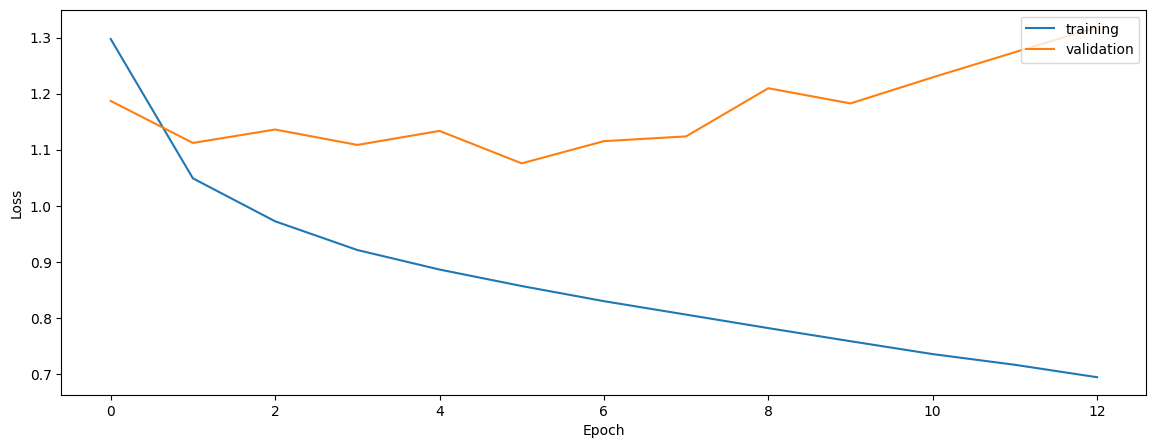

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.6777731555638496
0.5763972975061831
0.64175457350249


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.6070069186233182
0.5743718394437421
0.56596351427878


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6047392679119573
0.5820040622884225
0.5751580439090819


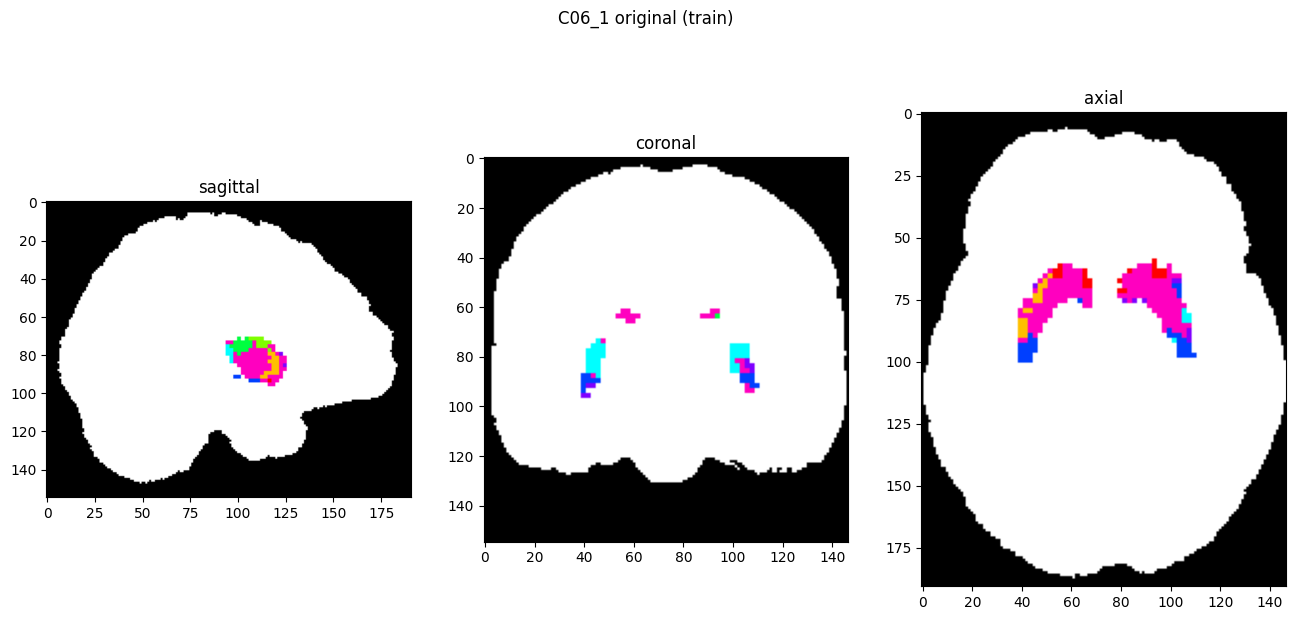

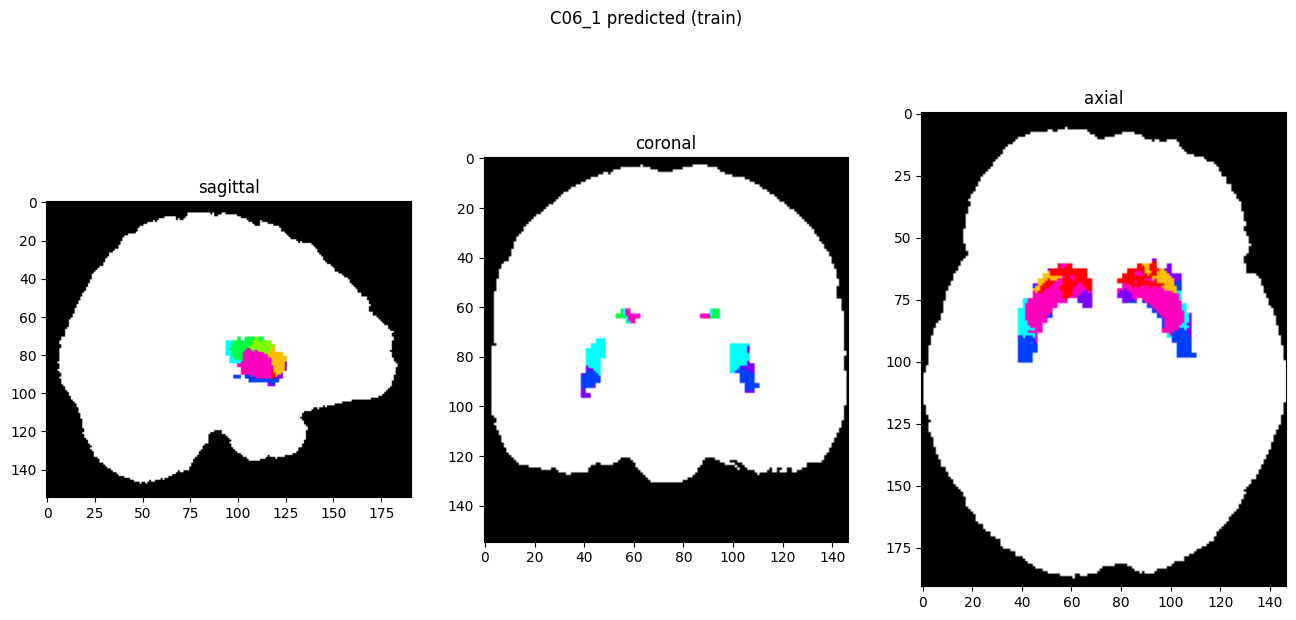

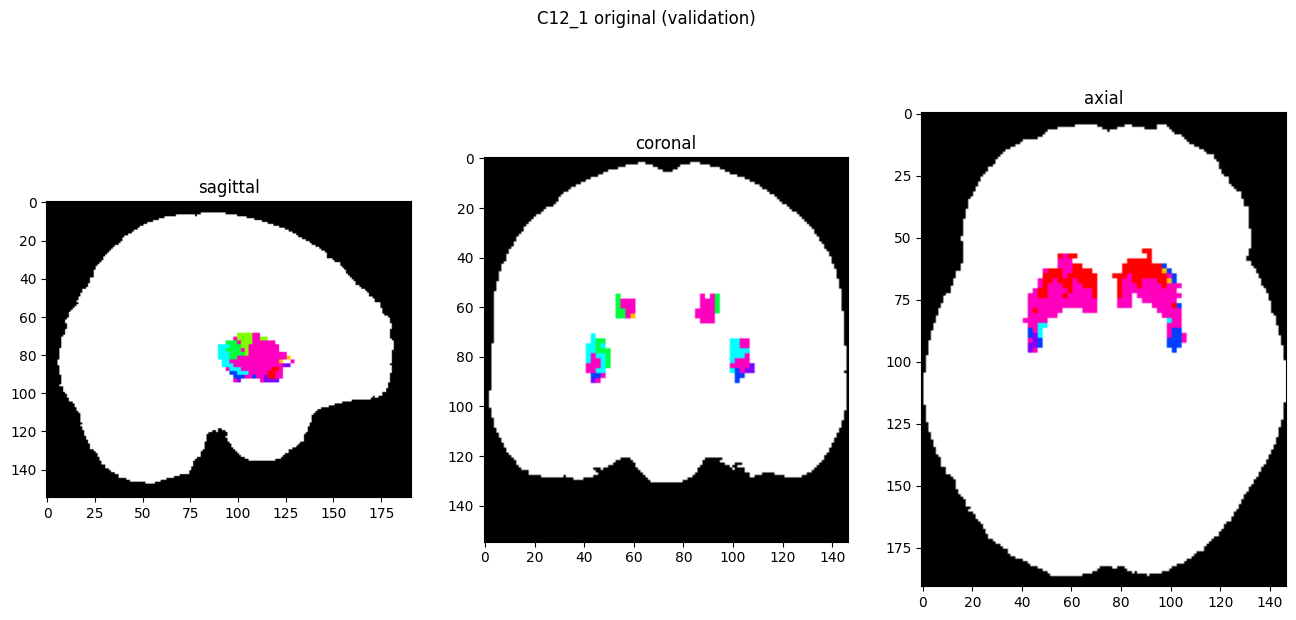

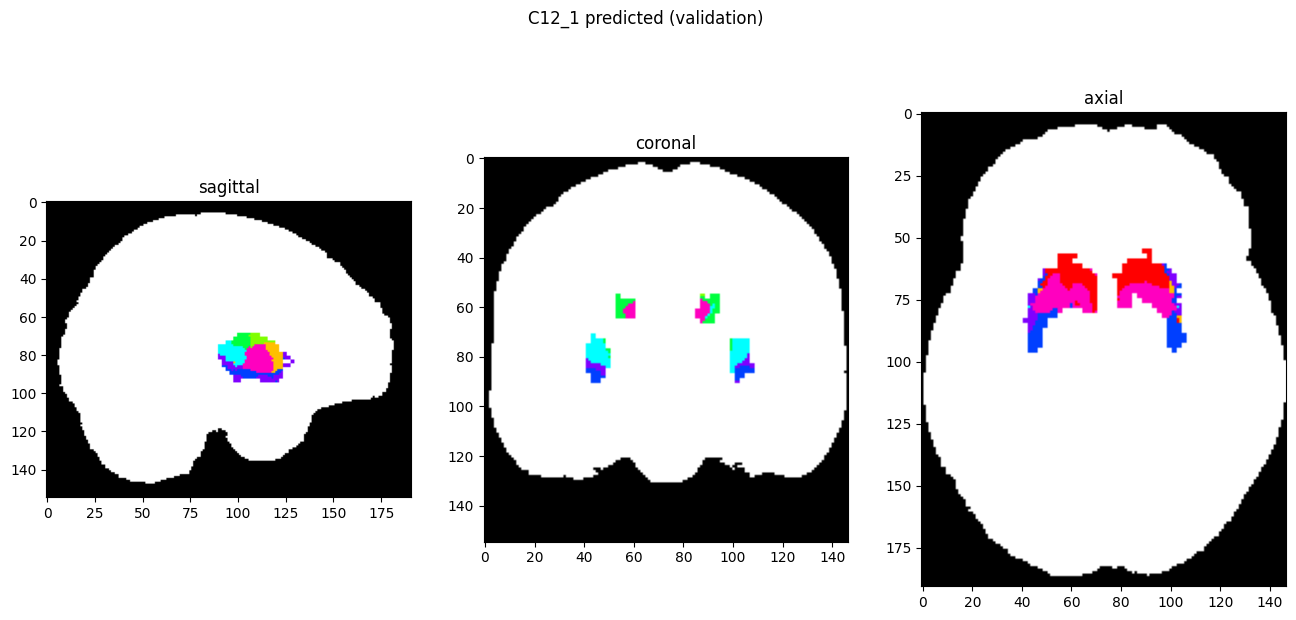

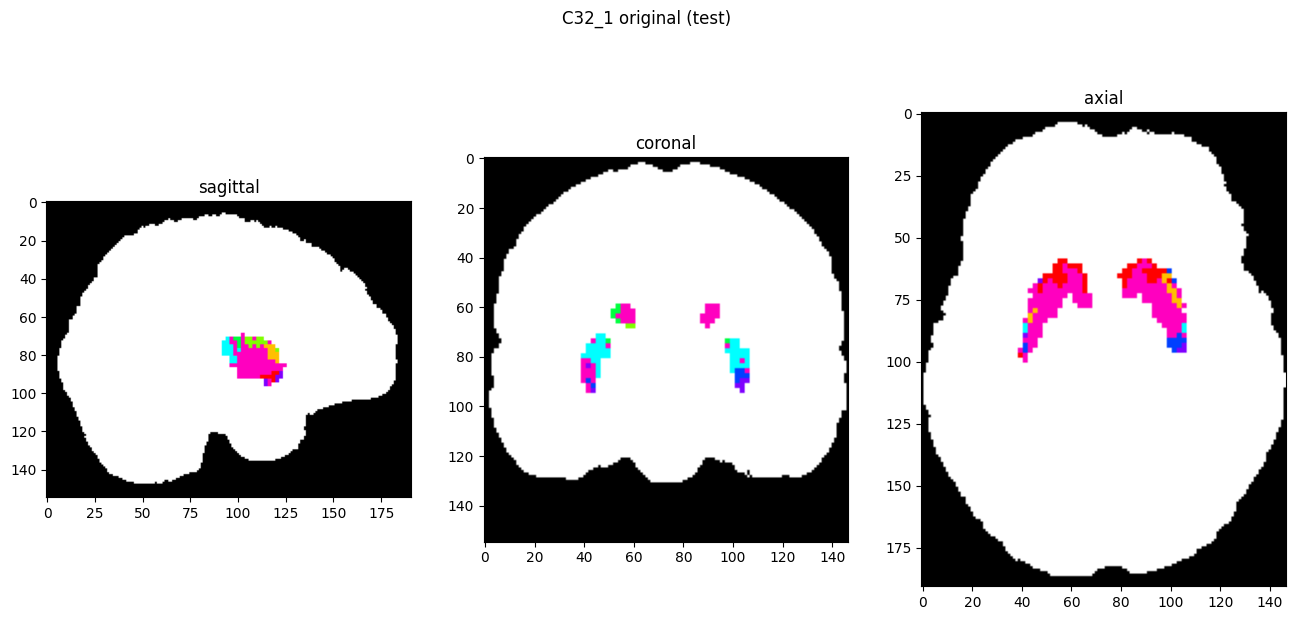

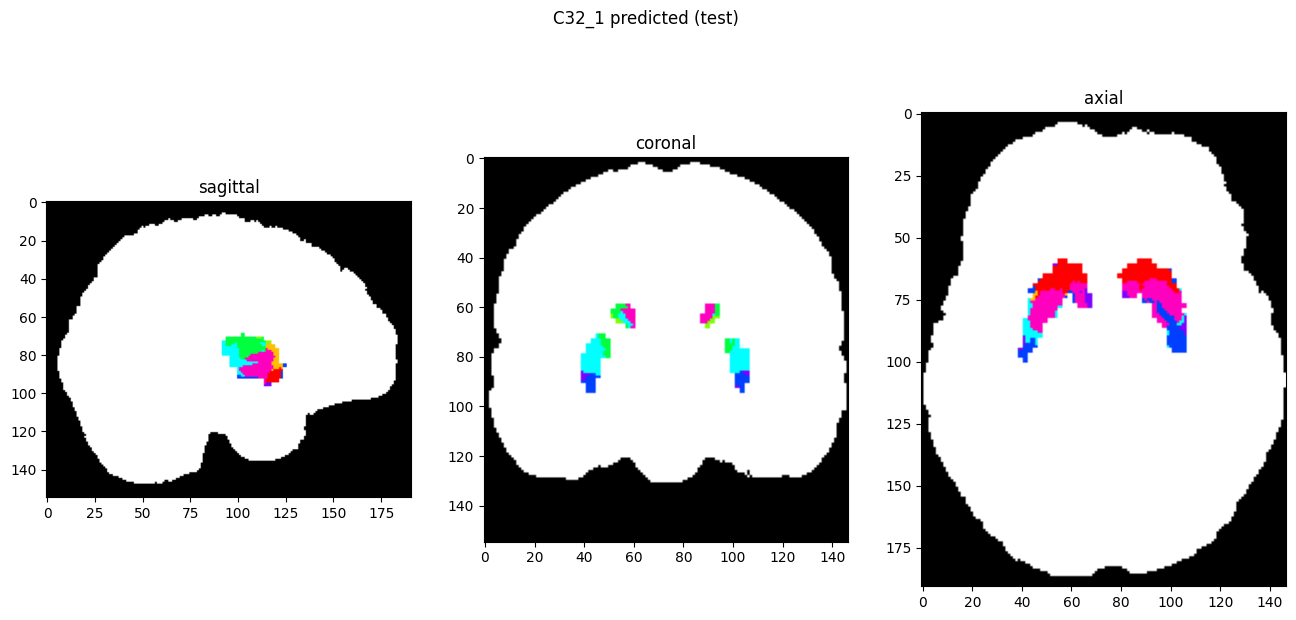

In [10]:
showResults(model, gen, threshold=0)